# Sliding time window laminar model comparison with two simultaneous sources

This tutorial demonstrates how to perform laminar inference of beta bursts in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). Two temporal Gaussian functions are simulated simultaneously in deep and superficial layers at a particular cortical location. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt
import k3d

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import interpolate_data
from lameg.util import get_surface_names, get_fiducial_coords
from lameg.viz import show_surface, color_map, rgbtoint
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas, lpa, rpa = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri', 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_data', subj_id, 'surf'), 
    'link_vector.fixed'
)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/sliding_window_beta_burst'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
09-Jul-2024 07:38:04 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 07:38:04 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           07:38:04 - 09/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR bala

## Simulating a beta burst
We're going to simulate a beta burst as two dipoles. One in the deep layer, a more narrow but stronger drive in the superficial layer (see [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479))

Text(0, 0.5, 'Amplitude (nAm)')

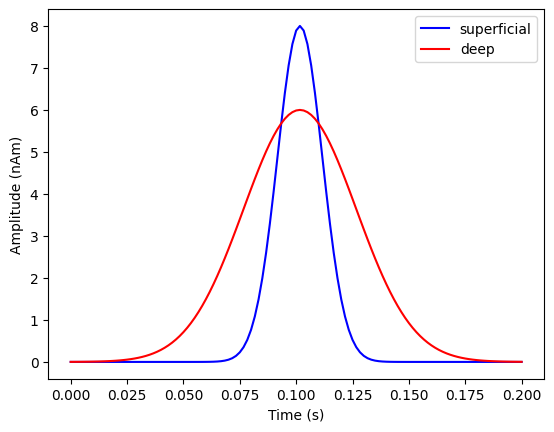

In [5]:
# Strength of each simulated source (nAm)
dipole_moment = [8, 6]
# Temporal width of the simulated superficial signal
superficial_width = .01 # 10ms
# Temporal width of the simulated deep signal
deep_width = .025 # 25ms

# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,.2,121)
zero_time = time[int((len(time)-1)/2+1)]
superficial_signal = np.exp(-((time-zero_time)**2)/(2*superficial_width**2))
deep_signal = np.exp(-((time-zero_time)**2)/(2*deep_width**2))

plt.plot(time,superficial_signal*dipole_moment[0], 'b', label='superficial')
plt.plot(time,deep_signal*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at. The superficial signal will be simulated as a dipole at the corresponding vertex on the pial surface, and the deep signal on the white matter surface. The dipole orientations will be in opposite directions (with the superficial one pointing toward the deep one, and vice versa). This will yield a cumulative dipole moment with a beta burst-like shape

In [6]:
# Location to simulate activity at
sim_vertex = 24588
# Corresponding pial and white matter vertices
pial_vertex = sim_vertex
white_vertex = (n_layers-1)*int(verts_per_surf)+sim_vertex
pial_coord = mesh.darrays[0].data[pial_vertex,:]
white_coord = mesh.darrays[0].data[white_vertex,:]

# Orientation of the simulated superficial dipole
pial_ori=mesh.darrays[2].data[pial_vertex,:]
# Orientation of the simulated deep dipole
white_ori=-1*mesh.darrays[2].data[white_vertex,:]

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))

pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
white_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'white.gii')
white_mesh = nib.load(white_mesh_fname)

cam_view = [85.5, -10.5, 32,
            0.5, 17, 43,
            0, 0, 1]

plot = k3d.plot(
    grid_visible=False, menu_visibility=False, camera_auto_fit=False
)

pial_vertices, pial_faces = pial_mesh.agg_data()
pial_k3d_mesh = k3d.mesh(pial_vertices, pial_faces, side="double", color=rgbtoint(col_r[0,:3]*255), opacity=0.5)
plot += pial_k3d_mesh

white_vertices, white_faces = white_mesh.agg_data()
white_k3d_mesh = k3d.mesh(white_vertices, white_faces, side="double", color=rgbtoint(col_r[-1,:3]*255), opacity=1)
plot += white_k3d_mesh

pts = k3d.points(
    np.vstack([pial_coord, white_coord]),
    point_size=1,
    color=rgbtoint([0,0,0])
)
plot += pts

dipole_vectors = k3d.vectors(
    np.vstack([pial_coord, white_coord]),
    vectors=np.vstack([pial_ori, white_ori])*2.3,
    head_size=5,
    line_width=0.1,
    colors=[rgbtoint([0,0,255]), rgbtoint([0,0,255]),
            rgbtoint([255,0,0]), rgbtoint([255,0,0])]
)
plot += dipole_vectors

plot.camera=cam_view

plot.display()

Output()

We'll simulate a 5mm patch of activity with -10 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [7]:
# Simulate a beta burst as two sources: one deep and one superficial
prefix=f'sim_{sim_vertex}_burst_'

# Size of simulated sources (mm)
sim_dipfwhm=[5, 5] # mm
# SNR of simulated data (dB)
SNR=-10

# Generate simulated data
burst_sim_fname=run_dipole_simulation(
    base_fname, 
    prefix, 
    [pial_vertex, white_vertex],
    np.vstack([superficial_signal, deep_signal]),
    np.vstack([pial_ori, white_ori]),
    dipole_moment, 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [8]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    burst_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    burst_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)


Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window_beta_burst/sim_24588_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


--------------

We can see that the prior is the same as the location we simulated at

In [9]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)
          
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view, 
    coords=prior_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

Output()

507832 vertices


## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. Because this window is so short, we'll use 2 temporal modes. If you increase the size of the window, you may have to increase the number of temporal modes. The free energy difference (pial - white matter) should be negative (more model evidence for the white matter surface model) at the start and end of the burst, and positive (more model evidence for the pial surface model) at the peak of the burst.

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
09-Jul-2024 08:01:58 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 08:01:58 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:02:14 - 09/07/2024
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creatin

  ReML Iteration              : 7                            ...3.993817e+01
  ReML Iteration              : 8                            ...3.242239e+01
  ReML Iteration              : 9                            ...2.501207e+01
  ReML Iteration              : 10                            ...1.816767e+01
  ReML Iteration              : 11                            ...1.236910e+01
  ReML Iteration              : 12                            ...7.902257e+00
  ReML Iteration              : 13                            ...4.767252e+00
  ReML Iteration              : 14                            ...2.742758e+00
  ReML Iteration              : 15                            ...1.522587e+00
  ReML Iteration              : 16                            ...8.255381e-01
  ReML Iteration              : 17                            ...4.425588e-01
  ReML Iteration              : 18                            ...2.375701e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration              : 19                            ...7.386885e-02
  ReML Iteration              : 20                            ...3.608534e-02
  ReML Iteration              : 21                            ...1.763244e-02
  ReML Iteration              : 22                            ...8.643268e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220728e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192817e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167664e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106666e+02 [+4.50]
  ReML Iteration 5                      :        ...9.652295e+01 [+4.62]
  ReML Iteration 6                      :        ...7.881319e-03 [+4.75]
Percent variance explained -3.41 (-3.33)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...3.890239e+01
  ReML Iteration              : 8                            ...3.118416e+01
  ReML Iteration              : 9                            ...2.366592e+01
  ReML Iteration              : 10                            ...1.684639e+01
  ReML Iteration              : 11                            ...1.119929e+01
  ReML Iteration              : 12                            ...6.961727e+00
  ReML Iteration              : 13                            ...4.071351e+00
  ReML Iteration              : 14                            ...2.260683e+00
  ReML Iteration              : 15                            ...1.204171e+00
  ReML Iteration              : 16                            ...6.214643e-01
  ReML Iteration              : 17                            ...3.135507e-01
  ReML Iteration              : 18                            ...1.558476e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.821853e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188710e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132474e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043132e+02 [+4.50]
  ReML Iteration 5                      :        ...8.439891e+01 [+4.62]
  ReML Iteration 6                      :        ...4.971856e-06 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.45

  ReML Iteration              : 1                            ...1.086632e+02
  ReML Iteration              : 2                            ...8.519016e+01
  ReML Iteration              : 3                            ...7.200576e+01
  ReML Iteration              : 4                            ...6.268885e+01
  ReML Iteration              : 5                            ...5.493755e+01
  ReML Iteration              : 6                            ...4.768094e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.160829e-01
  ReML Iteration              : 20                            ...6.259275e-02
  ReML Iteration              : 21                            ...3.462625e-02
  ReML Iteration              : 22                            ...1.980968e-02
  ReML Iteration              : 23                            ...1.179327e-02
  ReML Iteration              : 24                            ...7.337198e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219699e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193797e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170269e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113314e+02 [+4.50]
  ReML Iteration 5                      :        ...1.125778e-03 [+4.62]
Percent variance explained -100.78 (-90.20)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal mo

  ReML Iteration              : 1                            ...1.085773e+02
  ReML Iteration              : 2                            ...8.501369e+01
  ReML Iteration              : 3                            ...7.170098e+01
  ReML Iteration              : 4                            ...6.220119e+01
  ReML Iteration              : 5                            ...5.420644e+01
  ReML Iteration              : 6                            ...4.665459e+01
  ReML Iteration              : 7                            ...3.906616e+01
  ReML Iteration              : 8                            ...3.137862e+01
  ReML Iteration              : 9                            ...2.387549e+01
  ReML Iteration              : 10                            ...1.704987e+01
  ReML Iteration              : 11                            ...1.137712e+01
  ReML Iteration              : 12                            ...7.102503e+00
  ReML Iteration              : 13                            ...4.173573

Percent variance explained -55.92 (-46.70)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.55 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.954312e+02 [+4.12]
  ReML Iteration 2                      :        ...1.178186e+02 [+4.25]
  ReML Iteration 3                      :        ...1.101533e+02 [+4.38]
  ReML Iteration 4                      :        ...9.698252e+01 [+4.50]
  ReML Iteration 5                      :        ...7.012421e+01 [+4.62]
  ReML Iteration 6                      :        ...1.274544e-01 [+4.75]
  ReML Iteration 7                      :        ...1.669833e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.29


  ReML Iteration              : 13                            ...1.242130e+00
  ReML Iteration              : 14                            ...5.779213e-01
  ReML Iteration              : 15                            ...2.614016e-01
  ReML Iteration              : 16                            ...1.164901e-01
  ReML Iteration              : 17                            ...5.166097e-02
  ReML Iteration              : 18                            ...2.295689e-02
  ReML Iteration              : 19                            ...1.026679e-02
  ReML Iteration              : 20                            ...4.632720e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.234259e+02 [+4.12]
  ReML Iteration 2                      :        ...1.183077e+02 [+4.25]
  ReML Iteration 3                      :        ...1.141994e+02 [+4.38]
  ReML Iteration 4                      :        ...1.042578e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.087867e+02
  ReML Iteration              : 2                            ...8.198521e+01
  ReML Iteration              : 3                            ...6.657220e+01
  ReML Iteration              : 4                            ...5.430798e+01
  ReML Iteration              : 5                            ...4.306816e+01
  ReML Iteration              : 6                            ...3.233369e+01
  ReML Iteration              : 7                            ...2.247124e+01
  ReML Iteration              : 8                            ...1.422527e+01
  ReML Iteration              : 9                            ...8.149258e+00
  ReML Iteration              : 10                            ...4.245628e+00
  ReML Iteration              : 11                            ...2.042078e+00
  ReML Iteration              : 12                            ...9.259260e-01
  ReML Iteration              : 13                            ...4.043721

  ReML Iteration 1                      :        ...7.611360e+02 [+4.12]
  ReML Iteration 2                      :        ...1.071018e+02 [+4.25]
  ReML Iteration 3                      :        ...8.022408e+01 [+4.38]
  ReML Iteration 4                      :        ...4.277212e+01 [+4.50]
  ReML Iteration 5                      :        ...9.345085e+00 [+4.62]
  ReML Iteration 6                      :        ...3.229430e-01 [+4.75]
  ReML Iteration 7                      :        ...3.327097e-04 [+4.88]
log evidence & hyperparameters:
    0.00  566.65
    9.53   -1.20

  ReML Iteration              : 1                            ...1.214340e+02
  ReML Iteration              : 2                            ...7.552361e+01
  ReML Iteration              : 3                            ...5.622347e+01
  ReML Iteration              : 4                            ...4.013045e+01
  ReML Iteration              : 5                            ...2.626097e+01
  ReML Iteration              : 6    

  ReML Iteration              : 1                            ...2.476770e+02
  ReML Iteration              : 2                            ...6.118034e+01
  ReML Iteration              : 3                            ...3.519229e+01
  ReML Iteration              : 4                            ...1.805307e+01
  ReML Iteration              : 5                            ...7.891813e+00
  ReML Iteration              : 6                            ...3.007651e+00
  ReML Iteration              : 7                            ...1.052491e+00
  ReML Iteration              : 8                            ...3.561489e-01
  ReML Iteration              : 9                            ...1.207744e-01
  ReML Iteration              : 10                            ...4.183692e-02
  ReML Iteration              : 11                            ...1.492448e-02
  ReML Iteration              : 12                            ...5.494218e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...2.686610e+03 [+4.12]
  ReML Iteration 2                      :        ...1.353669e+02 [+4.25]
  ReML Iteration 3                      :        ...8.296018e+00 [+4.38]
  ReML Iteration 4                      :        ...2.177146e-01 [+4.50]
  ReML Iteration 5                      :        ...1.303850e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6226.55
    9.50    1.00

  ReML Iteration              : 1                            ...1.093425e+03
  ReML Iteration              : 2                            ...6.189079e+01
  ReML Iteration              : 3                            ...1.372712e+01
  ReML Iteration              : 4                            ...3.675845e+00
  ReML Iteration              : 5                            ...9.569907e-01
  ReML Iteration              : 6                            ...2.526299e-01
  ReML Iteration              : 7                            ...7.014578e-02
  ReML Iteration             

  ReML Iteration              : 7                            ...1.031214e-01
  ReML Iteration              : 8                            ...2.931492e-02
  ReML Iteration              : 9                            ...9.024024e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.260357e+03 [+4.12]
  ReML Iteration 2                      :        ...5.654563e+02 [+4.25]
  ReML Iteration 3                      :        ...7.317237e+00 [+4.38]
  ReML Iteration 4                      :        ...5.742793e-02 [+4.50]
  ReML Iteration 5                      :        ...4.182235e-06 [+4.62]
Percent variance explained 96.32 (84.30)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

  ReML Iteration              : 7                            ...1.017269e+00
  ReML Iteration              : 8                            ...2.912858e-01
  ReML Iteration              : 9                            ...9.000028e-02
  ReML Iteration              : 10                            ...2.960139e-02
  ReML Iteration              : 11                            ...1.025697e-02
  ReML Iteration              : 12                            ...3.714414e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.272351e+04 [+4.12]
  ReML Iteration 2                      :        ...2.903572e+03 [+4.25]
  ReML Iteration 3                      :        ...9.797350e+01 [+4.38]
  ReML Iteration 4                      :        ...8.195063e-02 [+4.50]
  ReML Iteration 5                      :        ...5.084730e-08 [+4.62]
Percent variance explained 97.43 (88.43)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.466016e+04
  ReML Iteration              : 2                            ...4.450370e+03
  ReML Iteration              : 3                            ...1.038593e+03
  ReML Iteration              : 4                            ...2.181942e+02
  ReML Iteration              : 5                            ...4.772513e+01
  ReML Iteration              : 6                            ...1.146830e+01
  ReML Iteration              : 7                            ...3.037559e+00
  ReML Iteration              : 8                            ...8.765437e-01
  ReML Iteration              : 9                            ...2.719147e-01
  ReML Iteration              : 10                            ...8.962574e-02
  ReML Iteration              : 11                            ...3.109268e-02
  ReML Iteration              : 12                            ...1.126746e-02
  ReML Iteration              : 13                            ...4.239515

Percent variance explained 97.61 (93.99)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.900457e+04 [+4.12]
  ReML Iteration 2                      :        ...8.636639e+03 [+4.25]
  ReML Iteration 3                      :        ...1.647225e+03 [+4.38]
  ReML Iteration 4                      :        ...6.605682e+01 [+4.50]
  ReML Iteration 5                      :        ...1.257231e-01 [+4.62]
  ReML Iteration 6                      :        ...4.807190e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42155.96
    9.07    3.55

  ReML Iteration              : 1                            ...1.586369e

  ReML Iteration              : 8                            ...3.836904e-01
  ReML Iteration              : 9                            ...1.186463e-01
  ReML Iteration              : 10                            ...3.904000e-02
  ReML Iteration              : 11                            ...1.353072e-02
  ReML Iteration              : 12                            ...4.900626e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.359575e+04 [+4.12]
  ReML Iteration 2                      :        ...3.412079e+03 [+4.25]
  ReML Iteration 3                      :        ...1.397699e+02 [+4.38]
  ReML Iteration 4                      :        ...1.677527e-01 [+4.50]
  ReML Iteration 5                      :        ...2.194705e-07 [+4.62]
Percent variance explained 95.65 (87.97)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.44 percent average variance
Using 1 spatial source priors pr

  ReML Iteration              : 7                            ...7.904940e-02
  ReML Iteration              : 8                            ...2.246400e-02
  ReML Iteration              : 9                            ...6.913810e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.636169e+03 [+4.12]
  ReML Iteration 2                      :        ...4.526618e+02 [+4.25]
  ReML Iteration 3                      :        ...7.176442e+00 [+4.38]
  ReML Iteration 4                      :        ...8.399931e-02 [+4.50]
  ReML Iteration 5                      :        ...1.010839e-05 [+4.62]
Percent variance explained 90.24 (81.04)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.164027e+04 [+4.12]
  ReML Iteration 2                      :        ...2.342673e+03 [+4.25]
  ReML Iteration 3                      :        ...6.155998e+01 [+4.38]
  ReML Iteration 4                      :        ...3.396054e-02 [+4.50]
  ReML Iteration 5                      :        ...7.093956e-09 [+4.62]
Percent variance explained 94.49 (89.43)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.53 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.493694e+04 [+4.12]
  ReML Iteration 2                      :        ...4.854209e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 8                            ...3.379326e-01
  ReML Iteration              : 9                            ...1.044568e-01
  ReML Iteration              : 10                            ...3.436392e-02
  ReML Iteration              : 11                            ...1.190869e-02
  ReML Iteration              : 12                            ...4.312869e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.319254e+04 [+4.12]
  ReML Iteration 2                      :        ...3.170531e+03 [+4.25]
  ReML Iteration 3                      :        ...1.188423e+02 [+4.38]
  ReML Iteration 4                      :        ...1.206930e-01 [+4.50]
  ReML Iteration 5                      :        ...1.125500e-07 [+4.62]
Percent variance explained 95.24 (90.89)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.70 percent average variance
Using 1 spatial source priors pr

  ReML Iteration              : 7                            ...2.088165e-01
  ReML Iteration              : 8                            ...5.944466e-02
  ReML Iteration              : 9                            ...1.831212e-02
  ReML Iteration              : 10                            ...6.013271e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.047411e+03 [+4.12]
  ReML Iteration 2                      :        ...9.870044e+02 [+4.25]
  ReML Iteration 3                      :        ...1.198487e+01 [+4.38]
  ReML Iteration 4                      :        ...2.179317e-02 [+4.50]
  ReML Iteration 5                      :        ...3.375458e-07 [+4.62]
Percent variance explained 92.50 (80.20)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.04 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.884047e+03 [+4.12]
  ReML Iteration 2                      :        ...1.238597e+03 [+4.25]
  ReML Iteration 3                      :        ...1.727775e+01 [+4.38]
  ReML Iteration 4                      :        ...1.551484e-02 [+4.50]
  ReML Iteration 5                      :        ...9.528164e-08 [+4.62]
Percent variance explained 93.18 (86.64)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.91 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.520022e+04 [+4.12]
  ReML Iteration 2                      :        ...5.060008e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...4.447439e+00
  ReML Iteration              : 8                            ...1.288353e+00
  ReML Iteration              : 9                            ...4.004639e-01
  ReML Iteration              : 10                            ...1.321393e-01
  ReML Iteration              : 11                            ...4.586888e-02
  ReML Iteration              : 12                            ...1.662784e-02
  ReML Iteration              : 13                            ...6.257685e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.746030e+04 [+4.12]
  ReML Iteration 2                      :        ...6.340870e+03 [+4.25]
  ReML Iteration 3                      :        ...5.672110e+02 [+4.38]
  ReML Iteration 4                      :        ...3.046747e+00 [+4.50]
  ReML Iteration 5                      :        ...7.521704e-05 [+4.62]
Percent variance explained 97.14 (91.21)

  ReML Iteration 1                      :        ...1.886134e+04 [+4.12]
  ReML Iteration 2                      :        ...8.480670e+03 [+4.25]
  ReML Iteration 3                      :        ...1.580537e+03 [+4.38]
  ReML Iteration 4                      :        ...6.023028e+01 [+4.50]
  ReML Iteration 5                      :        ...1.025839e-01 [+4.62]
  ReML Iteration 6                      :        ...3.126057e-07 [+4.75]
log evidence & hyperparameters:
    0.00 41763.25
    9.05    3.50

  ReML Iteration              : 1                            ...1.572198e+04
  ReML Iteration              : 2                            ...5.205129e+03
  ReML Iteration              : 3                            ...1.328733e+03
  ReML Iteration              : 4                            ...2.967925e+02
  ReML Iteration              : 5                            ...6.703134e+01
  ReML Iteration              : 6                            ...1.635591e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.411563e+04 [+4.12]
  ReML Iteration 2                      :        ...3.740383e+03 [+4.25]
  ReML Iteration 3                      :        ...1.714234e+02 [+4.38]
  ReML Iteration 4                      :        ...2.546812e-01 [+4.50]
  ReML Iteration 5                      :        ...5.098557e-07 [+4.62]
Percent variance explained 97.77 (89.51)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.432954e+04 [+4.12]
  ReML Iteration 2                      :        ...4.398940e+03 [+4.25]
  ReML Iteration

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.761624e+03 [+4.12]
  ReML Iteration 2                      :        ...9.092614e+02 [+4.25]
  ReML Iteration 3                      :        ...1.071039e+01 [+4.38]
  ReML Iteration 4                      :        ...2.506483e-02 [+4.50]
  ReML Iteration 5                      :        ...5.094320e-07 [+4.62]
Percent variance explained 97.04 (89.88)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.161492e+03 [+4.12]
  ReML Iteration 2                      :        ...1.187280e+03 [+4.25]
  ReML Iteration

  ReML Iteration 1                      :        ...3.161058e+03 [+4.12]
  ReML Iteration 2                      :        ...1.707552e+02 [+4.25]
  ReML Iteration 3                      :        ...5.644350e+00 [+4.38]
  ReML Iteration 4                      :        ...9.035329e-02 [+4.50]
  ReML Iteration 5                      :        ...2.349150e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7364.04
    9.51    1.19

  ReML Iteration              : 1                            ...1.423631e+03
  ReML Iteration              : 2                            ...7.448060e+01
  ReML Iteration              : 3                            ...1.236638e+01
  ReML Iteration              : 4                            ...2.802450e+00
  ReML Iteration              : 5                            ...6.671982e-01
  ReML Iteration              : 6                            ...1.682198e-01
  ReML Iteration              : 7                            ...4.564014e-02
  ReML Iteration             

  ReML Iteration 1                      :        ...1.259369e+03 [+4.12]
  ReML Iteration 2                      :        ...9.285162e+01 [+4.25]
  ReML Iteration 3                      :        ...3.768387e+01 [+4.38]
  ReML Iteration 4                      :        ...6.721810e+00 [+4.50]
  ReML Iteration 5                      :        ...1.440274e-01 [+4.62]
  ReML Iteration 6                      :        ...5.685609e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2294.52
    9.54    0.03

  ReML Iteration              : 1                            ...2.752393e+02
  ReML Iteration              : 2                            ...5.972614e+01
  ReML Iteration              : 3                            ...3.305351e+01
  ReML Iteration              : 4                            ...1.628087e+01
  ReML Iteration              : 5                            ...6.818741e+00
  ReML Iteration              : 6                            ...2.502994e+00
  ReML Iteration              : 7

  ReML Iteration 7                      :        ...4.769214e-05 [+4.88]
log evidence & hyperparameters:
    0.00  721.99
    9.54   -0.99

  ReML Iteration              : 1                            ...1.287984e+02
  ReML Iteration              : 2                            ...7.365348e+01
  ReML Iteration              : 3                            ...5.336254e+01
  ReML Iteration              : 4                            ...3.661011e+01
  ReML Iteration              : 5                            ...2.270565e+01
  ReML Iteration              : 6                            ...1.241423e+01
  ReML Iteration              : 7                            ...5.971881e+00
  ReML Iteration              : 8                            ...2.580610e+00
  ReML Iteration              : 9                            ...1.036487e+00
  ReML Iteration              : 10                            ...4.005348e-01
  ReML Iteration              : 11                            ...1.529424e-01
  ReML Iter

  ReML Iteration              : 1                            ...1.094966e+02
  ReML Iteration              : 2                            ...8.108469e+01
  ReML Iteration              : 3                            ...6.508311e+01
  ReML Iteration              : 4                            ...5.212561e+01
  ReML Iteration              : 5                            ...4.021666e+01
  ReML Iteration              : 6                            ...2.906027e+01
  ReML Iteration              : 7                            ...1.922862e+01
  ReML Iteration              : 8                            ...1.149051e+01
  ReML Iteration              : 9                            ...6.190421e+00
  ReML Iteration              : 10                            ...3.040064e+00
  ReML Iteration              : 11                            ...1.388934e+00
  ReML Iteration              : 12                            ...6.045468e-01
  ReML Iteration              : 13                            ...2.561630

  ReML Iteration 1                      :        ...6.039050e+02 [+4.12]
  ReML Iteration 2                      :        ...1.171629e+02 [+4.25]
  ReML Iteration 3                      :        ...1.082415e+02 [+4.38]
  ReML Iteration 4                      :        ...9.262816e+01 [+4.50]
  ReML Iteration 5                      :        ...6.242288e+01 [+4.62]
  ReML Iteration 6                      :        ...3.419575e-01 [+4.75]
  ReML Iteration 7                      :        ...1.194800e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.21

  ReML Iteration              : 1                            ...1.082746e+02
  ReML Iteration              : 2                            ...8.384458e+01
  ReML Iteration              : 3                            ...6.969855e+01
  ReML Iteration              : 4                            ...5.904940e+01
  ReML Iteration              : 5                            ...4.960252e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.434646e-02
  ReML Iteration              : 20                            ...1.587670e-02
  ReML Iteration              : 21                            ...7.371058e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223828e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190153e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160606e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088789e+02 [+4.50]
  ReML Iteration 5                      :        ...9.248088e+01 [+4.62]
  ReML Iteration 6                      :        ...5.711379e-02 [+4.75]
  ReML Iteration 7                      :        ...2.567378e-08 [+4.88]
Percent variance explained -62.65 (-52.45)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...4.053614e+01
  ReML Iteration              : 8                            ...3.314621e+01
  ReML Iteration              : 9                            ...2.581181e+01
  ReML Iteration              : 10                            ...1.896849e+01
  ReML Iteration              : 11                            ...1.309529e+01
  ReML Iteration              : 12                            ...8.502957e+00
  ReML Iteration              : 13                            ...5.227399e+00
  ReML Iteration              : 14                            ...3.076041e+00
  ReML Iteration              : 15                            ...1.756549e+00
  ReML Iteration              : 16                            ...9.893327e-01
  ReML Iteration              : 17                            ...5.610621e-01
  ReML Iteration              : 18                            ...3.306712e-01
  ReML Iteration              : 19                            ...2.

Percent variance explained -74.50 (-62.28)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.845381e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186816e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126881e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029618e+02 [+4.50]
  ReML Iteration 5                      :        ...8.164091e+01 [+4.62]
  ReML Iteration 6                      :        ...3.828235e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.43

  ReML Iteration              : 1                            ...1.085902

  ReML Iteration              : 19                            ...1.038760e-01
  ReML Iteration              : 20                            ...5.416309e-02
  ReML Iteration              : 21                            ...2.859040e-02
  ReML Iteration              : 22                            ...1.533574e-02
  ReML Iteration              : 23                            ...8.376215e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219908e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193593e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169728e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111930e+02 [+4.50]
  ReML Iteration 5                      :        ...2.025514e-03 [+4.62]
Percent variance explained -60.82 (-50.84)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.912305e+01
  ReML Iteration              : 8                            ...3.144629e+01
  ReML Iteration              : 9                            ...2.394857e+01
  ReML Iteration              : 10                            ...1.712102e+01
  ReML Iteration              : 11                            ...1.143950e+01
  ReML Iteration              : 12                            ...7.152073e+00
  ReML Iteration              : 13                            ...4.209732e+00
  ReML Iteration              : 14                            ...2.354437e+00
  ReML Iteration              : 15                            ...1.264309e+00
  ReML Iteration              : 16                            ...6.584965e-01
  ReML Iteration              : 17                            ...3.356925e-01
  ReML Iteration              : 18                            ...1.688174e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.837440e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187454e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128764e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034155e+02 [+4.50]
  ReML Iteration 5                      :        ...8.256025e+01 [+4.62]
  ReML Iteration 6                      :        ...1.620270e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.44

  ReML Iteration              : 1                            ...1.086140e+02
  ReML Iteration              : 2                            ...8.509172e+01
  ReML Iteration              : 3                            ...7.183567e+01
  ReML Iteration              : 4                            ...6.241643e+01
  ReML Iteration              : 5                            ...5.452851e+01
  ReML Iteration              : 6                            ...4.710539e+01
  ReML Iteration              : 7

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      08:10:33 - 09/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window_beta_burst/sim_24588_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m


Percent variance explained -24.14 (-23.54)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.835692e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187595e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129179e+02 [+4.38]
  ReML Iteration 4                      :        ...1.035157e+02 [+4.50]
  ReML Iteration 5                      :        ...8.276428e+01 [+4.62]
  ReML Iteration 6                      :        ...1.259481e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.64

  ReML Iteration              : 1                            ...1.086193e

  ReML Iteration              : 13                            ...4.112928e+00
  ReML Iteration              : 14                            ...2.288741e+00
  ReML Iteration              : 15                            ...1.222080e+00
  ReML Iteration              : 16                            ...6.324232e-01
  ReML Iteration              : 17                            ...3.200504e-01
  ReML Iteration              : 18                            ...1.596166e-01
  ReML Iteration              : 19                            ...7.895381e-02
  ReML Iteration              : 20                            ...3.893489e-02
  ReML Iteration              : 21                            ...1.921686e-02
  ReML Iteration              : 22                            ...9.519841e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220544e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192987e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085559e+02
  ReML Iteration              : 2                            ...8.496610e+01
  ReML Iteration              : 3                            ...7.161891e+01
  ReML Iteration              : 4                            ...6.207023e+01
  ReML Iteration              : 5                            ...5.401097e+01
  ReML Iteration              : 6                            ...4.638200e+01
  ReML Iteration              : 7                            ...3.871373e+01
  ReML Iteration              : 8                            ...3.096075e+01
  ReML Iteration              : 9                            ...2.342600e+01
  ReML Iteration              : 10                            ...1.661445e+01
  ReML Iteration              : 11                            ...1.099765e+01
  ReML Iteration              : 12                            ...6.803066e+00
  ReML Iteration              : 13                            ...3.956970

Percent variance explained -9.62 (-8.04)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.846466e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186729e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126624e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029001e+02 [+4.50]
  ReML Iteration 5                      :        ...8.151627e+01 [+4.62]
  ReML Iteration 6                      :        ...4.202145e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.62

  ReML Iteration              : 1                            ...1.085870e+

  ReML Iteration              : 13                            ...4.349285e+00
  ReML Iteration              : 14                            ...2.450046e+00
  ReML Iteration              : 15                            ...1.326513e+00
  ReML Iteration              : 16                            ...6.975142e-01
  ReML Iteration              : 17                            ...3.595876e-01
  ReML Iteration              : 18                            ...1.832508e-01
  ReML Iteration              : 19                            ...9.296059e-02
  ReML Iteration              : 20                            ...4.720595e-02
  ReML Iteration              : 21                            ...2.409635e-02
  ReML Iteration              : 22                            ...1.239838e-02
  ReML Iteration              : 23                            ...6.440358e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220144e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.084329e+02
  ReML Iteration              : 2                            ...8.464930e+01
  ReML Iteration              : 3                            ...7.107376e+01
  ReML Iteration              : 4                            ...6.120423e+01
  ReML Iteration              : 5                            ...5.272748e+01
  ReML Iteration              : 6                            ...4.461114e+01
  ReML Iteration              : 7                            ...3.645877e+01
  ReML Iteration              : 8                            ...2.834133e+01
  ReML Iteration              : 9                            ...2.068124e+01
  ReML Iteration              : 10                            ...1.403890e+01
  ReML Iteration              : 11                            ...8.835024e+00
  ReML Iteration              : 12                            ...5.167856e+00
  ReML Iteration              : 13                            ...2.830527

Percent variance explained -76.02 (-68.08)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.020818e+02 [+4.12]
  ReML Iteration 2                      :        ...1.173028e+02 [+4.25]
  ReML Iteration 3                      :        ...1.086485e+02 [+4.38]
  ReML Iteration 4                      :        ...9.354415e+01 [+4.50]
  ReML Iteration 5                      :        ...6.399603e+01 [+4.62]
  ReML Iteration 6                      :        ...2.871862e-01 [+4.75]
  ReML Iteration 7                      :        ...8.435045e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.56   -2.41


  ReML Iteration              : 14                            ...3.938223e-01
  ReML Iteration              : 15                            ...1.738815e-01
  ReML Iteration              : 16                            ...7.614554e-02
  ReML Iteration              : 17                            ...3.335697e-02
  ReML Iteration              : 18                            ...1.469780e-02
  ReML Iteration              : 19                            ...6.534903e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.241018e+02 [+4.12]
  ReML Iteration 2                      :        ...1.179365e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132311e+02 [+4.38]
  ReML Iteration 4                      :        ...1.019066e+02 [+4.50]
  ReML Iteration 5                      :        ...7.777746e+01 [+4.62]
  ReML Iteration 6                      :        ...7.277239e-01 [+4.75]
  ReML Iteration 7                      : 

  ReML Iteration              : 7                            ...1.923740e+01
  ReML Iteration              : 8                            ...1.149764e+01
  ReML Iteration              : 9                            ...6.195314e+00
  ReML Iteration              : 10                            ...3.042951e+00
  ReML Iteration              : 11                            ...1.390439e+00
  ReML Iteration              : 12                            ...6.052649e-01
  ReML Iteration              : 13                            ...2.564865e-01
  ReML Iteration              : 14                            ...1.075768e-01
  ReML Iteration              : 15                            ...4.516339e-02
  ReML Iteration              : 16                            ...1.910956e-02
  ReML Iteration              : 17                            ...8.180208e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.283169e+02 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 7                            ...5.855448e+00
  ReML Iteration              : 8                            ...2.519989e+00
  ReML Iteration              : 9                            ...1.008936e+00
  ReML Iteration              : 10                            ...3.890207e-01
  ReML Iteration              : 11                            ...1.483283e-01
  ReML Iteration              : 12                            ...5.687524e-02
  ReML Iteration              : 13                            ...2.213501e-02
  ReML Iteration              : 14                            ...8.781517e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.609418e+02 [+4.12]
  ReML Iteration 2                      :        ...1.100492e+02 [+4.25]
  ReML Iteration 3                      :        ...9.391635e+01 [+4.38]
  ReML Iteration 4                      :        ...6.210405e+01 [+4.50]
  ReML Iteration 5                 

Percent variance explained 84.03 (75.15)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.026782e+03 [+4.12]
  ReML Iteration 2                      :        ...1.031124e+02 [+4.25]
  ReML Iteration 3                      :        ...1.549521e+01 [+4.38]
  ReML Iteration 4                      :        ...8.738508e-01 [+4.50]
  ReML Iteration 5                      :        ...2.076990e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4533.04
    9.50    0.48

  ReML Iteration              : 1                            ...6.729355e+02
  ReML Iteration              : 2                            ...5.3861

Percent variance explained 95.44 (81.68)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.13 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.507525e+03 [+4.12]
  ReML Iteration 2                      :        ...4.954003e+02 [+4.25]
  ReML Iteration 3                      :        ...3.939979e+00 [+4.38]
  ReML Iteration 4                      :        ...2.631412e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12473.57
    9.47    1.59

  ReML Iteration              : 1                            ...3.255903e+03
  ReML Iteration              : 2                            ...2.229826e+02
  ReML Iteration              : 3                            ...2

  ReML Iteration              : 1                            ...7.115664e+03
  ReML Iteration              : 2                            ...9.614573e+02
  ReML Iteration              : 3                            ...1.195557e+02
  ReML Iteration              : 4                            ...1.825894e+01
  ReML Iteration              : 5                            ...3.476104e+00
  ReML Iteration              : 6                            ...7.861187e-01
  ReML Iteration              : 7                            ...2.024723e-01
  ReML Iteration              : 8                            ...5.763439e-02
  ReML Iteration              : 9                            ...1.775379e-02
  ReML Iteration              : 10                            ...5.829807e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.965006e+03 [+4.12]
  ReML Iteration 2                      :        ...9.641680e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration 1                      :        ...1.737627e+04 [+4.12]
  ReML Iteration 2                      :        ...6.964056e+03 [+4.25]
  ReML Iteration 3                      :        ...1.011836e+03 [+4.38]
  ReML Iteration 4                      :        ...2.234673e+01 [+4.50]
  ReML Iteration 5                      :        ...1.185144e-02 [+4.62]
  ReML Iteration 6                      :        ...3.374960e-09 [+4.75]
log evidence & hyperparameters:
    0.00 37866.42
    9.12    3.11

  ReML Iteration              : 1                            ...1.425887e+04
  ReML Iteration              : 2                            ...4.183880e+03
  ReML Iteration              : 3                            ...9.439161e+02
  ReML Iteration              : 4                            ...1.939952e+02
  ReML Iteration              : 5                            ...4.196634e+01
  ReML Iteration              : 6                            ...1.003263e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...8.448021e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.838602e+04 [+4.12]
  ReML Iteration 2                      :        ...7.221960e+03 [+4.25]
  ReML Iteration 3                      :        ...7.666206e+02 [+4.38]
  ReML Iteration 4                      :        ...5.740717e+00 [+4.50]
  ReML Iteration 5                      :        ...2.694707e-04 [+4.62]
Percent variance explained 99.23 (93.00)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.98 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.001669e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.563784e+04
  ReML Iteration              : 2                            ...5.142644e+03
  ReML Iteration              : 3                            ...1.303472e+03
  ReML Iteration              : 4                            ...2.896899e+02
  ReML Iteration              : 5                            ...6.525073e+01
  ReML Iteration              : 6                            ...1.590062e+01
  ReML Iteration              : 7                            ...4.239867e+00
  ReML Iteration              : 8                            ...1.227578e+00
  ReML Iteration              : 9                            ...3.814689e-01
  ReML Iteration              : 10                            ...1.258530e-01
  ReML Iteration              : 11                            ...4.368320e-02
  ReML Iteration              : 12                            ...1.583476e-02
  ReML Iteration              : 13                            ...5.959057

Percent variance explained 97.16 (87.87)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.06 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.138686e+04 [+4.12]
  ReML Iteration 2                      :        ...2.561348e+03 [+4.25]
  ReML Iteration 3                      :        ...1.086423e+02 [+4.38]
  ReML Iteration 4                      :        ...1.812116e-01 [+4.50]
  ReML Iteration 5                      :        ...4.945722e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24359.52
    9.39    2.47

  ReML Iteration              : 1                            ...8.503323e+03
  ReML Iteration              : 2                            ...1.382

  ReML Iteration 1                      :        ...8.713010e+03 [+4.12]
  ReML Iteration 2                      :        ...1.378587e+03 [+4.25]
  ReML Iteration 3                      :        ...2.813316e+01 [+4.38]
  ReML Iteration 4                      :        ...1.070174e-02 [+4.50]
  ReML Iteration 5                      :        ...1.487212e-09 [+4.62]
log evidence & hyperparameters:
    0.00 18941.67
    9.51    2.19

  ReML Iteration              : 1                            ...6.044010e+03
  ReML Iteration              : 2                            ...6.951614e+02
  ReML Iteration              : 3                            ...7.927944e+01
  ReML Iteration              : 4                            ...1.174185e+01
  ReML Iteration              : 5                            ...2.210782e+00
  ReML Iteration              : 6                            ...4.977388e-01
  ReML Iteration              : 7                            ...1.279421e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.470430e+04 [+4.12]
  ReML Iteration 2                      :        ...4.676634e+03 [+4.25]
  ReML Iteration 3                      :        ...4.132563e+02 [+4.38]
  ReML Iteration 4                      :        ...3.147823e+00 [+4.50]
  ReML Iteration 5                      :        ...1.845811e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31498.15
    9.39    2.95

  ReML Iteration              : 1                            ...1.165843e+04
  ReML Iteration              : 2                            ...2.692404e+03
  ReML Iteration              : 3                            ...4.882397e+02
  ReML Iteration              : 4                            ...8.832490e+01
  ReML Iteration              : 5                            ...1.800107e+01
  ReML Iteration              : 6                            ...4.189424e+00
  ReML Iteration              : 7                            ...1.093148e+00
  ReML Iteration            

Percent variance explained 90.63 (85.83)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.253840e+04 [+4.12]
  ReML Iteration 2                      :        ...3.209976e+03 [+4.25]
  ReML Iteration 3                      :        ...1.788221e+02 [+4.38]
  ReML Iteration 4                      :        ...5.211992e-01 [+4.50]
  ReML Iteration 5                      :        ...4.370615e-06 [+4.62]
log evidence & hyperparameters:
    0.00 26766.87
    9.45    2.70

  ReML Iteration              : 1                            ...9.587566e+03
  ReML Iteration              : 2                            ...1.775

Percent variance explained 88.18 (79.39)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.31 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.865016e+03 [+4.12]
  ReML Iteration 2                      :        ...1.834896e+03 [+4.25]
  ReML Iteration 3                      :        ...5.231734e+01 [+4.38]
  ReML Iteration 4                      :        ...3.902063e-02 [+4.50]
  ReML Iteration 5                      :        ...2.113642e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21255.49
    9.44    2.30

  ReML Iteration              : 1                            ...7.092263e+03
  ReML Iteration              : 2                            ...9.551

Percent variance explained 97.86 (89.94)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.01 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.752246e+04 [+4.12]
  ReML Iteration 2                      :        ...7.105344e+03 [+4.25]
  ReML Iteration 3                      :        ...1.058821e+03 [+4.38]
  ReML Iteration 4                      :        ...2.470825e+01 [+4.50]
  ReML Iteration 5                      :        ...1.471937e-02 [+4.62]
  ReML Iteration 6                      :        ...5.305197e-09 [+4.75]
log evidence & hyperparameters:
    0.00 38236.97
    9.14    3.15

  ReML Iteration              : 1                            ...1.440238e

  ReML Iteration              : 7                            ...6.214715e+00
  ReML Iteration              : 8                            ...1.807607e+00
  ReML Iteration              : 9                            ...5.630511e-01
  ReML Iteration              : 10                            ...1.859990e-01
  ReML Iteration              : 11                            ...6.460595e-02
  ReML Iteration              : 12                            ...2.342871e-02
  ReML Iteration              : 13                            ...8.818997e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.851710e+04 [+4.12]
  ReML Iteration 2                      :        ...7.352773e+03 [+4.25]
  ReML Iteration 3                      :        ...7.993238e+02 [+4.38]
  ReML Iteration 4                      :        ...6.269998e+00 [+4.50]
  ReML Iteration 5                      :        ...3.219028e-04 [+4.62]
Percent variance explained 99.04 (93.11)

  ReML Iteration 1                      :        ...1.820240e+04 [+4.12]
  ReML Iteration 2                      :        ...7.785289e+03 [+4.25]
  ReML Iteration 3                      :        ...1.302009e+03 [+4.38]
  ReML Iteration 4                      :        ...3.909680e+01 [+4.50]
  ReML Iteration 5                      :        ...3.982595e-02 [+4.62]
  ReML Iteration 6                      :        ...4.261382e-08 [+4.75]
log evidence & hyperparameters:
    0.00 39996.50
    9.06    3.20

  ReML Iteration              : 1                            ...1.507137e+04
  ReML Iteration              : 2                            ...4.734017e+03
  ReML Iteration              : 3                            ...1.143808e+03
  ReML Iteration              : 4                            ...2.459340e+02
  ReML Iteration              : 5                            ...5.443680e+01
  ReML Iteration              : 6                            ...1.315488e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.287731e+04 [+4.12]
  ReML Iteration 2                      :        ...2.989469e+03 [+4.25]
  ReML Iteration 3                      :        ...1.044332e+02 [+4.38]
  ReML Iteration 4                      :        ...9.307157e-02 [+4.50]
  ReML Iteration 5                      :        ...6.614026e-08 [+4.62]
Percent variance explained 98.91 (93.37)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.314181e+04 [+4.12]
  ReML Iteration 2                      :        ...3.585475e+03 [+4.25]
  ReML Iteration

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.388450e+03 [+4.12]
  ReML Iteration 2                      :        ...5.907201e+02 [+4.25]
  ReML Iteration 3                      :        ...7.426659e+00 [+4.38]
  ReML Iteration 4                      :        ...5.325090e-02 [+4.50]
  ReML Iteration 5                      :        ...3.495767e-06 [+4.62]
Percent variance explained 97.95 (85.69)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.705813e+03 [+4.12]
  ReML Iteration 2                      :        ...7.624980e+02 [+4.25]
  ReML Iteration

Percent variance explained 94.17 (79.71)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.16 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.590568e+03 [+4.12]
  ReML Iteration 2                      :        ...1.294302e+02 [+4.25]
  ReML Iteration 3                      :        ...9.028543e+00 [+4.38]
  ReML Iteration 4                      :        ...2.628963e-01 [+4.50]
  ReML Iteration 5                      :        ...1.889834e-04 [+4.62]
log evidence & hyperparameters:
    0.00 5989.17
    9.52    0.78

  ReML Iteration              : 1                            ...1.029090e+03
  ReML Iteration              : 2                            ...6.0030

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.513426e+02 [+4.12]
  ReML Iteration 2                      :        ...9.655007e+01 [+4.25]
  ReML Iteration 3                      :        ...6.540692e+01 [+4.38]
  ReML Iteration 4                      :        ...2.452223e+01 [+4.50]
  ReML Iteration 5                      :        ...2.365719e+00 [+4.62]
  ReML Iteration 6                      :        ...1.467169e-02 [+4.75]
  ReML Iteration 7                      :        ...3.644609e-07 [+4.88]
Percent variance explained 84.11 (75.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration

Percent variance explained -5018.45 (-4486.79)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.047880e+02 [+4.12]
  ReML Iteration 2                      :        ...1.102890e+02 [+4.25]
  ReML Iteration 3                      :        ...8.887408e+01 [+4.38]
  ReML Iteration 4                      :        ...5.554953e+01 [+4.50]
  ReML Iteration 5                      :        ...1.754957e+01 [+4.62]
  ReML Iteration 6                      :        ...1.317362e+00 [+4.75]
  ReML Iteration 7                      :        ...1.016763e+01 [+3.75]
  ReML Iteration 8                      :        ...1.036032e-

Percent variance explained -753.77 (-675.37)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.55 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.177672e+02 [+4.12]
  ReML Iteration 2                      :        ...1.161184e+02 [+4.25]
  ReML Iteration 3                      :        ...1.052218e+02 [+4.38]
  ReML Iteration 4                      :        ...8.601639e+01 [+4.50]
  ReML Iteration 5                      :        ...5.178905e+01 [+4.62]
  ReML Iteration 6                      :        ...9.102296e-01 [+4.75]
  ReML Iteration 7                      :        ...8.424778e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.2

  ReML Iteration              : 19                            ...1.154390e-02
  ReML Iteration              : 20                            ...5.215777e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.232821e+02 [+4.12]
  ReML Iteration 2                      :        ...1.183937e+02 [+4.25]
  ReML Iteration 3                      :        ...1.144245e+02 [+4.38]
  ReML Iteration 4                      :        ...1.048094e+02 [+4.50]
  ReML Iteration 5                      :        ...8.369704e+01 [+4.62]
  ReML Iteration 6                      :        ...3.501321e-01 [+4.75]
  ReML Iteration 7                      :        ...9.494771e-07 [+4.88]
Percent variance explained -156.30 (-139.72)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  

  ReML Iteration              : 1                            ...1.084319e+02
  ReML Iteration              : 2                            ...8.464617e+01
  ReML Iteration              : 3                            ...7.106839e+01
  ReML Iteration              : 4                            ...6.119573e+01
  ReML Iteration              : 5                            ...5.271495e+01
  ReML Iteration              : 6                            ...4.459403e+01
  ReML Iteration              : 7                            ...3.643726e+01
  ReML Iteration              : 8                            ...2.831680e+01
  ReML Iteration              : 9                            ...2.065614e+01
  ReML Iteration              : 10                            ...1.401601e+01
  ReML Iteration              : 11                            ...8.816451e+00
  ReML Iteration              : 12                            ...5.154353e+00
  ReML Iteration              : 13                            ...2.821633

Percent variance explained -213.29 (-178.33)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.833079e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187805e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129800e+02 [+4.38]
  ReML Iteration 4                      :        ...1.036656e+02 [+4.50]
  ReML Iteration 5                      :        ...8.307008e+01 [+4.62]
  ReML Iteration 6                      :        ...8.050155e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.64

  ReML Iteration              : 1                            ...1.0862

  ReML Iteration              : 13                            ...4.312001e+00
  ReML Iteration              : 14                            ...2.424398e+00
  ReML Iteration              : 15                            ...1.309739e+00
  ReML Iteration              : 16                            ...6.869198e-01
  ReML Iteration              : 17                            ...3.530400e-01
  ReML Iteration              : 18                            ...1.792483e-01
  ReML Iteration              : 19                            ...9.052118e-02
  ReML Iteration              : 20                            ...4.571639e-02
  ReML Iteration              : 21                            ...2.318347e-02
  ReML Iteration              : 22                            ...1.183723e-02
  ReML Iteration              : 23                            ...6.094982e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220204e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085596e+02
  ReML Iteration              : 2                            ...8.497449e+01
  ReML Iteration              : 3                            ...7.163338e+01
  ReML Iteration              : 4                            ...6.209330e+01
  ReML Iteration              : 5                            ...5.404538e+01
  ReML Iteration              : 6                            ...4.642993e+01
  ReML Iteration              : 7                            ...3.877560e+01
  ReML Iteration              : 8                            ...3.103394e+01
  ReML Iteration              : 9                            ...2.350450e+01
  ReML Iteration              : 10                            ...1.669022e+01
  ReML Iteration              : 11                            ...1.106340e+01
  ReML Iteration              : 12                            ...6.854686e+00
  ReML Iteration              : 13                            ...3.994087

Percent variance explained -56.69 (-52.26)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.68 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.842148e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187076e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127647e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031462e+02 [+4.50]
  ReML Iteration 5                      :        ...8.201385e+01 [+4.62]
  ReML Iteration 6                      :        ...2.816566e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.63

  ReML Iteration              : 1                            ...1.085998e

  ReML Iteration              : 19                            ...1.101077e-01
  ReML Iteration              : 20                            ...5.837296e-02
  ReML Iteration              : 21                            ...3.151623e-02
  ReML Iteration              : 22                            ...1.742214e-02
  ReML Iteration              : 23                            ...9.894384e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219795e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193703e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170019e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112675e+02 [+4.50]
  ReML Iteration 5                      :        ...1.508465e-03 [+4.62]
Percent variance explained -24.07 (-23.64)
       priors: []
         type: 'MSP'
          woi: [121x2 double]
          Han: 1
          lpf: 0
          hpf: 256
    mergeflag: 0
           

Text(0, 0.5, '$\\Delta$F')

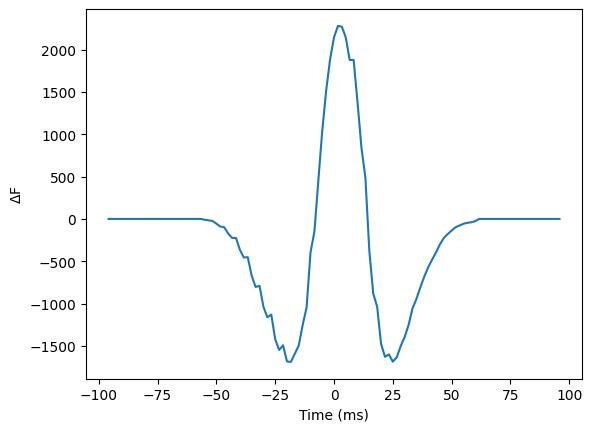

In [10]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 16
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    burst_sim_fname, 
    patch_size=patch_size, 
    n_temp_modes=sliding_n_temp_modes,
    win_size=win_size, 
    win_overlap=win_overlap,
    spm_instance=spm
)

# Plot difference in free energy over time (pial minus white) - this should be negative at the beginning and end 
# of the burst, and positive at the center
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Simulation in each layer with sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's run it across all layers. We'll turn off SPM visualization here.

In [12]:
# Run sliding window model comparison across all layers
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    layer_fnames, 
    burst_sim_fname, 
    patch_size=patch_size, 
    n_temp_modes=sliding_n_temp_modes, 
    win_size=win_size, 
    win_overlap=win_overlap, 
    viz=False,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
09-Jul-2024 08:17:53 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 08:17:53 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:18:17 - 09/07/2024
Completed                               :          08:18:18 - 09/07/2024
09-Jul-2024 08:18:19 - Done    'Head model specification'
09-Jul-2024 08:18:19 -

  ReML Iteration              : 13                            ...4.767252e+00
  ReML Iteration              : 14                            ...2.742758e+00
  ReML Iteration              : 15                            ...1.522587e+00
  ReML Iteration              : 16                            ...8.255381e-01
  ReML Iteration              : 17                            ...4.425588e-01
  ReML Iteration              : 18                            ...2.375701e-01
  ReML Iteration              : 19                            ...1.294867e-01
  ReML Iteration              : 20                            ...7.280038e-02
  ReML Iteration              : 21                            ...4.299535e-02
  ReML Iteration              : 22                            ...2.723787e-02
  ReML Iteration              : 23                            ...1.896541e-02
  ReML Iteration              : 24                            ...1.495387e-02
  ReML Iteration              : 25                            ..

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220728e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192817e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167664e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106666e+02 [+4.50]
  ReML Iteration 5                      :        ...9.652295e+01 [+4.62]
  ReML Iteration 6                      :        ...7.881319e-03 [+4.75]
Percent variance explained -3.41 (-3.33)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.850542e+02 [+4.12]
  ReML Iteration

  ReML Iteration              : 7                            ...3.890239e+01
  ReML Iteration              : 8                            ...3.118416e+01
  ReML Iteration              : 9                            ...2.366592e+01
  ReML Iteration              : 10                            ...1.684639e+01
  ReML Iteration              : 11                            ...1.119929e+01
  ReML Iteration              : 12                            ...6.961727e+00
  ReML Iteration              : 13                            ...4.071351e+00
  ReML Iteration              : 14                            ...2.260683e+00
  ReML Iteration              : 15                            ...1.204171e+00
  ReML Iteration              : 16                            ...6.214643e-01
  ReML Iteration              : 17                            ...3.135507e-01
  ReML Iteration              : 18                            ...1.558476e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.821853e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188710e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132474e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043132e+02 [+4.50]
  ReML Iteration 5                      :        ...8.439891e+01 [+4.62]
  ReML Iteration 6                      :        ...4.971856e-06 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.45

  ReML Iteration              : 1                            ...1.086632e+02
  ReML Iteration              : 2                            ...8.519016e+01
  ReML Iteration              : 3                            ...7.200576e+01
  ReML Iteration              : 4                            ...6.268885e+01
  ReML Iteration              : 5                            ...5.493755e+01
  ReML Iteration              : 6                            ...4.768094e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.160829e-01
  ReML Iteration              : 20                            ...6.259275e-02
  ReML Iteration              : 21                            ...3.462625e-02
  ReML Iteration              : 22                            ...1.980968e-02
  ReML Iteration              : 23                            ...1.179327e-02
  ReML Iteration              : 24                            ...7.337198e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219699e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193797e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170269e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113314e+02 [+4.50]
  ReML Iteration 5                      :        ...1.125778e-03 [+4.62]
Percent variance explained -100.78 (-90.20)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal mo

  ReML Iteration              : 1                            ...1.085773e+02
  ReML Iteration              : 2                            ...8.501369e+01
  ReML Iteration              : 3                            ...7.170098e+01
  ReML Iteration              : 4                            ...6.220119e+01
  ReML Iteration              : 5                            ...5.420644e+01
  ReML Iteration              : 6                            ...4.665459e+01
  ReML Iteration              : 7                            ...3.906616e+01
  ReML Iteration              : 8                            ...3.137862e+01
  ReML Iteration              : 9                            ...2.387549e+01
  ReML Iteration              : 10                            ...1.704987e+01
  ReML Iteration              : 11                            ...1.137712e+01
  ReML Iteration              : 12                            ...7.102503e+00
  ReML Iteration              : 13                            ...4.173573

Percent variance explained -55.92 (-46.70)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.55 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.954312e+02 [+4.12]
  ReML Iteration 2                      :        ...1.178186e+02 [+4.25]
  ReML Iteration 3                      :        ...1.101533e+02 [+4.38]
  ReML Iteration 4                      :        ...9.698252e+01 [+4.50]
  ReML Iteration 5                      :        ...7.012421e+01 [+4.62]
  ReML Iteration 6                      :        ...1.274544e-01 [+4.75]
  ReML Iteration 7                      :        ...1.669833e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.29


  ReML Iteration              : 13                            ...1.242130e+00
  ReML Iteration              : 14                            ...5.779213e-01
  ReML Iteration              : 15                            ...2.614016e-01
  ReML Iteration              : 16                            ...1.164901e-01
  ReML Iteration              : 17                            ...5.166097e-02
  ReML Iteration              : 18                            ...2.295689e-02
  ReML Iteration              : 19                            ...1.026679e-02
  ReML Iteration              : 20                            ...4.632720e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.234259e+02 [+4.12]
  ReML Iteration 2                      :        ...1.183077e+02 [+4.25]
  ReML Iteration 3                      :        ...1.141994e+02 [+4.38]
  ReML Iteration 4                      :        ...1.042578e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.087867e+02
  ReML Iteration              : 2                            ...8.198521e+01
  ReML Iteration              : 3                            ...6.657220e+01
  ReML Iteration              : 4                            ...5.430798e+01
  ReML Iteration              : 5                            ...4.306816e+01
  ReML Iteration              : 6                            ...3.233369e+01
  ReML Iteration              : 7                            ...2.247124e+01
  ReML Iteration              : 8                            ...1.422527e+01
  ReML Iteration              : 9                            ...8.149258e+00
  ReML Iteration              : 10                            ...4.245628e+00
  ReML Iteration              : 11                            ...2.042078e+00
  ReML Iteration              : 12                            ...9.259260e-01
  ReML Iteration              : 13                            ...4.043721

  ReML Iteration 1                      :        ...7.611360e+02 [+4.12]
  ReML Iteration 2                      :        ...1.071018e+02 [+4.25]
  ReML Iteration 3                      :        ...8.022408e+01 [+4.38]
  ReML Iteration 4                      :        ...4.277212e+01 [+4.50]
  ReML Iteration 5                      :        ...9.345085e+00 [+4.62]
  ReML Iteration 6                      :        ...3.229430e-01 [+4.75]
  ReML Iteration 7                      :        ...3.327097e-04 [+4.88]
log evidence & hyperparameters:
    0.00  566.65
    9.53   -1.20

  ReML Iteration              : 1                            ...1.214340e+02
  ReML Iteration              : 2                            ...7.552361e+01
  ReML Iteration              : 3                            ...5.622347e+01
  ReML Iteration              : 4                            ...4.013045e+01
  ReML Iteration              : 5                            ...2.626097e+01
  ReML Iteration              : 6    

  ReML Iteration              : 1                            ...2.476770e+02
  ReML Iteration              : 2                            ...6.118034e+01
  ReML Iteration              : 3                            ...3.519229e+01
  ReML Iteration              : 4                            ...1.805307e+01
  ReML Iteration              : 5                            ...7.891813e+00
  ReML Iteration              : 6                            ...3.007651e+00
  ReML Iteration              : 7                            ...1.052491e+00
  ReML Iteration              : 8                            ...3.561489e-01
  ReML Iteration              : 9                            ...1.207744e-01
  ReML Iteration              : 10                            ...4.183692e-02
  ReML Iteration              : 11                            ...1.492448e-02
  ReML Iteration              : 12                            ...5.494218e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...2.686610e+03 [+4.12]
  ReML Iteration 2                      :        ...1.353669e+02 [+4.25]
  ReML Iteration 3                      :        ...8.296018e+00 [+4.38]
  ReML Iteration 4                      :        ...2.177146e-01 [+4.50]
  ReML Iteration 5                      :        ...1.303850e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6226.55
    9.50    1.00

  ReML Iteration              : 1                            ...1.093425e+03
  ReML Iteration              : 2                            ...6.189079e+01
  ReML Iteration              : 3                            ...1.372712e+01
  ReML Iteration              : 4                            ...3.675845e+00
  ReML Iteration              : 5                            ...9.569907e-01
  ReML Iteration              : 6                            ...2.526299e-01
  ReML Iteration              : 7                            ...7.014578e-02
  ReML Iteration             

  ReML Iteration              : 7                            ...1.031214e-01
  ReML Iteration              : 8                            ...2.931492e-02
  ReML Iteration              : 9                            ...9.024024e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.260357e+03 [+4.12]
  ReML Iteration 2                      :        ...5.654563e+02 [+4.25]
  ReML Iteration 3                      :        ...7.317237e+00 [+4.38]
  ReML Iteration 4                      :        ...5.742793e-02 [+4.50]
  ReML Iteration 5                      :        ...4.182235e-06 [+4.62]
Percent variance explained 96.32 (84.30)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

  ReML Iteration              : 7                            ...1.017269e+00
  ReML Iteration              : 8                            ...2.912858e-01
  ReML Iteration              : 9                            ...9.000028e-02
  ReML Iteration              : 10                            ...2.960139e-02
  ReML Iteration              : 11                            ...1.025697e-02
  ReML Iteration              : 12                            ...3.714414e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.272351e+04 [+4.12]
  ReML Iteration 2                      :        ...2.903572e+03 [+4.25]
  ReML Iteration 3                      :        ...9.797350e+01 [+4.38]
  ReML Iteration 4                      :        ...8.195063e-02 [+4.50]
  ReML Iteration 5                      :        ...5.084730e-08 [+4.62]
Percent variance explained 97.43 (88.43)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.466016e+04
  ReML Iteration              : 2                            ...4.450370e+03
  ReML Iteration              : 3                            ...1.038593e+03
  ReML Iteration              : 4                            ...2.181942e+02
  ReML Iteration              : 5                            ...4.772513e+01
  ReML Iteration              : 6                            ...1.146830e+01
  ReML Iteration              : 7                            ...3.037559e+00
  ReML Iteration              : 8                            ...8.765437e-01
  ReML Iteration              : 9                            ...2.719147e-01
  ReML Iteration              : 10                            ...8.962574e-02
  ReML Iteration              : 11                            ...3.109268e-02
  ReML Iteration              : 12                            ...1.126746e-02
  ReML Iteration              : 13                            ...4.239515

Percent variance explained 97.61 (93.99)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.900457e+04 [+4.12]
  ReML Iteration 2                      :        ...8.636639e+03 [+4.25]
  ReML Iteration 3                      :        ...1.647225e+03 [+4.38]
  ReML Iteration 4                      :        ...6.605682e+01 [+4.50]
  ReML Iteration 5                      :        ...1.257231e-01 [+4.62]
  ReML Iteration 6                      :        ...4.807190e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42155.96
    9.07    3.55

  ReML Iteration              : 1                            ...1.586369e

  ReML Iteration              : 8                            ...3.836904e-01
  ReML Iteration              : 9                            ...1.186463e-01
  ReML Iteration              : 10                            ...3.904000e-02
  ReML Iteration              : 11                            ...1.353072e-02
  ReML Iteration              : 12                            ...4.900626e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.359575e+04 [+4.12]
  ReML Iteration 2                      :        ...3.412079e+03 [+4.25]
  ReML Iteration 3                      :        ...1.397699e+02 [+4.38]
  ReML Iteration 4                      :        ...1.677527e-01 [+4.50]
  ReML Iteration 5                      :        ...2.194705e-07 [+4.62]
Percent variance explained 95.65 (87.97)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.44 percent average variance
Using 1 spatial source priors pr

  ReML Iteration              : 7                            ...7.904940e-02
  ReML Iteration              : 8                            ...2.246400e-02
  ReML Iteration              : 9                            ...6.913810e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.636169e+03 [+4.12]
  ReML Iteration 2                      :        ...4.526618e+02 [+4.25]
  ReML Iteration 3                      :        ...7.176442e+00 [+4.38]
  ReML Iteration 4                      :        ...8.399931e-02 [+4.50]
  ReML Iteration 5                      :        ...1.010839e-05 [+4.62]
Percent variance explained 90.24 (81.04)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.164027e+04 [+4.12]
  ReML Iteration 2                      :        ...2.342673e+03 [+4.25]
  ReML Iteration 3                      :        ...6.155998e+01 [+4.38]
  ReML Iteration 4                      :        ...3.396054e-02 [+4.50]
  ReML Iteration 5                      :        ...7.093956e-09 [+4.62]
Percent variance explained 94.49 (89.43)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.53 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.493694e+04 [+4.12]
  ReML Iteration 2                      :        ...4.854209e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.179213e+00
  ReML Iteration              : 8                            ...3.379326e-01
  ReML Iteration              : 9                            ...1.044568e-01
  ReML Iteration              : 10                            ...3.436392e-02
  ReML Iteration              : 11                            ...1.190869e-02
  ReML Iteration              : 12                            ...4.312869e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.319254e+04 [+4.12]
  ReML Iteration 2                      :        ...3.170531e+03 [+4.25]
  ReML Iteration 3                      :        ...1.188423e+02 [+4.38]
  ReML Iteration 4                      :        ...1.206930e-01 [+4.50]
  ReML Iteration 5                      :        ...1.125500e-07 [+4.62]
Percent variance explained 95.24 (90.89)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...7.190579e+03
  ReML Iteration              : 2                            ...9.819512e+02
  ReML Iteration              : 3                            ...1.228548e+02
  ReML Iteration              : 4                            ...1.880584e+01
  ReML Iteration              : 5                            ...3.583244e+00
  ReML Iteration              : 6                            ...8.106262e-01
  ReML Iteration              : 7                            ...2.088165e-01
  ReML Iteration              : 8                            ...5.944466e-02
  ReML Iteration              : 9                            ...1.831212e-02
  ReML Iteration              : 10                            ...6.013271e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.047411e+03 [+4.12]
  ReML Iteration 2                      :        ...9.870044e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...2.834277e-01
  ReML Iteration              : 8                            ...8.074905e-02
  ReML Iteration              : 9                            ...2.488519e-02
  ReML Iteration              : 10                            ...8.173510e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.884047e+03 [+4.12]
  ReML Iteration 2                      :        ...1.238597e+03 [+4.25]
  ReML Iteration 3                      :        ...1.727775e+01 [+4.38]
  ReML Iteration 4                      :        ...1.551484e-02 [+4.50]
  ReML Iteration 5                      :        ...9.528164e-08 [+4.62]
Percent variance explained 93.18 (86.64)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.91 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 1                            ...1.577712e+04
  ReML Iteration              : 2                            ...5.246331e+03
  ReML Iteration              : 3                            ...1.345512e+03
  ReML Iteration              : 4                            ...3.015374e+02
  ReML Iteration              : 5                            ...6.822470e+01
  ReML Iteration              : 6                            ...1.666154e+01
  ReML Iteration              : 7                            ...4.447439e+00
  ReML Iteration              : 8                            ...1.288353e+00
  ReML Iteration              : 9                            ...4.004639e-01
  ReML Iteration              : 10                            ...1.321393e-01
  ReML Iteration              : 11                            ...4.586888e-02
  ReML Iteration              : 12                            ...1.662784e-02
  ReML Iteration              : 13                            ...6.257685

Percent variance explained 97.76 (91.63)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.886134e+04 [+4.12]
  ReML Iteration 2                      :        ...8.480670e+03 [+4.25]
  ReML Iteration 3                      :        ...1.580537e+03 [+4.38]
  ReML Iteration 4                      :        ...6.023028e+01 [+4.50]
  ReML Iteration 5                      :        ...1.025839e-01 [+4.62]
  ReML Iteration 6                      :        ...3.126057e-07 [+4.75]
log evidence & hyperparameters:
    0.00 41763.25
    9.05    3.50

  ReML Iteration              : 1                            ...1.572198e

  ReML Iteration              : 7                            ...1.573149e+00
  ReML Iteration              : 8                            ...4.516267e-01
  ReML Iteration              : 9                            ...1.397279e-01
  ReML Iteration              : 10                            ...4.598987e-02
  ReML Iteration              : 11                            ...1.594197e-02
  ReML Iteration              : 12                            ...5.774467e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.411563e+04 [+4.12]
  ReML Iteration 2                      :        ...3.740383e+03 [+4.25]
  ReML Iteration 3                      :        ...1.714234e+02 [+4.38]
  ReML Iteration 4                      :        ...2.546812e-01 [+4.50]
  ReML Iteration 5                      :        ...5.098557e-07 [+4.62]
Percent variance explained 97.77 (89.51)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 7                            ...1.875081e-01
  ReML Iteration              : 8                            ...5.336521e-02
  ReML Iteration              : 9                            ...1.643719e-02
  ReML Iteration              : 10                            ...5.397210e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.761624e+03 [+4.12]
  ReML Iteration 2                      :        ...9.092614e+02 [+4.25]
  ReML Iteration 3                      :        ...1.071039e+01 [+4.38]
  ReML Iteration 4                      :        ...2.506483e-02 [+4.50]
  ReML Iteration 5                      :        ...5.094320e-07 [+4.62]
Percent variance explained 97.04 (89.88)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Percent variance explained 94.45 (80.46)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.161058e+03 [+4.12]
  ReML Iteration 2                      :        ...1.707552e+02 [+4.25]
  ReML Iteration 3                      :        ...5.644350e+00 [+4.38]
  ReML Iteration 4                      :        ...9.035329e-02 [+4.50]
  ReML Iteration 5                      :        ...2.349150e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7364.04
    9.51    1.19

  ReML Iteration              : 1                            ...1.423631e+03
  ReML Iteration              : 2                            ...7.4480

Percent variance explained 85.28 (71.42)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.66 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.259369e+03 [+4.12]
  ReML Iteration 2                      :        ...9.285162e+01 [+4.25]
  ReML Iteration 3                      :        ...3.768387e+01 [+4.38]
  ReML Iteration 4                      :        ...6.721810e+00 [+4.50]
  ReML Iteration 5                      :        ...1.440274e-01 [+4.62]
  ReML Iteration 6                      :        ...5.685609e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2294.52
    9.54    0.03

  ReML Iteration              : 1                            ...2.752393e+

  ReML Iteration 7                      :        ...4.769214e-05 [+4.88]
log evidence & hyperparameters:
    0.00  721.99
    9.54   -0.99

  ReML Iteration              : 1                            ...1.287984e+02
  ReML Iteration              : 2                            ...7.365348e+01
  ReML Iteration              : 3                            ...5.336254e+01
  ReML Iteration              : 4                            ...3.661011e+01
  ReML Iteration              : 5                            ...2.270565e+01
  ReML Iteration              : 6                            ...1.241423e+01
  ReML Iteration              : 7                            ...5.971881e+00
  ReML Iteration              : 8                            ...2.580610e+00
  ReML Iteration              : 9                            ...1.036487e+00
  ReML Iteration              : 10                            ...4.005348e-01
  ReML Iteration              : 11                            ...1.529424e-01
  ReML Iter

  ReML Iteration              : 1                            ...1.094966e+02
  ReML Iteration              : 2                            ...8.108469e+01
  ReML Iteration              : 3                            ...6.508311e+01
  ReML Iteration              : 4                            ...5.212561e+01
  ReML Iteration              : 5                            ...4.021666e+01
  ReML Iteration              : 6                            ...2.906027e+01
  ReML Iteration              : 7                            ...1.922862e+01
  ReML Iteration              : 8                            ...1.149051e+01
  ReML Iteration              : 9                            ...6.190421e+00
  ReML Iteration              : 10                            ...3.040064e+00
  ReML Iteration              : 11                            ...1.388934e+00
  ReML Iteration              : 12                            ...6.045468e-01
  ReML Iteration              : 13                            ...2.561630

  ReML Iteration 1                      :        ...6.039050e+02 [+4.12]
  ReML Iteration 2                      :        ...1.171629e+02 [+4.25]
  ReML Iteration 3                      :        ...1.082415e+02 [+4.38]
  ReML Iteration 4                      :        ...9.262816e+01 [+4.50]
  ReML Iteration 5                      :        ...6.242288e+01 [+4.62]
  ReML Iteration 6                      :        ...3.419575e-01 [+4.75]
  ReML Iteration 7                      :        ...1.194800e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.21

  ReML Iteration              : 1                            ...1.082746e+02
  ReML Iteration              : 2                            ...8.384458e+01
  ReML Iteration              : 3                            ...6.969855e+01
  ReML Iteration              : 4                            ...5.904940e+01
  ReML Iteration              : 5                            ...4.960252e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.434646e-02
  ReML Iteration              : 20                            ...1.587670e-02
  ReML Iteration              : 21                            ...7.371058e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223828e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190153e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160606e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088789e+02 [+4.50]
  ReML Iteration 5                      :        ...9.248088e+01 [+4.62]
  ReML Iteration 6                      :        ...5.711379e-02 [+4.75]
  ReML Iteration 7                      :        ...2.567378e-08 [+4.88]
Percent variance explained -62.65 (-52.45)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...4.053614e+01
  ReML Iteration              : 8                            ...3.314621e+01
  ReML Iteration              : 9                            ...2.581181e+01
  ReML Iteration              : 10                            ...1.896849e+01
  ReML Iteration              : 11                            ...1.309529e+01
  ReML Iteration              : 12                            ...8.502957e+00
  ReML Iteration              : 13                            ...5.227399e+00
  ReML Iteration              : 14                            ...3.076041e+00
  ReML Iteration              : 15                            ...1.756549e+00
  ReML Iteration              : 16                            ...9.893327e-01
  ReML Iteration              : 17                            ...5.610621e-01
  ReML Iteration              : 18                            ...3.306712e-01
  ReML Iteration              : 19                            ...2.

Percent variance explained -74.50 (-62.28)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.845381e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186816e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126881e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029618e+02 [+4.50]
  ReML Iteration 5                      :        ...8.164091e+01 [+4.62]
  ReML Iteration 6                      :        ...3.828235e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.43

  ReML Iteration              : 1                            ...1.085902

  ReML Iteration              : 19                            ...1.038760e-01
  ReML Iteration              : 20                            ...5.416309e-02
  ReML Iteration              : 21                            ...2.859040e-02
  ReML Iteration              : 22                            ...1.533574e-02
  ReML Iteration              : 23                            ...8.376215e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219908e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193593e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169728e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111930e+02 [+4.50]
  ReML Iteration 5                      :        ...2.025514e-03 [+4.62]
Percent variance explained -60.82 (-50.84)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.912305e+01
  ReML Iteration              : 8                            ...3.144629e+01
  ReML Iteration              : 9                            ...2.394857e+01
  ReML Iteration              : 10                            ...1.712102e+01
  ReML Iteration              : 11                            ...1.143950e+01
  ReML Iteration              : 12                            ...7.152073e+00
  ReML Iteration              : 13                            ...4.209732e+00
  ReML Iteration              : 14                            ...2.354437e+00
  ReML Iteration              : 15                            ...1.264309e+00
  ReML Iteration              : 16                            ...6.584965e-01
  ReML Iteration              : 17                            ...3.356925e-01
  ReML Iteration              : 18                            ...1.688174e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.837440e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187454e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128764e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034155e+02 [+4.50]
  ReML Iteration 5                      :        ...8.256025e+01 [+4.62]
  ReML Iteration 6                      :        ...1.620270e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.44

  ReML Iteration              : 1                            ...1.086140e+02
  ReML Iteration              : 2                            ...8.509172e+01
  ReML Iteration              : 3                            ...7.183567e+01
  ReML Iteration              : 4                            ...6.241643e+01
  ReML Iteration              : 5                            ...5.452851e+01
  ReML Iteration              : 6                            ...4.710539e+01
  ReML Iteration              : 7

  ReML Iteration              : 1                            ...1.086503e+02
  ReML Iteration              : 2                            ...8.516503e+01
  ReML Iteration              : 3                            ...7.196232e+01
  ReML Iteration              : 4                            ...6.261921e+01
  ReML Iteration              : 5                            ...5.483284e+01
  ReML Iteration              : 6                            ...4.753328e+01
  ReML Iteration              : 7                            ...4.021187e+01
  ReML Iteration              : 8                            ...3.275288e+01
  ReML Iteration              : 9                            ...2.537605e+01
  ReML Iteration              : 10                            ...1.853069e+01
  ReML Iteration              : 11                            ...1.269670e+01
  ReML Iteration              : 12                            ...8.171672e+00
  ReML Iteration              : 13                            ...4.972137

  ReML Iteration              : 19                            ...1.275953e-01
  ReML Iteration              : 20                            ...7.129244e-02
  ReML Iteration              : 21                            ...4.167649e-02
  ReML Iteration              : 22                            ...2.596093e-02
  ReML Iteration              : 23                            ...1.758410e-02
  ReML Iteration              : 24                            ...1.325583e-02
  ReML Iteration              : 25                            ...1.145234e-02
  ReML Iteration              : 26                            ...1.182100e-02
  ReML Iteration              : 27                            ...1.559563e-02
  ReML Iteration              : 28                            ...2.971958e-02
  ReML Iteration              : 29                            ...9.974070e-02
  ReML Iteration              : 30                            ...3.498292e-01
  ReML Iteration              : 31                            ..

  ReML Iteration 1                      :        ...5.850734e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186386e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125615e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026574e+02 [+4.50]
  ReML Iteration 5                      :        ...8.102769e+01 [+4.62]
  ReML Iteration 6                      :        ...5.842837e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.44

  ReML Iteration              : 1                            ...1.085747e+02
  ReML Iteration              : 2                            ...8.500800e+01
  ReML Iteration              : 3                            ...7.169117e+01
  ReML Iteration              : 4                            ...6.218552e+01
  ReML Iteration              : 5                            ...5.418304e+01
  ReML Iteration              : 6                            ...4.662191e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.297567e-02
  ReML Iteration              : 20                            ...3.559225e-02
  ReML Iteration              : 21                            ...1.736267e-02
  ReML Iteration              : 22                            ...8.496506e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220763e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192784e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167578e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106448e+02 [+4.50]
  ReML Iteration 5                      :        ...9.647308e+01 [+4.62]
  ReML Iteration 6                      :        ...8.206211e-03 [+4.75]
Percent variance explained -3.28 (-2.75)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...3.930636e+01
  ReML Iteration              : 8                            ...3.166474e+01
  ReML Iteration              : 9                            ...2.418509e+01
  ReML Iteration              : 10                            ...1.735197e+01
  ReML Iteration              : 11                            ...1.164270e+01
  ReML Iteration              : 12                            ...7.314227e+00
  ReML Iteration              : 13                            ...4.328607e+00
  ReML Iteration              : 14                            ...2.435812e+00
  ReML Iteration              : 15                            ...1.317196e+00
  ReML Iteration              : 16                            ...6.916227e-01
  ReML Iteration              : 17                            ...3.559409e-01
  ReML Iteration              : 18                            ...1.810171e-01
  ReML Iteration              : 19                            ...9.

  ReML Iteration 1                      :        ...5.859709e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185668e+02 [+4.25]
  ReML Iteration 3                      :        ...1.123496e+02 [+4.38]
  ReML Iteration 4                      :        ...1.021496e+02 [+4.50]
  ReML Iteration 5                      :        ...8.001109e+01 [+4.62]
  ReML Iteration 6                      :        ...1.016990e-02 [+4.75]
  ReML Iteration 7                      :        ...1.098540e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.03
    9.55   -2.42

  ReML Iteration              : 1                            ...1.085495e+02
  ReML Iteration              : 2                            ...8.495160e+01
  ReML Iteration              : 3                            ...7.159391e+01
  ReML Iteration              : 4                            ...6.203036e+01
  ReML Iteration              : 5                            ...5.395153e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.427096e-02
  ReML Iteration              : 20                            ...1.584051e-02
  ReML Iteration              : 21                            ...7.353775e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223840e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190144e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160581e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088725e+02 [+4.50]
  ReML Iteration 5                      :        ...9.246667e+01 [+4.62]
  ReML Iteration 6                      :        ...5.737260e-02 [+4.75]
  ReML Iteration 7                      :        ...2.590557e-08 [+4.88]
Percent variance explained -42.81 (-35.77)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.082829e+02
  ReML Iteration              : 2                            ...8.395300e+01
  ReML Iteration              : 3                            ...6.988304e+01
  ReML Iteration              : 4                            ...5.933601e+01
  ReML Iteration              : 5                            ...5.001254e+01
  ReML Iteration              : 6                            ...4.097362e+01
  ReML Iteration              : 7                            ...3.201460e+01
  ReML Iteration              : 8                            ...2.345544e+01
  ReML Iteration              : 9                            ...1.590353e+01
  ReML Iteration              : 10                            ...9.909554e+00
  ReML Iteration              : 11                            ...5.677095e+00
  ReML Iteration              : 12                            ...3.013093e+00
  ReML Iteration              : 13                            ...1.500753

Percent variance explained -194.84 (-174.30)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.57 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.236279e+02 [+4.12]
  ReML Iteration 2                      :        ...1.156872e+02 [+4.25]
  ReML Iteration 3                      :        ...1.039836e+02 [+4.38]
  ReML Iteration 4                      :        ...8.339795e+01 [+4.50]
  ReML Iteration 5                      :        ...4.791902e+01 [+4.62]
  ReML Iteration 6                      :        ...1.229866e+00 [+4.75]
  ReML Iteration 7                      :        ...1.535847e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.56   -2.0

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.281813e+02 [+4.12]
  ReML Iteration 2                      :        ...1.162924e+02 [+4.25]
  ReML Iteration 3                      :        ...1.090092e+02 [+4.38]
  ReML Iteration 4                      :        ...9.207044e+01 [+4.50]
  ReML Iteration 5                      :        ...5.976396e+01 [+4.62]
  ReML Iteration 6                      :        ...3.263730e+00 [+4.75]
  ReML Iteration 7                      :        ...8.127061e-05 [+4.88]
Percent variance explained -654.52 (-585.92)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.55 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...2.260263e-02
  ReML Iteration              : 14                            ...8.969138e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.603767e+02 [+4.12]
  ReML Iteration 2                      :        ...1.101239e+02 [+4.25]
  ReML Iteration 3                      :        ...9.408865e+01 [+4.38]
  ReML Iteration 4                      :        ...6.240297e+01 [+4.50]
  ReML Iteration 5                      :        ...2.228199e+01 [+4.62]
  ReML Iteration 6                      :        ...3.130939e+01 [+3.62]
  ReML Iteration 7                      :        ...7.261891e-03 [+3.75]
Percent variance explained -4587.17 (-4104.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]


  ReML Iteration 1                      :        ...2.009991e+03 [+4.12]
  ReML Iteration 2                      :        ...1.025580e+02 [+4.25]
  ReML Iteration 3                      :        ...1.576563e+01 [+4.38]
  ReML Iteration 4                      :        ...9.083578e-01 [+4.50]
  ReML Iteration 5                      :        ...2.246160e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4487.73
    9.51    0.65

  ReML Iteration              : 1                            ...6.629869e+02
  ReML Iteration              : 2                            ...5.380510e+01
  ReML Iteration              : 3                            ...1.882266e+01
  ReML Iteration              : 4                            ...6.501600e+00
  ReML Iteration              : 5                            ...1.991706e+00
  ReML Iteration              : 6                            ...5.784913e-01
  ReML Iteration              : 7                            ...1.692155e-01
  ReML Iteration             

  ReML Iteration 1                      :        ...5.418140e+03 [+4.12]
  ReML Iteration 2                      :        ...4.783238e+02 [+4.25]
  ReML Iteration 3                      :        ...3.774477e+00 [+4.38]
  ReML Iteration 4                      :        ...2.941223e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12288.45
    9.48    1.75

  ReML Iteration              : 1                            ...3.181856e+03
  ReML Iteration              : 2                            ...2.145359e+02
  ReML Iteration              : 3                            ...2.096446e+01
  ReML Iteration              : 4                            ...3.064257e+00
  ReML Iteration              : 5                            ...5.793415e-01
  ReML Iteration              : 6                            ...1.308535e-01
  ReML Iteration              : 7                            ...3.368876e-02
  ReML Iteration              : 8                            ...9.586757e-03
Inverting subject 1

ans

  ReML Iteration              : 7                            ...1.886250e-01
  ReML Iteration              : 8                            ...5.368380e-02
  ReML Iteration              : 9                            ...1.653544e-02
  ReML Iteration              : 10                            ...5.429490e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.777268e+03 [+4.12]
  ReML Iteration 2                      :        ...9.134117e+02 [+4.25]
  ReML Iteration 3                      :        ...1.077401e+01 [+4.38]
  ReML Iteration 4                      :        ...2.486853e-02 [+4.50]
  ReML Iteration 5                      :        ...4.981700e-07 [+4.62]
Percent variance explained 96.96 (90.02)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 7                            ...2.365324e+00
  ReML Iteration              : 8                            ...6.810842e-01
  ReML Iteration              : 9                            ...2.110448e-01
  ReML Iteration              : 10                            ...6.952064e-02
  ReML Iteration              : 11                            ...2.410981e-02
  ReML Iteration              : 12                            ...8.735314e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.543130e+04 [+4.12]
  ReML Iteration 2                      :        ...4.659399e+03 [+4.25]
  ReML Iteration 3                      :        ...2.807198e+02 [+4.38]
  ReML Iteration 4                      :        ...7.041246e-01 [+4.50]
  ReML Iteration 5                      :        ...3.949150e-06 [+4.62]
Percent variance explained 97.94 (90.48)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration 1                      :        ...1.956856e+04 [+4.12]
  ReML Iteration 2                      :        ...9.267734e+03 [+4.25]
  ReML Iteration 3                      :        ...1.933097e+03 [+4.38]
  ReML Iteration 4                      :        ...9.451133e+01 [+4.50]
  ReML Iteration 5                      :        ...2.779677e-01 [+4.62]
  ReML Iteration 6                      :        ...2.596374e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43734.83
    9.00    3.59

  ReML Iteration              : 1                            ...1.642263e+04
  ReML Iteration              : 2                            ...5.743818e+03
  ReML Iteration              : 3                            ...1.555865e+03
  ReML Iteration              : 4                            ...3.628168e+02
  ReML Iteration              : 5                            ...8.390466e+01
  ReML Iteration              : 6                            ...2.071227e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...4.954525e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.672972e+04 [+4.12]
  ReML Iteration 2                      :        ...5.696922e+03 [+4.25]
  ReML Iteration 3                      :        ...4.435050e+02 [+4.38]
  ReML Iteration 4                      :        ...1.821475e+00 [+4.50]
  ReML Iteration 5                      :        ...2.671339e-05 [+4.62]
Percent variance explained 97.16 (90.96)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.86 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.714804e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 7                            ...2.997504e-01
  ReML Iteration              : 8                            ...8.541310e-02
  ReML Iteration              : 9                            ...2.632471e-02
  ReML Iteration              : 10                            ...8.646700e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.041349e+03 [+4.12]
  ReML Iteration 2                      :        ...1.290011e+03 [+4.25]
  ReML Iteration 3                      :        ...1.857568e+01 [+4.38]
  ReML Iteration 4                      :        ...1.482208e-02 [+4.50]
  ReML Iteration 5                      :        ...7.398512e-08 [+4.62]
Percent variance explained 93.71 (87.21)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.258001e+03 [+4.12]
  ReML Iteration 2                      :        ...7.820541e+02 [+4.25]
  ReML Iteration 3                      :        ...9.008502e+00 [+4.38]
  ReML Iteration 4                      :        ...3.261384e-02 [+4.50]
  ReML Iteration 5                      :        ...1.038145e-06 [+4.62]
Percent variance explained 91.48 (83.69)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.129718e+04 [+4.12]
  ReML Iteration 2                      :        ...2.514482e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.474708e+00
  ReML Iteration              : 8                            ...4.231878e-01
  ReML Iteration              : 9                            ...1.309009e-01
  ReML Iteration              : 10                            ...4.307955e-02
  ReML Iteration              : 11                            ...1.493217e-02
  ReML Iteration              : 12                            ...5.408499e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.390796e+04 [+4.12]
  ReML Iteration 2                      :        ...3.606932e+03 [+4.25]
  ReML Iteration 3                      :        ...1.581038e+02 [+4.38]
  ReML Iteration 4                      :        ...2.157789e-01 [+4.50]
  ReML Iteration 5                      :        ...3.649673e-07 [+4.62]
Percent variance explained 95.18 (91.22)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.034443e+04
  ReML Iteration              : 2                            ...2.084306e+03
  ReML Iteration              : 3                            ...3.386590e+02
  ReML Iteration              : 4                            ...5.795761e+01
  ReML Iteration              : 5                            ...1.153591e+01
  ReML Iteration              : 6                            ...2.657545e+00
  ReML Iteration              : 7                            ...6.902077e-01
  ReML Iteration              : 8                            ...1.972637e-01
  ReML Iteration              : 9                            ...6.089099e-02
  ReML Iteration              : 10                            ...2.001691e-02
  ReML Iteration              : 11                            ...6.933931e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.151099e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...6.951825e+03
  ReML Iteration              : 2                            ...9.175051e+02
  ReML Iteration              : 3                            ...1.125744e+02
  ReML Iteration              : 4                            ...1.710781e+01
  ReML Iteration              : 5                            ...3.251044e+00
  ReML Iteration              : 6                            ...7.346802e-01
  ReML Iteration              : 7                            ...1.891616e-01
  ReML Iteration              : 8                            ...5.383689e-02
  ReML Iteration              : 9                            ...1.658265e-02
  ReML Iteration              : 10                            ...5.445001e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.784757e+03 [+4.12]
  ReML Iteration 2                      :        ...9.154028e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.385801e+04
  ReML Iteration              : 2                            ...3.927689e+03
  ReML Iteration              : 3                            ...8.566969e+02
  ReML Iteration              : 4                            ...1.723576e+02
  ReML Iteration              : 5                            ...3.689659e+01
  ReML Iteration              : 6                            ...8.778028e+00
  ReML Iteration              : 7                            ...2.314025e+00
  ReML Iteration              : 8                            ...6.661950e-01
  ReML Iteration              : 9                            ...2.064123e-01
  ReML Iteration              : 10                            ...6.799130e-02
  ReML Iteration              : 11                            ...2.357879e-02
  ReML Iteration              : 12                            ...8.542785e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 97.65 (91.81)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.22 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.908769e+04 [+4.12]
  ReML Iteration 2                      :        ...8.727951e+03 [+4.25]
  ReML Iteration 3                      :        ...1.686993e+03 [+4.38]
  ReML Iteration 4                      :        ...6.967550e+01 [+4.50]
  ReML Iteration 5                      :        ...1.414247e-01 [+4.62]
  ReML Iteration 6                      :        ...6.168517e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42385.37
    9.04    3.53

  ReML Iteration              : 1                            ...1.594597e

  ReML Iteration              : 7                            ...3.121493e+00
  ReML Iteration              : 8                            ...9.009917e-01
  ReML Iteration              : 9                            ...2.795353e-01
  ReML Iteration              : 10                            ...9.214403e-02
  ReML Iteration              : 11                            ...3.196757e-02
  ReML Iteration              : 12                            ...1.158477e-02
  ReML Iteration              : 13                            ...4.358961e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.632614e+04 [+4.12]
  ReML Iteration 2                      :        ...5.360043e+03 [+4.25]
  ReML Iteration 3                      :        ...3.858430e+02 [+4.38]
  ReML Iteration 4                      :        ...1.362667e+00 [+4.50]
  ReML Iteration 5                      :        ...1.490080e-05 [+4.62]
Percent variance explained 98.13 (93.84)

  ReML Iteration              : 1                            ...9.952006e+03
  ReML Iteration              : 2                            ...1.920429e+03
  ReML Iteration              : 3                            ...3.019882e+02
  ReML Iteration              : 4                            ...5.088693e+01
  ReML Iteration              : 5                            ...1.006423e+01
  ReML Iteration              : 6                            ...2.312256e+00
  ReML Iteration              : 7                            ...5.997933e-01
  ReML Iteration              : 8                            ...1.713209e-01
  ReML Iteration              : 9                            ...5.286688e-02
  ReML Iteration              : 10                            ...1.737628e-02
  ReML Iteration              : 11                            ...6.018659e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.108053e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...4.192291e+03
  ReML Iteration              : 2                            ...3.476304e+02
  ReML Iteration              : 3                            ...3.478200e+01
  ReML Iteration              : 4                            ...4.975326e+00
  ReML Iteration              : 5                            ...9.268736e-01
  ReML Iteration              : 6                            ...2.078434e-01
  ReML Iteration              : 7                            ...5.333057e-02
  ReML Iteration              : 8                            ...1.515258e-02
  ReML Iteration              : 9                            ...4.662995e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.741725e+03 [+4.12]
  ReML Iteration 2                      :        ...3.196438e+02 [+4.25]
  ReML Iteration 3                      :        ...8.012920e+00 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 7                            ...8.015618e-02
  ReML Iteration              : 8                            ...2.376831e-02
  ReML Iteration              : 9                            ...7.474826e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.196034e+03 [+4.12]
  ReML Iteration 2                      :        ...8.460503e+01 [+4.25]
  ReML Iteration 3                      :        ...3.177719e+01 [+4.38]
  ReML Iteration 4                      :        ...4.214099e+00 [+4.50]
  ReML Iteration 5                      :        ...4.700109e-02 [+4.62]
  ReML Iteration 6                      :        ...3.412221e-06 [+4.75]
Percent variance explained 91.97 (82.92)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.09 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

  ReML Iteration              : 1                            ...1.700860e+02
  ReML Iteration              : 2                            ...6.734051e+01
  ReML Iteration              : 3                            ...4.404908e+01
  ReML Iteration              : 4                            ...2.629752e+01
  ReML Iteration              : 5                            ...1.366557e+01
  ReML Iteration              : 6                            ...6.147734e+00
  ReML Iteration              : 7                            ...2.459767e+00
  ReML Iteration              : 8                            ...9.145518e-01
  ReML Iteration              : 9                            ...3.294366e-01
  ReML Iteration              : 10                            ...1.184015e-01
  ReML Iteration              : 11                            ...4.317919e-02
  ReML Iteration              : 12                            ...1.610661e-02
  ReML Iteration              : 13                            ...6.163080

  ReML Iteration              : 7                            ...1.220432e+01
  ReML Iteration              : 8                            ...6.295449e+00
  ReML Iteration              : 9                            ...2.937237e+00
  ReML Iteration              : 10                            ...1.271799e+00
  ReML Iteration              : 11                            ...5.258647e-01
  ReML Iteration              : 12                            ...2.127662e-01
  ReML Iteration              : 13                            ...8.571628e-02
  ReML Iteration              : 14                            ...3.475966e-02
  ReML Iteration              : 15                            ...1.427474e-02
  ReML Iteration              : 16                            ...5.954147e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.367195e+02 [+4.12]
  ReML Iteration 2                      :        ...1.140457e+02 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 1                            ...1.083432e+02
  ReML Iteration              : 2                            ...8.303759e+01
  ReML Iteration              : 3                            ...6.833300e+01
  ReML Iteration              : 4                            ...5.695167e+01
  ReML Iteration              : 5                            ...4.665389e+01
  ReML Iteration              : 6                            ...3.667617e+01
  ReML Iteration              : 7                            ...2.708954e+01
  ReML Iteration              : 8                            ...1.847454e+01
  ReML Iteration              : 9                            ...1.150615e+01
  ReML Iteration              : 10                            ...6.530730e+00
  ReML Iteration              : 11                            ...3.402981e+00
  ReML Iteration              : 12                            ...1.652260e+00
  ReML Iteration              : 13                            ...7.616180

Percent variance explained -154.66 (-138.25)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.928463e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180214e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107468e+02 [+4.38]
  ReML Iteration 4                      :        ...9.836136e+01 [+4.50]
  ReML Iteration 5                      :        ...7.268201e+01 [+4.62]
  ReML Iteration 6                      :        ...8.249170e-02 [+4.75]
  ReML Iteration 7                      :        ...7.018638e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.54   -2.3

  ReML Iteration              : 13                            ...2.843672e+00
  ReML Iteration              : 14                            ...1.474936e+00
  ReML Iteration              : 15                            ...7.323824e-01
  ReML Iteration              : 16                            ...3.522232e-01
  ReML Iteration              : 17                            ...1.658211e-01
  ReML Iteration              : 18                            ...7.711770e-02
  ReML Iteration              : 19                            ...3.568639e-02
  ReML Iteration              : 20                            ...1.652010e-02
  ReML Iteration              : 21                            ...7.678805e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223624e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190318e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161042e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.086288e+02
  ReML Iteration              : 2                            ...8.512204e+01
  ReML Iteration              : 3                            ...7.188803e+01
  ReML Iteration              : 4                            ...6.250023e+01
  ReML Iteration              : 5                            ...5.465416e+01
  ReML Iteration              : 6                            ...4.728183e+01
  ReML Iteration              : 7                            ...3.988251e+01
  ReML Iteration              : 8                            ...3.235534e+01
  ReML Iteration              : 9                            ...2.493847e+01
  ReML Iteration              : 10                            ...1.809456e+01
  ReML Iteration              : 11                            ...1.230344e+01
  ReML Iteration              : 12                            ...7.848574e+00
  ReML Iteration              : 13                            ...4.726719

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220209e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193304e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168959e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109966e+02 [+4.50]
  ReML Iteration 5                      :        ...3.755059e-03 [+4.62]
Percent variance explained -44.55 (-37.30)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.837056e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187485e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 13                            ...3.926868e+00
  ReML Iteration              : 14                            ...2.163911e+00
  ReML Iteration              : 15                            ...1.142980e+00
  ReML Iteration              : 16                            ...5.844565e-01
  ReML Iteration              : 17                            ...2.919158e-01
  ReML Iteration              : 18                            ...1.435184e-01
  ReML Iteration              : 19                            ...6.990681e-02
  ReML Iteration              : 20                            ...3.391406e-02
  ReML Iteration              : 21                            ...1.645366e-02
  ReML Iteration              : 22                            ...8.006996e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220889e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192668e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085973e+02
  ReML Iteration              : 2                            ...8.505685e+01
  ReML Iteration              : 3                            ...7.177546e+01
  ReML Iteration              : 4                            ...6.232016e+01
  ReML Iteration              : 5                            ...5.438434e+01
  ReML Iteration              : 6                            ...4.690334e+01
  ReML Iteration              : 7                            ...3.938901e+01
  ReML Iteration              : 8                            ...3.176343e+01
  ReML Iteration              : 9                            ...2.429222e+01
  ReML Iteration              : 10                            ...1.745693e+01
  ReML Iteration              : 11                            ...1.173541e+01
  ReML Iteration              : 12                            ...7.388549e+00
  ReML Iteration              : 13                            ...4.383395

Percent variance explained -25.01 (-24.56)
model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -3.9736   -3.7743   -3.7728   -3.7454   -3.6659   -3.6659   -3.6373

  Columns 8 through 14

   -3.5656   -3.5209   -3.5135   -3.4796   -3.4429   -3.4381   -3.4238

  Columns 15 through 21

   -3.4040   -3.3625   -3.3510   -3.3446   -3.3230   -3.3122   -3.2920

  Columns 22 through 28

   -3.2577   -3.2193   -3.2174   -3.1100   -3.0603   -3.0039   -2.9899

  Columns 29 through 35

   -2.9820   -2.9712   -2.9258   -2.7972   -2.7912   -2.7074   -2.3495

  Columns 36 through 42

   -2.3432   -2.2974   -2.2565   -2.1258   -2.0843   -2.0113   -1.8403

  Columns 43 through 49

   -1.8184   -1.8082   -1.6726   -1.6722   -1.6578   -1.6531   -1.6012

  Columns 50 through 56

   -1.5629   -1.4888   -1.4676   -1.4130   -1.4045   -1.3309   -1.2892

  Columns 57 through 63

   -1.2227   -1.2149   -1.1970   -1.1451   -1.1043   -1.1016   -1.0773

  Columns 64 through 70

   

Percent variance explained -43.18 (-43.18)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.832301e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187868e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129985e+02 [+4.38]
  ReML Iteration 4                      :        ...1.037104e+02 [+4.50]
  ReML Iteration 5                      :        ...8.316147e+01 [+4.62]
  ReML Iteration 6                      :        ...6.891432e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.49

  ReML Iteration              : 1                            ...1.086298e

  ReML Iteration              : 13                            ...3.976433e+00
  ReML Iteration              : 14                            ...2.196980e+00
  ReML Iteration              : 15                            ...1.163790e+00
  ReML Iteration              : 16                            ...5.969675e-01
  ReML Iteration              : 17                            ...2.991765e-01
  ReML Iteration              : 18                            ...1.476201e-01
  ReML Iteration              : 19                            ...7.217782e-02
  ReML Iteration              : 20                            ...3.515359e-02
  ReML Iteration              : 21                            ...1.712371e-02
  ReML Iteration              : 22                            ...8.367087e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220794e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192755e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085657e+02
  ReML Iteration              : 2                            ...8.498807e+01
  ReML Iteration              : 3                            ...7.165679e+01
  ReML Iteration              : 4                            ...6.213065e+01
  ReML Iteration              : 5                            ...5.410111e+01
  ReML Iteration              : 6                            ...4.650761e+01
  ReML Iteration              : 7                            ...3.887595e+01
  ReML Iteration              : 8                            ...3.115281e+01
  ReML Iteration              : 9                            ...2.363220e+01
  ReML Iteration              : 10                            ...1.681373e+01
  ReML Iteration              : 11                            ...1.117083e+01
  ReML Iteration              : 12                            ...6.939269e+00
  ReML Iteration              : 13                            ...4.055107

Percent variance explained -38.86 (-34.76)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.822072e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188692e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132422e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043005e+02 [+4.50]
  ReML Iteration 5                      :        ...8.437267e+01 [+4.62]
  ReML Iteration 6                      :        ...2.658119e-06 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.50

  ReML Iteration              : 1                            ...1.086624

  ReML Iteration              : 13                            ...4.634987e+00
  ReML Iteration              : 14                            ...2.649098e+00
  ReML Iteration              : 15                            ...1.458912e+00
  ReML Iteration              : 16                            ...7.830921e-01
  ReML Iteration              : 17                            ...4.142194e-01
  ReML Iteration              : 18                            ...2.182027e-01
  ReML Iteration              : 19                            ...1.156486e-01
  ReML Iteration              : 20                            ...6.227966e-02
  ReML Iteration              : 21                            ...3.438902e-02
  ReML Iteration              : 22                            ...1.962100e-02
  ReML Iteration              : 23                            ...1.163660e-02
  ReML Iteration              : 24                            ...7.202115e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

  ReML Iteration 1                      :        ...5.848633e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186555e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126111e+02 [+4.38]
  ReML Iteration 4                      :        ...1.027768e+02 [+4.50]
  ReML Iteration 5                      :        ...8.126782e+01 [+4.62]
  ReML Iteration 6                      :        ...5.001439e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.46

  ReML Iteration              : 1                            ...1.085807e+02
  ReML Iteration              : 2                            ...8.502122e+01
  ReML Iteration              : 3                            ...7.171398e+01
  ReML Iteration              : 4                            ...6.222194e+01
  ReML Iteration              : 5                            ...5.423745e+01
  ReML Iteration              : 6                            ...4.669790e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...2.805132e-02
  ReML Iteration              : 20                            ...1.288173e-02
  ReML Iteration              : 21                            ...5.949527e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.225015e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189225e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158152e+02 [+4.38]
  ReML Iteration 4                      :        ...1.082619e+02 [+4.50]
  ReML Iteration 5                      :        ...9.111215e+01 [+4.62]
  ReML Iteration 6                      :        ...8.496059e-02 [+4.75]
  ReML Iteration 7                      :        ...5.655961e-08 [+4.88]
Percent variance explained -56.29 (-47.00)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.55 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.082701e+02
  ReML Iteration              : 2                            ...8.371423e+01
  ReML Iteration              : 3                            ...6.947706e+01
  ReML Iteration              : 4                            ...5.870632e+01
  ReML Iteration              : 5                            ...4.911399e+01
  ReML Iteration              : 6                            ...3.980202e+01
  ReML Iteration              : 7                            ...3.063695e+01
  ReML Iteration              : 8                            ...2.201595e+01
  ReML Iteration              : 9                            ...1.458272e+01
  ReML Iteration              : 10                            ...8.850751e+00
  ReML Iteration              : 11                            ...4.932884e+00
  ReML Iteration              : 12                            ...2.548956e+00
  ReML Iteration              : 13                            ...1.239227

Percent variance explained -310.96 (-259.86)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.356882e+02 [+4.12]
  ReML Iteration 2                      :        ...1.148183e+02 [+4.25]
  ReML Iteration 3                      :        ...1.015043e+02 [+4.38]
  ReML Iteration 4                      :        ...7.831375e+01 [+4.50]
  ReML Iteration 5                      :        ...4.093664e+01 [+4.62]
  ReML Iteration 6                      :        ...2.032489e+00 [+4.75]
  ReML Iteration 7                      :        ...4.184133e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.56   -1.9

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.359824e+02 [+4.12]
  ReML Iteration 2                      :        ...1.142085e+02 [+4.25]
  ReML Iteration 3                      :        ...1.038095e+02 [+4.38]
  ReML Iteration 4                      :        ...8.085604e+01 [+4.50]
  ReML Iteration 5                      :        ...4.281862e+01 [+4.62]
  ReML Iteration 6                      :        ...9.288215e+00 [+4.75]
  ReML Iteration 7                      :        ...6.515231e-04 [+4.88]
Percent variance explained -1542.82 (-1289.09)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Ite

Percent variance explained 74.87 (62.59)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.59 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.194050e+03 [+4.12]
  ReML Iteration 2                      :        ...9.357757e+01 [+4.25]
  ReML Iteration 3                      :        ...4.114485e+01 [+4.38]
  ReML Iteration 4                      :        ...8.282727e+00 [+4.50]
  ReML Iteration 5                      :        ...2.260442e-01 [+4.62]
  ReML Iteration 6                      :        ...1.395347e-04 [+4.75]
log evidence & hyperparameters:
    0.00 2083.37
    9.52   -0.12

  ReML Iteration              : 1                            ...2.485539e+

  ReML Iteration              : 7                            ...7.800488e-02
  ReML Iteration              : 8                            ...2.311261e-02
  ReML Iteration              : 9                            ...7.265658e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.214184e+03 [+4.12]
  ReML Iteration 2                      :        ...8.470801e+01 [+4.25]
  ReML Iteration 3                      :        ...3.141885e+01 [+4.38]
  ReML Iteration 4                      :        ...4.102449e+00 [+4.50]
  ReML Iteration 5                      :        ...4.435740e-02 [+4.62]
  ReML Iteration 6                      :        ...2.994491e-06 [+4.75]
Percent variance explained 91.87 (77.52)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.13 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

Percent variance explained 95.59 (87.26)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.236641e+03 [+4.12]
  ReML Iteration 2                      :        ...1.212339e+03 [+4.25]
  ReML Iteration 3                      :        ...2.134355e+01 [+4.38]
  ReML Iteration 4                      :        ...6.053528e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17988.81
    9.43    2.19

  ReML Iteration              : 1                            ...5.616459e+03
  ReML Iteration              : 2                            ...6.025680e+02
  ReML Iteration              : 3                            ...6

Percent variance explained 97.64 (87.84)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.76 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.459532e+04 [+4.12]
  ReML Iteration 2                      :        ...4.594821e+03 [+4.25]
  ReML Iteration 3                      :        ...3.972591e+02 [+4.38]
  ReML Iteration 4                      :        ...2.889947e+00 [+4.50]
  ReML Iteration 5                      :        ...1.542969e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31252.31
    9.27    2.96

  ReML Iteration              : 1                            ...1.155336e+04
  ReML Iteration              : 2                            ...2.640

  ReML Iteration              : 13                            ...4.766699e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.660811e+04 [+4.12]
  ReML Iteration 2                      :        ...5.594023e+03 [+4.25]
  ReML Iteration 3                      :        ...4.253888e+02 [+4.38]
  ReML Iteration 4                      :        ...1.669751e+00 [+4.50]
  ReML Iteration 5                      :        ...2.242565e-05 [+4.62]
Percent variance explained 98.22 (91.23)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.67 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.791668e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.604394e+04
  ReML Iteration              : 2                            ...5.448574e+03
  ReML Iteration              : 3                            ...1.429297e+03
  ReML Iteration              : 4                            ...3.255486e+02
  ReML Iteration              : 5                            ...7.431000e+01
  ReML Iteration              : 6                            ...1.822599e+01
  ReML Iteration              : 7                            ...4.875207e+00
  ReML Iteration              : 8                            ...1.413747e+00
  ReML Iteration              : 9                            ...4.396793e-01
  ReML Iteration              : 10                            ...1.451215e-01
  ReML Iteration              : 11                            ...5.038357e-02
  ReML Iteration              : 12                            ...1.826616e-02
  ReML Iteration              : 13                            ...6.874626

Percent variance explained 97.06 (93.05)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.547765e+04 [+4.12]
  ReML Iteration 2                      :        ...5.282487e+03 [+4.25]
  ReML Iteration 3                      :        ...5.429814e+02 [+4.38]
  ReML Iteration 4                      :        ...5.696705e+00 [+4.50]
  ReML Iteration 5                      :        ...6.431280e-04 [+4.62]
log evidence & hyperparameters:
    0.00 33270.78
    9.28    3.11

  ReML Iteration              : 1                            ...1.240639e+04
  ReML Iteration              : 2                            ...3.080

Percent variance explained 93.00 (80.32)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.81 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.573690e+03 [+4.12]
  ReML Iteration 2                      :        ...1.002027e+03 [+4.25]
  ReML Iteration 3                      :        ...1.424506e+01 [+4.38]
  ReML Iteration 4                      :        ...2.721020e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16662.49
    9.49    2.14

  ReML Iteration              : 1                            ...5.028040e+03
  ReML Iteration              : 2                            ...4.874253e+02
  ReML Iteration              : 3                            ...5

  ReML Iteration 1                      :        ...1.330383e+04 [+4.12]
  ReML Iteration 2                      :        ...3.690574e+03 [+4.25]
  ReML Iteration 3                      :        ...2.437020e+02 [+4.38]
  ReML Iteration 4                      :        ...1.009410e+00 [+4.50]
  ReML Iteration 5                      :        ...1.719751e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28404.54
    9.37    2.88

  ReML Iteration              : 1                            ...1.031505e+04
  ReML Iteration              : 2                            ...2.071763e+03
  ReML Iteration              : 3                            ...3.357972e+02
  ReML Iteration              : 4                            ...5.740025e+01
  ReML Iteration              : 5                            ...1.141940e+01
  ReML Iteration              : 6                            ...2.630161e+00
  ReML Iteration              : 7                            ...6.830310e-01
  ReML Iteration            

Percent variance explained 94.88 (90.97)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.476444e+04 [+4.12]
  ReML Iteration 2                      :        ...4.722155e+03 [+4.25]
  ReML Iteration 3                      :        ...4.223119e+02 [+4.38]
  ReML Iteration 4                      :        ...3.299175e+00 [+4.50]
  ReML Iteration 5                      :        ...2.036940e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31634.22
    9.33    3.05

  ReML Iteration              : 1                            ...1.171644e+04
  ReML Iteration              : 2                            ...2.721

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.539339e+03 [+4.12]
  ReML Iteration 2                      :        ...1.461638e+03 [+4.25]
  ReML Iteration 3                      :        ...2.343776e+01 [+4.38]
  ReML Iteration 4                      :        ...1.362414e-02 [+4.50]
  ReML Iteration 5                      :        ...3.159248e-08 [+4.62]
Percent variance explained 92.94 (82.57)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.904046e+03 [+4.12]
  ReML Iteration 2                      :        ...1.851737e+03 [+4.25]
  ReML Iteration

Percent variance explained 94.09 (83.20)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.98 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.091935e+04 [+4.12]
  ReML Iteration 2                      :        ...2.322703e+03 [+4.25]
  ReML Iteration 3                      :        ...8.762777e+01 [+4.38]
  ReML Iteration 4                      :        ...1.151763e-01 [+4.50]
  ReML Iteration 5                      :        ...1.947968e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23398.08
    9.43    2.59

  ReML Iteration              : 1                            ...8.066999e+03
  ReML Iteration              : 2                            ...1.240

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.556457e+04 [+4.12]
  ReML Iteration 2                      :        ...4.759773e+03 [+4.25]
  ReML Iteration 3                      :        ...2.945860e+02 [+4.38]
  ReML Iteration 4                      :        ...7.780742e-01 [+4.50]
  ReML Iteration 5                      :        ...4.827684e-06 [+4.62]
Percent variance explained 96.95 (92.93)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.90 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.908238e+04 [+4.12]
  ReML Iteration 2                      :        ...8.722094e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.621947e+04
  ReML Iteration              : 2                            ...5.584223e+03
  ReML Iteration              : 3                            ...1.486820e+03
  ReML Iteration              : 4                            ...3.423388e+02
  ReML Iteration              : 5                            ...7.861042e+01
  ReML Iteration              : 6                            ...1.933746e+01
  ReML Iteration              : 7                            ...5.179909e+00
  ReML Iteration              : 8                            ...1.503183e+00
  ReML Iteration              : 9                            ...4.676684e-01
  ReML Iteration              : 10                            ...1.543907e-01
  ReML Iteration              : 11                            ...5.360769e-02
  ReML Iteration              : 12                            ...1.943629e-02
  ReML Iteration              : 13                            ...7.315291

Percent variance explained 98.23 (90.60)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.55 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.590603e+04 [+4.12]
  ReML Iteration 2                      :        ...5.637466e+03 [+4.25]
  ReML Iteration 3                      :        ...6.284045e+02 [+4.38]
  ReML Iteration 4                      :        ...7.837371e+00 [+4.50]
  ReML Iteration 5                      :        ...1.263086e-03 [+4.62]
log evidence & hyperparameters:
    0.00 34275.47
    9.22    3.11

  ReML Iteration              : 1                            ...1.282243e+04
  ReML Iteration              : 2                            ...3.310

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.499832e+03 [+4.12]
  ReML Iteration 2                      :        ...1.447524e+03 [+4.25]
  ReML Iteration 3                      :        ...2.300711e+01 [+4.38]
  ReML Iteration 4                      :        ...1.366205e-02 [+4.50]
  ReML Iteration 5                      :        ...3.391191e-08 [+4.62]
Percent variance explained 97.68 (87.19)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.63 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.749405e+03 [+4.12]
  ReML Iteration 2                      :        ...1.785552e+03 [+4.25]
  ReML Iteration

Percent variance explained 95.79 (87.39)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.171618e+03 [+4.12]
  ReML Iteration 2                      :        ...2.796296e+02 [+4.25]
  ReML Iteration 3                      :        ...3.247611e+00 [+4.38]
  ReML Iteration 4                      :        ...1.717600e-02 [+4.50]
  ReML Iteration 5                      :        ...9.941506e-07 [+4.62]
log evidence & hyperparameters:
    0.00 9643.09
    9.49    1.44

  ReML Iteration              : 1                            ...2.180051e+03
  ReML Iteration              : 2                            ...1.2034

Percent variance explained 89.53 (75.29)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.74 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.448785e+03 [+4.12]
  ReML Iteration 2                      :        ...9.231180e+01 [+4.25]
  ReML Iteration 3                      :        ...2.959737e+01 [+4.38]
  ReML Iteration 4                      :        ...3.814245e+00 [+4.50]
  ReML Iteration 5                      :        ...4.318746e-02 [+4.62]
  ReML Iteration 6                      :        ...5.327719e-06 [+4.75]
log evidence & hyperparameters:
    0.00 2884.97
    9.53    0.20

  ReML Iteration              : 1                            ...3.603947e+

  ReML Iteration              : 1                            ...1.364990e+02
  ReML Iteration              : 2                            ...7.208636e+01
  ReML Iteration              : 3                            ...5.100528e+01
  ReML Iteration              : 4                            ...3.383569e+01
  ReML Iteration              : 5                            ...2.007310e+01
  ReML Iteration              : 6                            ...1.042403e+01
  ReML Iteration              : 7                            ...4.762292e+00
  ReML Iteration              : 8                            ...1.967993e+00
  ReML Iteration              : 9                            ...7.639882e-01
  ReML Iteration              : 10                            ...2.883636e-01
  ReML Iteration              : 11                            ...1.084369e-01
  ReML Iteration              : 12                            ...4.121844e-02
  ReML Iteration              : 13                            ...1.595498

  ReML Iteration              : 1                            ...1.101166e+02
  ReML Iteration              : 2                            ...8.050839e+01
  ReML Iteration              : 3                            ...6.413848e+01
  ReML Iteration              : 4                            ...5.076636e+01
  ReML Iteration              : 5                            ...3.848988e+01
  ReML Iteration              : 6                            ...2.715509e+01
  ReML Iteration              : 7                            ...1.743618e+01
  ReML Iteration              : 8                            ...1.006867e+01
  ReML Iteration              : 9                            ...5.237212e+00
  ReML Iteration              : 10                            ...2.490126e+00
  ReML Iteration              : 11                            ...1.107519e+00
  ReML Iteration              : 12                            ...4.722961e-01
  ReML Iteration              : 13                            ...1.972289

  ReML Iteration 1                      :        ...6.065736e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169591e+02 [+4.25]
  ReML Iteration 3                      :        ...1.076500e+02 [+4.38]
  ReML Iteration 4                      :        ...9.130749e+01 [+4.50]
  ReML Iteration 5                      :        ...6.019811e+01 [+4.62]
  ReML Iteration 6                      :        ...4.305685e-01 [+4.75]
  ReML Iteration 7                      :        ...1.891985e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.23

  ReML Iteration              : 1                            ...1.082699e+02
  ReML Iteration              : 2                            ...8.368305e+01
  ReML Iteration              : 3                            ...6.942413e+01
  ReML Iteration              : 4                            ...5.862449e+01
  ReML Iteration              : 5                            ...4.899783e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...2.849588e-02
  ReML Iteration              : 20                            ...1.309180e-02
  ReML Iteration              : 21                            ...6.048678e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224916e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189300e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158352e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083120e+02 [+4.50]
  ReML Iteration 5                      :        ...9.122283e+01 [+4.62]
  ReML Iteration 6                      :        ...8.248579e-02 [+4.75]
  ReML Iteration 7                      :        ...5.332899e-08 [+4.88]
Percent variance explained -72.14 (-60.27)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.72 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.086072e+02
  ReML Iteration              : 2                            ...8.507756e+01
  ReML Iteration              : 3                            ...7.181122e+01
  ReML Iteration              : 4                            ...6.237733e+01
  ReML Iteration              : 5                            ...5.446994e+01
  ReML Iteration              : 6                            ...4.702325e+01
  ReML Iteration              : 7                            ...3.954506e+01
  ReML Iteration              : 8                            ...3.195011e+01
  ReML Iteration              : 9                            ...2.449535e+01
  ReML Iteration              : 10                            ...1.765652e+01
  ReML Iteration              : 11                            ...1.191233e+01
  ReML Iteration              : 12                            ...7.530974e+00
  ReML Iteration              : 13                            ...4.488918

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219573e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193922e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170601e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114163e+02 [+4.50]
  ReML Iteration 5                      :        ...7.042929e-04 [+4.62]
Percent variance explained -159.00 (-142.22)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.824420e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188503e+02 [+4.25]
  ReML Itera

  ReML Iteration              : 7                            ...3.967416e+01
  ReML Iteration              : 8                            ...3.210490e+01
  ReML Iteration              : 9                            ...2.466426e+01
  ReML Iteration              : 10                            ...1.782306e+01
  ReML Iteration              : 11                            ...1.206057e+01
  ReML Iteration              : 12                            ...7.650912e+00
  ReML Iteration              : 13                            ...4.578317e+00
  ReML Iteration              : 14                            ...2.609261e+00
  ReML Iteration              : 15                            ...1.432098e+00
  ReML Iteration              : 16                            ...7.654736e-01
  ReML Iteration              : 17                            ...4.027074e-01
  ReML Iteration              : 18                            ...2.105906e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.848476e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186568e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126149e+02 [+4.38]
  ReML Iteration 4                      :        ...1.027857e+02 [+4.50]
  ReML Iteration 5                      :        ...8.128574e+01 [+4.62]
  ReML Iteration 6                      :        ...4.941371e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.47

  ReML Iteration              : 1                            ...1.085812e+02
  ReML Iteration              : 2                            ...8.502221e+01
  ReML Iteration              : 3                            ...7.171568e+01
  ReML Iteration              : 4                            ...6.222465e+01
  ReML Iteration              : 5                            ...5.424150e+01
  ReML Iteration              : 6                            ...4.670356e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...9.538056e-02
  ReML Iteration              : 20                            ...4.870609e-02
  ReML Iteration              : 21                            ...2.503240e-02
  ReML Iteration              : 22                            ...1.298562e-02
  ReML Iteration              : 23                            ...6.809825e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220087e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193421e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169269e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110760e+02 [+4.50]
  ReML Iteration 5                      :        ...2.992070e-03 [+4.62]
Percent variance explained -60.47 (-59.06)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors

09-Jul-2024 08:41:11 - Done    'Source inversion, iterative'
09-Jul-2024 08:41:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
09-Jul-2024 08:41:12 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 08:41:12 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:41:37 - 09/07/2024
Completed                               :          08:41:37 - 

  ReML Iteration              : 13                            ...4.722818e+00
  ReML Iteration              : 14                            ...2.711186e+00
  ReML Iteration              : 15                            ...1.501023e+00
  ReML Iteration              : 16                            ...8.110667e-01
  ReML Iteration              : 17                            ...4.327982e-01
  ReML Iteration              : 18                            ...2.307946e-01
  ReML Iteration              : 19                            ...1.245287e-01
  ReML Iteration              : 20                            ...6.889655e-02
  ReML Iteration              : 21                            ...3.964240e-02
  ReML Iteration              : 22                            ...2.407287e-02
  ReML Iteration              : 23                            ...1.565921e-02
  ReML Iteration              : 24                            ...1.108015e-02
  ReML Iteration              : 25                            ..

  ReML Iteration 1                      :        ...5.851045e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186362e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125541e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026398e+02 [+4.50]
  ReML Iteration 5                      :        ...8.099228e+01 [+4.62]
  ReML Iteration 6                      :        ...5.972681e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.49

  ReML Iteration              : 1                            ...1.085738e+02
  ReML Iteration              : 2                            ...8.500605e+01
  ReML Iteration              : 3                            ...7.168780e+01
  ReML Iteration              : 4                            ...6.218015e+01
  ReML Iteration              : 5                            ...5.417501e+01
  ReML Iteration              : 6                            ...4.661070e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.565193e-02
  ReML Iteration              : 20                            ...3.707621e-02
  ReML Iteration              : 21                            ...1.817839e-02
  ReML Iteration              : 22                            ...8.942446e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220661e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192879e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167829e+02 [+4.38]
  ReML Iteration 4                      :        ...1.107086e+02 [+4.50]
  ReML Iteration 5                      :        ...9.661940e+01 [+4.62]
  ReML Iteration 6                      :        ...7.272185e-03 [+4.75]
Percent variance explained -4.14 (-3.46)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...4.039222e+01
  ReML Iteration              : 8                            ...3.297140e+01
  ReML Iteration              : 9                            ...2.561780e+01
  ReML Iteration              : 10                            ...1.877314e+01
  ReML Iteration              : 11                            ...1.291696e+01
  ReML Iteration              : 12                            ...8.354273e+00
  ReML Iteration              : 13                            ...5.112384e+00
  ReML Iteration              : 14                            ...2.991651e+00
  ReML Iteration              : 15                            ...1.696200e+00
  ReML Iteration              : 16                            ...9.458454e-01
  ReML Iteration              : 17                            ...5.280440e-01
  ReML Iteration              : 18                            ...3.024430e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -100.76 (-90.19)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.842969e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187010e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127453e+02 [+4.38]
  ReML Iteration 4                      :        ...1.030994e+02 [+4.50]
  ReML Iteration 5                      :        ...8.191897e+01 [+4.62]
  ReML Iteration 6                      :        ...3.058812e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.49

  ReML Iteration              : 1                            ...1.08597

  ReML Iteration              : 19                            ...8.528021e-02
  ReML Iteration              : 20                            ...4.258870e-02
  ReML Iteration              : 21                            ...2.131726e-02
  ReML Iteration              : 22                            ...1.072357e-02
  ReML Iteration              : 23                            ...5.430765e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220347e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193173e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168610e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109077e+02 [+4.50]
  ReML Iteration 5                      :        ...4.713688e-03 [+4.62]
Percent variance explained -225.20 (-201.44)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 1                            ...1.083512e+02
  ReML Iteration              : 2                            ...8.436332e+01
  ReML Iteration              : 3                            ...7.058348e+01
  ReML Iteration              : 4                            ...6.043112e+01
  ReML Iteration              : 5                            ...5.159506e+01
  ReML Iteration              : 6                            ...4.307605e+01
  ReML Iteration              : 7                            ...3.455246e+01
  ReML Iteration              : 8                            ...2.620044e+01
  ReML Iteration              : 9                            ...1.853232e+01
  ReML Iteration              : 10                            ...1.212471e+01
  ReML Iteration              : 11                            ...7.322038e+00
  ReML Iteration              : 12                            ...4.099374e+00
  ReML Iteration              : 13                            ...2.148162

Percent variance explained -137.34 (-115.00)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.139215e+02 [+4.12]
  ReML Iteration 2                      :        ...1.164047e+02 [+4.25]
  ReML Iteration 3                      :        ...1.060465e+02 [+4.38]
  ReML Iteration 4                      :        ...8.779013e+01 [+4.50]
  ReML Iteration 5                      :        ...5.451922e+01 [+4.62]
  ReML Iteration 6                      :        ...7.259293e-01 [+4.75]
  ReML Iteration 7                      :        ...5.364295e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.1

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.263582e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169409e+02 [+4.25]
  ReML Iteration 3                      :        ...1.106616e+02 [+4.38]
  ReML Iteration 4                      :        ...9.584080e+01 [+4.50]
  ReML Iteration 5                      :        ...6.630505e+01 [+4.62]
  ReML Iteration 6                      :        ...2.038780e+00 [+4.75]
  ReML Iteration 7                      :        ...3.182629e-05 [+4.88]
Percent variance explained -461.54 (-385.90)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...3.624070e-02
  ReML Iteration              : 14                            ...1.446798e-02
  ReML Iteration              : 15                            ...5.882758e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.495026e+02 [+4.12]
  ReML Iteration 2                      :        ...1.116958e+02 [+4.25]
  ReML Iteration 3                      :        ...9.775837e+01 [+4.38]
  ReML Iteration 4                      :        ...6.899797e+01 [+4.50]
  ReML Iteration 5                      :        ...2.865337e+01 [+4.62]
  ReML Iteration 6                      :        ...2.112096e+01 [+4.75]
  ReML Iteration 7                      :        ...3.329369e-03 [+4.88]
Percent variance explained -3184.56 (-2655.28)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.48 percent average variance
Using 1 spatial source priors prov

Percent variance explained 81.71 (68.30)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.305604e+03 [+4.12]
  ReML Iteration 2                      :        ...9.251072e+01 [+4.25]
  ReML Iteration 3                      :        ...3.546489e+01 [+4.38]
  ReML Iteration 4                      :        ...5.824050e+00 [+4.50]
  ReML Iteration 5                      :        ...1.059334e-01 [+4.62]
  ReML Iteration 6                      :        ...3.094902e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2441.52
    9.52    0.01

  ReML Iteration              : 1                            ...2.950104e+

Percent variance explained 92.22 (83.11)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.344520e+03 [+4.12]
  ReML Iteration 2                      :        ...3.028742e+02 [+4.25]
  ReML Iteration 3                      :        ...3.122517e+00 [+4.38]
  ReML Iteration 4                      :        ...1.321272e-02 [+4.50]
  ReML Iteration 5                      :        ...6.077577e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10018.72
    9.49    1.46

  ReML Iteration              : 1                            ...2.315123e+03
  ReML Iteration              : 2                            ...1.308

  ReML Iteration              : 1                            ...7.048708e+03
  ReML Iteration              : 2                            ...9.433517e+02
  ReML Iteration              : 3                            ...1.166643e+02
  ReML Iteration              : 4                            ...1.778115e+01
  ReML Iteration              : 5                            ...3.382615e+00
  ReML Iteration              : 6                            ...7.647442e-01
  ReML Iteration              : 7                            ...1.969405e-01
  ReML Iteration              : 8                            ...5.605605e-02
  ReML Iteration              : 9                            ...1.726701e-02
  ReML Iteration              : 10                            ...5.669863e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.891348e+03 [+4.12]
  ReML Iteration 2                      :        ...9.440445e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.142814e+04
  ReML Iteration              : 2                            ...2.579068e+03
  ReML Iteration              : 3                            ...4.587597e+02
  ReML Iteration              : 4                            ...8.215470e+01
  ReML Iteration              : 5                            ...1.666968e+01
  ReML Iteration              : 6                            ...3.872109e+00
  ReML Iteration              : 7                            ...1.009457e+00
  ReML Iteration              : 8                            ...2.890371e-01
  ReML Iteration              : 9                            ...8.930359e-02
  ReML Iteration              : 10                            ...2.937192e-02
  ReML Iteration              : 11                            ...1.017740e-02
  ReML Iteration              : 12                            ...3.685584e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 98.40 (94.14)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.948587e+04 [+4.12]
  ReML Iteration 2                      :        ...9.173501e+03 [+4.25]
  ReML Iteration 3                      :        ...1.888767e+03 [+4.38]
  ReML Iteration 4                      :        ...8.972351e+01 [+4.50]
  ReML Iteration 5                      :        ...2.476228e-01 [+4.62]
  ReML Iteration 6                      :        ...2.028986e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43499.98
    8.99    3.51

  ReML Iteration              : 1                            ...1.634058e

  ReML Iteration              : 7                            ...4.979819e+00
  ReML Iteration              : 8                            ...1.444442e+00
  ReML Iteration              : 9                            ...4.492835e-01
  ReML Iteration              : 10                            ...1.483018e-01
  ReML Iteration              : 11                            ...5.148973e-02
  ReML Iteration              : 12                            ...1.866761e-02
  ReML Iteration              : 13                            ...7.025805e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.781941e+04 [+4.12]
  ReML Iteration 2                      :        ...6.673880e+03 [+4.25]
  ReML Iteration 3                      :        ...6.383796e+02 [+4.38]
  ReML Iteration 4                      :        ...3.904518e+00 [+4.50]
  ReML Iteration 5                      :        ...1.239465e-04 [+4.62]
Percent variance explained 97.99 (92.03)

  ReML Iteration 1                      :        ...1.337746e+04 [+4.12]
  ReML Iteration 2                      :        ...3.738943e+03 [+4.25]
  ReML Iteration 3                      :        ...2.508605e+02 [+4.38]
  ReML Iteration 4                      :        ...1.073997e+00 [+4.50]
  ReML Iteration 5                      :        ...1.956255e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28563.89
    9.35    2.85

  ReML Iteration              : 1                            ...1.038530e+04
  ReML Iteration              : 2                            ...2.101833e+03
  ReML Iteration              : 3                            ...3.426733e+02
  ReML Iteration              : 4                            ...5.874099e+01
  ReML Iteration              : 5                            ...1.169979e+01
  ReML Iteration              : 6                            ...2.696082e+00
  ReML Iteration              : 7                            ...7.003086e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...7.804094e+03 [+4.12]
  ReML Iteration 2                      :        ...1.072384e+03 [+4.25]
  ReML Iteration 3                      :        ...1.643656e+01 [+4.38]
  ReML Iteration 4                      :        ...3.579647e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17123.71
    9.49    2.16

  ReML Iteration              : 1                            ...5.231620e+03
  ReML Iteration              : 2                            ...5.256732e+02
  ReML Iteration              : 3                            ...5.631548e+01
  ReML Iteration              : 4                            ...8.177852e+00
  ReML Iteration              : 5                            ...1.529375e+00
  ReML Iteration              : 6                            ...3.434042e-01
  ReML Iteration              : 7                            ...8.816545e-02
  ReML Iteration              : 8                            ...2.505778e-02
  ReML Iteration        

  ReML Iteration 1                      :        ...1.467675e+04 [+4.12]
  ReML Iteration 2                      :        ...4.655867e+03 [+4.25]
  ReML Iteration 3                      :        ...4.091618e+02 [+4.38]
  ReML Iteration 4                      :        ...3.080667e+00 [+4.50]
  ReML Iteration 5                      :        ...1.764186e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31435.90
    9.34    3.03

  ReML Iteration              : 1                            ...1.163186e+04
  ReML Iteration              : 2                            ...2.679177e+03
  ReML Iteration              : 3                            ...4.847615e+02
  ReML Iteration              : 4                            ...8.759236e+01
  ReML Iteration              : 5                            ...1.784255e+01
  ReML Iteration              : 6                            ...4.151598e+00
  ReML Iteration              : 7                            ...1.083165e+00
  ReML Iteration            

Percent variance explained 94.23 (89.93)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.317302e+04 [+4.12]
  ReML Iteration 2                      :        ...3.605578e+03 [+4.25]
  ReML Iteration 3                      :        ...2.314044e+02 [+4.38]
  ReML Iteration 4                      :        ...9.035050e-01 [+4.50]
  ReML Iteration 5                      :        ...1.366223e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28122.27
    9.39    2.86

  ReML Iteration              : 1                            ...1.019037e+04
  ReML Iteration              : 2                            ...2.019

Percent variance explained 91.86 (79.65)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.04 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.660030e+03 [+4.12]
  ReML Iteration 2                      :        ...1.028054e+03 [+4.25]
  ReML Iteration 3                      :        ...1.503441e+01 [+4.38]
  ReML Iteration 4                      :        ...3.012183e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16835.37
    9.50    2.14

  ReML Iteration              : 1                            ...5.104209e+03
  ReML Iteration              : 2                            ...5.015404e+02
  ReML Iteration              : 3                            ...5

  ReML Iteration 1                      :        ...1.543762e+04 [+4.12]
  ReML Iteration 2                      :        ...5.250032e+03 [+4.25]
  ReML Iteration 3                      :        ...5.355222e+02 [+4.38]
  ReML Iteration 4                      :        ...5.527539e+00 [+4.50]
  ReML Iteration 5                      :        ...6.034736e-04 [+4.62]
log evidence & hyperparameters:
    0.00 33177.77
    9.27    3.08

  ReML Iteration              : 1                            ...1.236758e+04
  ReML Iteration              : 2                            ...3.060024e+03
  ReML Iteration              : 3                            ...5.888766e+02
  ReML Iteration              : 4                            ...1.100345e+02
  ReML Iteration              : 5                            ...2.275129e+01
  ReML Iteration              : 6                            ...5.328626e+00
  ReML Iteration              : 7                            ...1.394474e+00
  ReML Iteration            

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.772120e+04 [+4.12]
  ReML Iteration 2                      :        ...6.581715e+03 [+4.25]
  ReML Iteration 3                      :        ...6.181804e+02 [+4.38]
  ReML Iteration 4                      :        ...3.649523e+00 [+4.50]
  ReML Iteration 5                      :        ...1.081846e-04 [+4.62]
Percent variance explained 97.85 (91.88)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.955168e+04 [+4.12]
  ReML Iteration 2                      :        ...9.248449e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.591412e+04
  ReML Iteration              : 2                            ...5.349586e+03
  ReML Iteration              : 3                            ...1.387993e+03
  ReML Iteration              : 4                            ...3.136455e+02
  ReML Iteration              : 5                            ...7.128371e+01
  ReML Iteration              : 6                            ...1.744673e+01
  ReML Iteration              : 7                            ...4.661969e+00
  ReML Iteration              : 8                            ...1.351215e+00
  ReML Iteration              : 9                            ...4.201192e-01
  ReML Iteration              : 10                            ...1.386454e-01
  ReML Iteration              : 11                            ...4.813132e-02
  ReML Iteration              : 12                            ...1.744882e-02
  ReML Iteration              : 13                            ...6.566834

Percent variance explained 98.31 (90.01)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.446431e+04 [+4.12]
  ReML Iteration 2                      :        ...4.497621e+03 [+4.25]
  ReML Iteration 3                      :        ...3.787153e+02 [+4.38]
  ReML Iteration 4                      :        ...2.606070e+00 [+4.50]
  ReML Iteration 5                      :        ...1.242501e-04 [+4.62]
log evidence & hyperparameters:
    0.00 30957.98
    9.27    2.93

  ReML Iteration              : 1                            ...1.142717e+04
  ReML Iteration              : 2                            ...2.578

Percent variance explained 97.58 (90.38)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.229107e+03 [+4.12]
  ReML Iteration 2                      :        ...1.209813e+03 [+4.25]
  ReML Iteration 3                      :        ...2.124846e+01 [+4.38]
  ReML Iteration 4                      :        ...5.998499e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17973.74
    9.43    2.17

  ReML Iteration              : 1                            ...5.609727e+03
  ReML Iteration              : 2                            ...6.011710e+02
  ReML Iteration              : 3                            ...6

  ReML Iteration              : 1                            ...1.437218e+03
  ReML Iteration              : 2                            ...7.510150e+01
  ReML Iteration              : 3                            ...1.234044e+01
  ReML Iteration              : 4                            ...2.778626e+00
  ReML Iteration              : 5                            ...6.593357e-01
  ReML Iteration              : 6                            ...1.659654e-01
  ReML Iteration              : 7                            ...4.499224e-02
  ReML Iteration              : 8                            ...1.313066e-02
  ReML Iteration              : 9                            ...4.095136e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.676064e+03 [+4.12]
  ReML Iteration 2                      :        ...9.121582e+01 [+4.25]
  ReML Iteration 3                      :        ...2.416440e+01 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 1                            ...2.774199e+02
  ReML Iteration              : 2                            ...5.962189e+01
  ReML Iteration              : 3                            ...3.289803e+01
  ReML Iteration              : 4                            ...1.615527e+01
  ReML Iteration              : 5                            ...6.744957e+00
  ReML Iteration              : 6                            ...2.469252e+00
  ReML Iteration              : 7                            ...8.389150e-01
  ReML Iteration              : 8                            ...2.784839e-01
  ReML Iteration              : 9                            ...9.334752e-02
  ReML Iteration              : 10                            ...3.211628e-02
  ReML Iteration              : 11                            ...1.141122e-02
  ReML Iteration              : 12                            ...4.190994e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration              : 7                            ...5.905652e+00
  ReML Iteration              : 8                            ...2.546085e+00
  ReML Iteration              : 9                            ...1.020780e+00
  ReML Iteration              : 10                            ...3.939662e-01
  ReML Iteration              : 11                            ...1.503089e-01
  ReML Iteration              : 12                            ...5.765780e-02
  ReML Iteration              : 13                            ...2.244519e-02
  ReML Iteration              : 14                            ...8.905960e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.605648e+02 [+4.12]
  ReML Iteration 2                      :        ...1.100989e+02 [+4.25]
  ReML Iteration 3                      :        ...9.403113e+01 [+4.38]
  ReML Iteration 4                      :        ...6.230308e+01 [+4.50]
  ReML Iteration 5                 

  ReML Iteration              : 7                            ...1.914599e+01
  ReML Iteration              : 8                            ...1.142355e+01
  ReML Iteration              : 9                            ...6.144513e+00
  ReML Iteration              : 10                            ...3.013011e+00
  ReML Iteration              : 11                            ...1.374838e+00
  ReML Iteration              : 12                            ...5.978284e-01
  ReML Iteration              : 13                            ...2.531384e-01
  ReML Iteration              : 14                            ...1.061159e-01
  ReML Iteration              : 15                            ...4.453418e-02
  ReML Iteration              : 16                            ...1.883891e-02
  ReML Iteration              : 17                            ...8.063112e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.283845e+02 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 1                            ...1.082743e+02
  ReML Iteration              : 2                            ...8.383960e+01
  ReML Iteration              : 3                            ...6.969008e+01
  ReML Iteration              : 4                            ...5.903626e+01
  ReML Iteration              : 5                            ...4.958377e+01
  ReML Iteration              : 6                            ...4.041256e+01
  ReML Iteration              : 7                            ...3.135159e+01
  ReML Iteration              : 8                            ...2.275821e+01
  ReML Iteration              : 9                            ...1.525878e+01
  ReML Iteration              : 10                            ...9.388092e+00
  ReML Iteration              : 11                            ...5.307081e+00
  ReML Iteration              : 12                            ...2.780130e+00
  ReML Iteration              : 13                            ...1.368315

Percent variance explained -63.03 (-52.77)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.907586e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181860e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112297e+02 [+4.38]
  ReML Iteration 4                      :        ...9.949283e+01 [+4.50]
  ReML Iteration 5                      :        ...7.482446e+01 [+4.62]
  ReML Iteration 6                      :        ...5.323948e-02 [+4.75]
  ReML Iteration 7                      :        ...2.935408e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.54   -2.42


  ReML Iteration              : 13                            ...5.222098e+00
  ReML Iteration              : 14                            ...3.072136e+00
  ReML Iteration              : 15                            ...1.753739e+00
  ReML Iteration              : 16                            ...9.872881e-01
  ReML Iteration              : 17                            ...5.594820e-01
  ReML Iteration              : 18                            ...3.292732e-01
  ReML Iteration              : 19                            ...2.135224e-01
  ReML Iteration              : 20                            ...1.747421e-01
  ReML Iteration              : 21                            ...2.522420e-01
  ReML Iteration              : 22                            ...4.701316e-01
  ReML Iteration              : 23                            ...1.562486e-04
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218935e+02 [+4.12]
  ReML Iteration 

  ReML Iteration 1                      :        ...5.845073e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186841e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126954e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029794e+02 [+4.50]
  ReML Iteration 5                      :        ...8.167635e+01 [+4.62]
  ReML Iteration 6                      :        ...3.725234e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.49

  ReML Iteration              : 1                            ...1.085911e+02
  ReML Iteration              : 2                            ...8.504362e+01
  ReML Iteration              : 3                            ...7.175264e+01
  ReML Iteration              : 4                            ...6.228369e+01
  ReML Iteration              : 5                            ...5.432977e+01
  ReML Iteration              : 6                            ...4.682697e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.052523e-01
  ReML Iteration              : 20                            ...5.507700e-02
  ReML Iteration              : 21                            ...2.921143e-02
  ReML Iteration              : 22                            ...1.576640e-02
  ReML Iteration              : 23                            ...8.679359e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219882e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193619e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169795e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112102e+02 [+4.50]
  ReML Iteration 5                      :        ...1.899294e-03 [+4.62]
Percent variance explained -61.11 (-51.09)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.913440e+01
  ReML Iteration              : 8                            ...3.145979e+01
  ReML Iteration              : 9                            ...2.396317e+01
  ReML Iteration              : 10                            ...1.713525e+01
  ReML Iteration              : 11                            ...1.145198e+01
  ReML Iteration              : 12                            ...7.162007e+00
  ReML Iteration              : 13                            ...4.216988e+00
  ReML Iteration              : 14                            ...2.359382e+00
  ReML Iteration              : 15                            ...1.267504e+00
  ReML Iteration              : 16                            ...6.604830e-01
  ReML Iteration              : 17                            ...3.368948e-01
  ReML Iteration              : 18                            ...1.695324e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.837485e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187450e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128753e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034129e+02 [+4.50]
  ReML Iteration 5                      :        ...8.255504e+01 [+4.62]
  ReML Iteration 6                      :        ...1.630085e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.50

  ReML Iteration              : 1                            ...1.086138e+02
  ReML Iteration              : 2                            ...8.509144e+01
  ReML Iteration              : 3                            ...7.183518e+01
  ReML Iteration              : 4                            ...6.241565e+01
  ReML Iteration              : 5                            ...5.452734e+01
  ReML Iteration              : 6                            ...4.710376e+01
  ReML Iteration              : 7

  ReML Iteration              : 1                            ...1.086493e+02
  ReML Iteration              : 2                            ...8.516305e+01
  ReML Iteration              : 3                            ...7.195889e+01
  ReML Iteration              : 4                            ...6.261372e+01
  ReML Iteration              : 5                            ...5.482458e+01
  ReML Iteration              : 6                            ...4.752165e+01
  ReML Iteration              : 7                            ...4.019661e+01
  ReML Iteration              : 8                            ...3.273441e+01
  ReML Iteration              : 9                            ...2.535566e+01
  ReML Iteration              : 10                            ...1.851029e+01
  ReML Iteration              : 11                            ...1.267822e+01
  ReML Iteration              : 12                            ...8.156406e+00
  ReML Iteration              : 13                            ...4.960463

  ReML Iteration              : 25                            ...7.588918e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219602e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193893e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170523e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113965e+02 [+4.50]
  ReML Iteration 5                      :        ...7.938754e-04 [+4.62]
Percent variance explained -25.92 (-25.28)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.858012e+02 [+4.12]
  ReML Ite

  ReML Iteration              : 7                            ...3.900147e+01
  ReML Iteration              : 8                            ...3.130175e+01
  ReML Iteration              : 9                            ...2.379256e+01
  ReML Iteration              : 10                            ...1.696925e+01
  ReML Iteration              : 11                            ...1.130656e+01
  ReML Iteration              : 12                            ...7.046550e+00
  ReML Iteration              : 13                            ...4.132861e+00
  ReML Iteration              : 14                            ...2.302227e+00
  ReML Iteration              : 15                            ...1.230715e+00
  ReML Iteration              : 16                            ...6.377277e-01
  ReML Iteration              : 17                            ...3.232123e-01
  ReML Iteration              : 18                            ...1.614614e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.842417e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187054e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127583e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031309e+02 [+4.50]
  ReML Iteration 5                      :        ...8.198275e+01 [+4.62]
  ReML Iteration 6                      :        ...2.894818e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.51

  ReML Iteration              : 1                            ...1.085990e+02
  ReML Iteration              : 2                            ...8.506035e+01
  ReML Iteration              : 3                            ...7.178151e+01
  ReML Iteration              : 4                            ...6.232984e+01
  ReML Iteration              : 5                            ...5.439882e+01
  ReML Iteration              : 6                            ...4.692362e+01
  ReML Iteration              : 7

  ReML Iteration              : 20                            ...4.573707e-02
  ReML Iteration              : 21                            ...2.319603e-02
  ReML Iteration              : 22                            ...1.184487e-02
  ReML Iteration              : 23                            ...6.099639e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220204e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193309e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168972e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110000e+02 [+4.50]
  ReML Iteration 5                      :        ...3.720377e-03 [+4.62]
Percent variance explained -90.96 (-76.04)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+

  ReML Iteration              : 7                            ...3.866118e+01
  ReML Iteration              : 8                            ...3.089863e+01
  ReML Iteration              : 9                            ...2.335946e+01
  ReML Iteration              : 10                            ...1.655031e+01
  ReML Iteration              : 11                            ...1.094208e+01
  ReML Iteration              : 12                            ...6.759525e+00
  ReML Iteration              : 13                            ...3.925735e+00
  ReML Iteration              : 14                            ...2.163156e+00
  ReML Iteration              : 15                            ...1.142506e+00
  ReML Iteration              : 16                            ...5.841726e-01
  ReML Iteration              : 17                            ...2.917517e-01
  ReML Iteration              : 18                            ...1.434261e-01
  ReML Iteration              : 19                            ...6.

  ReML Iteration 1                      :        ...5.930036e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180090e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107105e+02 [+4.38]
  ReML Iteration 4                      :        ...9.827677e+01 [+4.50]
  ReML Iteration 5                      :        ...7.252344e+01 [+4.62]
  ReML Iteration 6                      :        ...8.495131e-02 [+4.75]
  ReML Iteration 7                      :        ...7.441580e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.41

  ReML Iteration              : 1                            ...1.083905e+02
  ReML Iteration              : 2                            ...8.451299e+01
  ReML Iteration              : 3                            ...7.083986e+01
  ReML Iteration              : 4                            ...6.083472e+01
  ReML Iteration              : 5                            ...5.218465e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...1.323705e-02
  ReML Iteration              : 20                            ...5.990898e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.231281e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184890e+02 [+4.25]
  ReML Iteration 3                      :        ...1.146743e+02 [+4.38]
  ReML Iteration 4                      :        ...1.054241e+02 [+4.50]
  ReML Iteration 5                      :        ...8.498708e+01 [+4.62]
  ReML Iteration 6                      :        ...2.888480e-01 [+4.75]
  ReML Iteration 7                      :        ...6.470434e-07 [+4.88]
Percent variance explained -124.66 (-104.35)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  

  ReML Iteration              : 7                            ...2.532551e+01
  ReML Iteration              : 8                            ...1.680287e+01
  ReML Iteration              : 9                            ...1.014114e+01
  ReML Iteration              : 10                            ...5.569449e+00
  ReML Iteration              : 11                            ...2.811913e+00
  ReML Iteration              : 12                            ...1.327988e+00
  ReML Iteration              : 13                            ...5.985826e-01
  ReML Iteration              : 14                            ...2.623916e-01
  ReML Iteration              : 15                            ...1.135536e-01
  ReML Iteration              : 16                            ...4.903677e-02
  ReML Iteration              : 17                            ...2.127747e-02
  ReML Iteration              : 18                            ...9.315021e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteratio

  ReML Iteration              : 1                            ...1.133108e+02
  ReML Iteration              : 2                            ...7.851434e+01
  ReML Iteration              : 3                            ...6.091868e+01
  ReML Iteration              : 4                            ...4.627855e+01
  ReML Iteration              : 5                            ...3.305439e+01
  ReML Iteration              : 6                            ...2.153580e+01
  ReML Iteration              : 7                            ...1.255877e+01
  ReML Iteration              : 8                            ...6.532907e+00
  ReML Iteration              : 9                            ...3.071659e+00
  ReML Iteration              : 10                            ...1.338450e+00
  ReML Iteration              : 11                            ...5.560392e-01
  ReML Iteration              : 12                            ...2.257124e-01
  ReML Iteration              : 13                            ...9.112967

  ReML Iteration              : 1                            ...1.762354e+02
  ReML Iteration              : 2                            ...6.667925e+01
  ReML Iteration              : 3                            ...4.309622e+01
  ReML Iteration              : 4                            ...2.533895e+01
  ReML Iteration              : 5                            ...1.292823e+01
  ReML Iteration              : 6                            ...5.708182e+00
  ReML Iteration              : 7                            ...2.247368e+00
  ReML Iteration              : 8                            ...8.256290e-01
  ReML Iteration              : 9                            ...2.950347e-01
  ReML Iteration              : 10                            ...1.055067e-01
  ReML Iteration              : 11                            ...3.835932e-02
  ReML Iteration              : 12                            ...1.428237e-02
  ReML Iteration              : 13                            ...5.458951

Percent variance explained 89.87 (75.36)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.598403e+03 [+4.12]
  ReML Iteration 2                      :        ...1.298989e+02 [+4.25]
  ReML Iteration 3                      :        ...8.965721e+00 [+4.38]
  ReML Iteration 4                      :        ...2.588437e-01 [+4.50]
  ReML Iteration 5                      :        ...1.832830e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6008.63
    9.50    0.88

  ReML Iteration              : 1                            ...1.034303e+03
  ReML Iteration              : 2                            ...6.0173

  ReML Iteration 1                      :        ...5.506844e+03 [+4.12]
  ReML Iteration 2                      :        ...4.952687e+02 [+4.25]
  ReML Iteration 3                      :        ...3.938649e+00 [+4.38]
  ReML Iteration 4                      :        ...2.633610e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12472.16
    9.48    1.70

  ReML Iteration              : 1                            ...3.255338e+03
  ReML Iteration              : 2                            ...2.229174e+02
  ReML Iteration              : 3                            ...2.175445e+01
  ReML Iteration              : 4                            ...3.166434e+00
  ReML Iteration              : 5                            ...5.971889e-01
  ReML Iteration              : 6                            ...1.347263e-01
  ReML Iteration              : 7                            ...3.466682e-02
  ReML Iteration              : 8                            ...9.862528e-03
Inverting subject 1

ans

  ReML Iteration              : 1                            ...1.009917e+04
  ReML Iteration              : 2                            ...1.980952e+03
  ReML Iteration              : 3                            ...3.153498e+02
  ReML Iteration              : 4                            ...5.344523e+01
  ReML Iteration              : 5                            ...1.059511e+01
  ReML Iteration              : 6                            ...2.436653e+00
  ReML Iteration              : 7                            ...6.323478e-01
  ReML Iteration              : 8                            ...1.806591e-01
  ReML Iteration              : 9                            ...5.575478e-02
  ReML Iteration              : 10                            ...1.832657e-02
  ReML Iteration              : 11                            ...6.348028e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.124197e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration 1                      :        ...1.824055e+04 [+4.12]
  ReML Iteration 2                      :        ...7.824571e+03 [+4.25]
  ReML Iteration 3                      :        ...1.316932e+03 [+4.38]
  ReML Iteration 4                      :        ...4.010083e+01 [+4.50]
  ReML Iteration 5                      :        ...4.208908e-02 [+4.62]
  ReML Iteration 6                      :        ...4.785703e-08 [+4.75]
log evidence & hyperparameters:
    0.00 40097.09
    9.08    3.33

  ReML Iteration              : 1                            ...1.510898e+04
  ReML Iteration              : 2                            ...4.760504e+03
  ReML Iteration              : 3                            ...1.153867e+03
  ReML Iteration              : 4                            ...2.486322e+02
  ReML Iteration              : 5                            ...5.509572e+01
  ReML Iteration              : 6                            ...1.332121e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...8.445848e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.838523e+04 [+4.12]
  ReML Iteration 2                      :        ...7.221180e+03 [+4.25]
  ReML Iteration 3                      :        ...7.664282e+02 [+4.38]
  ReML Iteration 4                      :        ...5.737676e+00 [+4.50]
  ReML Iteration 5                      :        ...2.691831e-04 [+4.62]
Percent variance explained 98.51 (92.58)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.29 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.931913e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.425458e+04
  ReML Iteration              : 2                            ...4.181090e+03
  ReML Iteration              : 3                            ...9.429463e+02
  ReML Iteration              : 4                            ...1.937512e+02
  ReML Iteration              : 5                            ...4.190873e+01
  ReML Iteration              : 6                            ...1.001832e+01
  ReML Iteration              : 7                            ...2.646962e+00
  ReML Iteration              : 8                            ...7.628963e-01
  ReML Iteration              : 9                            ...2.365103e-01
  ReML Iteration              : 10                            ...7.792958e-02
  ReML Iteration              : 11                            ...2.702996e-02
  ReML Iteration              : 12                            ...9.794140e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...9.817382e+03 [+4.12]
  ReML Iteration 2                      :        ...1.814468e+03 [+4.25]
  ReML Iteration 3                      :        ...5.105589e+01 [+4.38]
  ReML Iteration 4                      :        ...3.707793e-02 [+4.50]
  ReML Iteration 5                      :        ...1.903487e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21159.37
    9.44    2.40

  ReML Iteration              : 1                            ...7.048552e+03
  ReML Iteration              : 2                            ...9.433097e+02
  ReML Iteration              : 3                            ...1.166576e+02
  ReML Iteration              : 4                            ...1.778005e+01
  ReML Iteration              : 5                            ...3.382399e+00
  ReML Iteration              : 6                            ...7.646949e-01
  ReML Iteration              : 7                            ...1.969277e-01
  ReML Iteration            

  ReML Iteration              : 1                            ...8.222018e+03
  ReML Iteration              : 2                            ...1.290014e+03
  ReML Iteration              : 3                            ...1.757043e+02
  ReML Iteration              : 4                            ...2.780543e+01
  ReML Iteration              : 5                            ...5.364593e+00
  ReML Iteration              : 6                            ...1.219832e+00
  ReML Iteration              : 7                            ...3.149475e-01
  ReML Iteration              : 8                            ...8.975652e-02
  ReML Iteration              : 9                            ...2.766543e-02
  ReML Iteration              : 10                            ...9.087440e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.181271e+03 [+4.12]
  ReML Iteration 2                      :        ...1.336865e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration 1                      :        ...1.528416e+04 [+4.12]
  ReML Iteration 2                      :        ...5.126713e+03 [+4.25]
  ReML Iteration 3                      :        ...5.077111e+02 [+4.38]
  ReML Iteration 4                      :        ...4.921498e+00 [+4.50]
  ReML Iteration 5                      :        ...4.723636e-04 [+4.62]
log evidence & hyperparameters:
    0.00 32822.48
    9.33    3.09

  ReML Iteration              : 1                            ...1.221887e+04
  ReML Iteration              : 2                            ...2.980577e+03
  ReML Iteration              : 3                            ...5.664796e+02
  ReML Iteration              : 4                            ...1.051184e+02
  ReML Iteration              : 5                            ...2.166693e+01
  ReML Iteration              : 6                            ...5.067641e+00
  ReML Iteration              : 7                            ...1.325327e+00
  ReML Iteration            

Percent variance explained 93.03 (88.10)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.130185e+04 [+4.12]
  ReML Iteration 2                      :        ...2.516909e+03 [+4.25]
  ReML Iteration 3                      :        ...1.045380e+02 [+4.38]
  ReML Iteration 4                      :        ...1.670632e-01 [+4.50]
  ReML Iteration 5                      :        ...4.184061e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24184.08
    9.44    2.62

  ReML Iteration              : 1                            ...8.423805e+03
  ReML Iteration              : 2                            ...1.356

  ReML Iteration 1                      :        ...1.122912e+04 [+4.12]
  ReML Iteration 2                      :        ...2.479262e+03 [+4.25]
  ReML Iteration 3                      :        ...1.011298e+02 [+4.38]
  ReML Iteration 4                      :        ...1.557791e-01 [+4.50]
  ReML Iteration 5                      :        ...3.623544e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24034.21
    9.41    2.58

  ReML Iteration              : 1                            ...8.355839e+03
  ReML Iteration              : 2                            ...1.333596e+03
  ReML Iteration              : 3                            ...1.836628e+02
  ReML Iteration              : 4                            ...2.919722e+01
  ReML Iteration              : 5                            ...5.642928e+00
  ReML Iteration              : 6                            ...1.284042e+00
  ReML Iteration              : 7                            ...3.316327e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.730720e+04 [+4.12]
  ReML Iteration 2                      :        ...6.897900e+03 [+4.25]
  ReML Iteration 3                      :        ...9.902509e+02 [+4.38]
  ReML Iteration 4                      :        ...2.130607e+01 [+4.50]
  ReML Iteration 5                      :        ...1.069430e-02 [+4.62]
  ReML Iteration 6                      :        ...2.723979e-09 [+4.75]
log evidence & hyperparameters:
    0.00 37692.26
    9.17    3.26

  ReML Iteration              : 1                            ...1.419110e+04
  ReML Iteration              : 2                            ...4.139872e+03
  ReML Iteration              : 3                            ...9.286692e+02
  ReML Iteration              : 4                            ...1.901670e+02
  ReML Iteration              : 5                            ...4.106379e+01
  ReML Iteration              : 6                            ...9.808625e+00
  ReML Iteration              : 

  ReML Iteration              : 13                            ...7.112924e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.785750e+04 [+4.12]
  ReML Iteration 2                      :        ...6.709844e+03 [+4.25]
  ReML Iteration 3                      :        ...6.463670e+02 [+4.38]
  ReML Iteration 4                      :        ...4.007893e+00 [+4.50]
  ReML Iteration 5                      :        ...1.306445e-04 [+4.62]
Percent variance explained 98.32 (94.60)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.948566e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.414517e+04
  ReML Iteration              : 2                            ...4.110205e+03
  ReML Iteration              : 3                            ...9.184528e+02
  ReML Iteration              : 4                            ...1.876125e+02
  ReML Iteration              : 5                            ...4.046289e+01
  ReML Iteration              : 6                            ...9.659641e+00
  ReML Iteration              : 7                            ...2.550565e+00
  ReML Iteration              : 8                            ...7.348814e-01
  ReML Iteration              : 9                            ...2.277881e-01
  ReML Iteration              : 10                            ...7.504906e-02
  ReML Iteration              : 11                            ...2.602958e-02
  ReML Iteration              : 12                            ...9.431394e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...1.145589e+04 [+4.12]
  ReML Iteration 2                      :        ...2.597774e+03 [+4.25]
  ReML Iteration 3                      :        ...1.120724e+02 [+4.38]
  ReML Iteration 4                      :        ...1.935076e-01 [+4.50]
  ReML Iteration 5                      :        ...5.661131e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24502.18
    9.36    2.56

  ReML Iteration              : 1                            ...8.567944e+03
  ReML Iteration              : 2                            ...1.404413e+03
  ReML Iteration              : 3                            ...1.968439e+02
  ReML Iteration              : 4                            ...3.152216e+01
  ReML Iteration              : 5                            ...6.109447e+00
  ReML Iteration              : 6                            ...1.391816e+00
  ReML Iteration              : 7                            ...3.596560e-01
  ReML Iteration            

  ReML Iteration              : 1                            ...3.137706e+03
  ReML Iteration              : 2                            ...2.095969e+02
  ReML Iteration              : 3                            ...2.050550e+01
  ReML Iteration              : 4                            ...3.005636e+00
  ReML Iteration              : 5                            ...5.691907e-01
  ReML Iteration              : 6                            ...1.286614e-01
  ReML Iteration              : 7                            ...3.313650e-02
  ReML Iteration              : 8                            ...9.431231e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.573475e+03 [+4.12]
  ReML Iteration 2                      :        ...1.932220e+02 [+4.25]
  ReML Iteration 3                      :        ...1.098937e+01 [+4.38]
  ReML Iteration 4                      :        ...3.563416e-01 [+4.50]
  ReML Iteration 5                      

  ReML Iteration              : 7                            ...2.083184e-01
  ReML Iteration              : 8                            ...6.378779e-02
  ReML Iteration              : 9                            ...2.041190e-02
  ReML Iteration              : 10                            ...6.839316e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.141900e+02 [+4.12]
  ReML Iteration 2                      :        ...8.664800e+01 [+4.25]
  ReML Iteration 3                      :        ...4.492551e+01 [+4.38]
  ReML Iteration 4                      :        ...9.675296e+00 [+4.50]
  ReML Iteration 5                      :        ...2.883385e-01 [+4.62]
  ReML Iteration 6                      :        ...1.731398e-04 [+4.75]
Percent variance explained 89.80 (75.51)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.74 percent average variance
Using 1 spatial source priors provided

  ReML Iteration 1                      :        ...8.417747e+02 [+4.12]
  ReML Iteration 2                      :        ...1.032231e+02 [+4.25]
  ReML Iteration 3                      :        ...6.983104e+01 [+4.38]
  ReML Iteration 4                      :        ...3.014655e+01 [+4.50]
  ReML Iteration 5                      :        ...4.095516e+00 [+4.62]
  ReML Iteration 6                      :        ...5.411433e-02 [+4.75]
  ReML Iteration 7                      :        ...9.098645e-06 [+4.88]
log evidence & hyperparameters:
    0.00  864.37
    9.54   -0.92

  ReML Iteration              : 1                            ...1.367723e+02
  ReML Iteration              : 2                            ...7.203580e+01
  ReML Iteration              : 3                            ...5.092980e+01
  ReML Iteration              : 4                            ...3.374871e+01
  ReML Iteration              : 5                            ...1.999297e+01
  ReML Iteration              : 6    

  ReML Iteration 1                      :        ...6.621807e+02 [+4.12]
  ReML Iteration 2                      :        ...1.129945e+02 [+4.25]
  ReML Iteration 3                      :        ...9.636209e+01 [+4.38]
  ReML Iteration 4                      :        ...6.842721e+01 [+4.50]
  ReML Iteration 5                      :        ...2.927120e+01 [+4.62]
  ReML Iteration 6                      :        ...4.458500e+00 [+4.75]
  ReML Iteration 7                      :        ...2.004385e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.56   -1.77

  ReML Iteration              : 1                            ...1.101375e+02
  ReML Iteration              : 2                            ...8.049089e+01
  ReML Iteration              : 3                            ...6.410989e+01
  ReML Iteration              : 4                            ...5.072552e+01
  ReML Iteration              : 5                            ...3.843858e+01
  ReML Iteration              : 6    

Percent variance explained -258.81 (-216.23)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.066802e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169510e+02 [+4.25]
  ReML Iteration 3                      :        ...1.076265e+02 [+4.38]
  ReML Iteration 4                      :        ...9.125520e+01 [+4.50]
  ReML Iteration 5                      :        ...6.011108e+01 [+4.62]
  ReML Iteration 6                      :        ...4.343172e-01 [+4.75]
  ReML Iteration 7                      :        ...1.924989e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.2

  ReML Iteration              : 19                            ...2.837544e-02
  ReML Iteration              : 20                            ...1.303487e-02
  ReML Iteration              : 21                            ...6.021798e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224943e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189280e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158298e+02 [+4.38]
  ReML Iteration 4                      :        ...1.082986e+02 [+4.50]
  ReML Iteration 5                      :        ...9.119309e+01 [+4.62]
  ReML Iteration 6                      :        ...8.314689e-02 [+4.75]
  ReML Iteration 7                      :        ...5.418273e-08 [+4.88]
Percent variance explained -72.40 (-60.48)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.72 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.086095e+02
  ReML Iteration              : 2                            ...8.508239e+01
  ReML Iteration              : 3                            ...7.181955e+01
  ReML Iteration              : 4                            ...6.239066e+01
  ReML Iteration              : 5                            ...5.448990e+01
  ReML Iteration              : 6                            ...4.705124e+01
  ReML Iteration              : 7                            ...3.958152e+01
  ReML Iteration              : 8                            ...3.199380e+01
  ReML Iteration              : 9                            ...2.454298e+01
  ReML Iteration              : 10                            ...1.770343e+01
  ReML Iteration              : 11                            ...1.195402e+01
  ReML Iteration              : 12                            ...7.564654e+00
  ReML Iteration              : 13                            ...4.513972

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219576e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193918e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170591e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114138e+02 [+4.50]
  ReML Iteration 5                      :        ...7.152553e-04 [+4.62]
Percent variance explained -160.43 (-143.50)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.824512e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188495e+02 [+4.25]
  ReML Itera

  ReML Iteration              : 7                            ...3.967619e+01
  ReML Iteration              : 8                            ...3.210733e+01
  ReML Iteration              : 9                            ...2.466692e+01
  ReML Iteration              : 10                            ...1.782569e+01
  ReML Iteration              : 11                            ...1.206291e+01
  ReML Iteration              : 12                            ...7.652811e+00
  ReML Iteration              : 13                            ...4.579737e+00
  ReML Iteration              : 14                            ...2.610257e+00
  ReML Iteration              : 15                            ...1.432767e+00
  ReML Iteration              : 16                            ...7.659110e-01
  ReML Iteration              : 17                            ...4.029915e-01
  ReML Iteration              : 18                            ...2.107768e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.848256e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186585e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126201e+02 [+4.38]
  ReML Iteration 4                      :        ...1.027982e+02 [+4.50]
  ReML Iteration 5                      :        ...8.131094e+01 [+4.62]
  ReML Iteration 6                      :        ...4.857536e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.51

  ReML Iteration              : 1                            ...1.085818e+02
  ReML Iteration              : 2                            ...8.502359e+01
  ReML Iteration              : 3                            ...7.171807e+01
  ReML Iteration              : 4                            ...6.222847e+01
  ReML Iteration              : 5                            ...5.424720e+01
  ReML Iteration              : 6                            ...4.671153e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...9.609639e-02
  ReML Iteration              : 20                            ...4.915425e-02
  ReML Iteration              : 21                            ...2.531540e-02
  ReML Iteration              : 22                            ...1.316559e-02
  ReML Iteration              : 23                            ...6.924749e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220070e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193437e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169311e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110866e+02 [+4.50]
  ReML Iteration 5                      :        ...2.896393e-03 [+4.62]
Percent variance explained -59.97 (-58.57)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors

09-Jul-2024 08:56:39 - Done    'Source inversion, iterative'
09-Jul-2024 08:56:39 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
09-Jul-2024 08:56:40 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 08:56:40 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:57:05 - 09/07/2024
Completed                               :          08:57:06 - 

  ReML Iteration              : 13                            ...4.691663e+00
  ReML Iteration              : 14                            ...2.689114e+00
  ReML Iteration              : 15                            ...1.486008e+00
  ReML Iteration              : 16                            ...8.010491e-01
  ReML Iteration              : 17                            ...4.261020e-01
  ReML Iteration              : 18                            ...2.262111e-01
  ReML Iteration              : 19                            ...1.212476e-01
  ReML Iteration              : 20                            ...6.639780e-02
  ReML Iteration              : 21                            ...3.759784e-02
  ReML Iteration              : 22                            ...2.227016e-02
  ReML Iteration              : 23                            ...1.394618e-02
  ReML Iteration              : 24                            ...9.322078e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

  ReML Iteration 1                      :        ...5.851339e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186338e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125472e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026231e+02 [+4.50]
  ReML Iteration 5                      :        ...8.095872e+01 [+4.62]
  ReML Iteration 6                      :        ...6.097114e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.55

  ReML Iteration              : 1                            ...1.085729e+02
  ReML Iteration              : 2                            ...8.500420e+01
  ReML Iteration              : 3                            ...7.168461e+01
  ReML Iteration              : 4                            ...6.217505e+01
  ReML Iteration              : 5                            ...5.416739e+01
  ReML Iteration              : 6                            ...4.660007e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.512060e-02
  ReML Iteration              : 20                            ...3.678003e-02
  ReML Iteration              : 21                            ...1.801465e-02
  ReML Iteration              : 22                            ...8.852412e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220680e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192861e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167781e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106963e+02 [+4.50]
  ReML Iteration 5                      :        ...9.659109e+01 [+4.62]
  ReML Iteration 6                      :        ...7.448401e-03 [+4.75]
Percent variance explained -4.19 (-3.50)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...4.038590e+01
  ReML Iteration              : 8                            ...3.296374e+01
  ReML Iteration              : 9                            ...2.560931e+01
  ReML Iteration              : 10                            ...1.876461e+01
  ReML Iteration              : 11                            ...1.290919e+01
  ReML Iteration              : 12                            ...8.347813e+00
  ReML Iteration              : 13                            ...5.107403e+00
  ReML Iteration              : 14                            ...2.988014e+00
  ReML Iteration              : 15                            ...1.693615e+00
  ReML Iteration              : 16                            ...9.440030e-01
  ReML Iteration              : 17                            ...5.266718e-01
  ReML Iteration              : 18                            ...3.013125e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -100.54 (-89.99)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.843063e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187002e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127430e+02 [+4.38]
  ReML Iteration 4                      :        ...1.030940e+02 [+4.50]
  ReML Iteration 5                      :        ...8.190813e+01 [+4.62]
  ReML Iteration 6                      :        ...3.087132e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.56

  ReML Iteration              : 1                            ...1.08597

  ReML Iteration              : 19                            ...8.716187e-02
  ReML Iteration              : 20                            ...4.370062e-02
  ReML Iteration              : 21                            ...2.197313e-02
  ReML Iteration              : 22                            ...1.111000e-02
  ReML Iteration              : 23                            ...5.658140e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220294e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193223e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168744e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109419e+02 [+4.50]
  ReML Iteration 5                      :        ...4.332571e-03 [+4.62]
Percent variance explained -224.07 (-200.43)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 1                            ...1.083515e+02
  ReML Iteration              : 2                            ...8.436476e+01
  ReML Iteration              : 3                            ...7.058595e+01
  ReML Iteration              : 4                            ...6.043500e+01
  ReML Iteration              : 5                            ...5.160071e+01
  ReML Iteration              : 6                            ...4.308366e+01
  ReML Iteration              : 7                            ...3.456179e+01
  ReML Iteration              : 8                            ...2.621075e+01
  ReML Iteration              : 9                            ...1.854247e+01
  ReML Iteration              : 10                            ...1.213353e+01
  ReML Iteration              : 11                            ...7.328820e+00
  ReML Iteration              : 12                            ...4.104018e+00
  ReML Iteration              : 13                            ...2.151032

Percent variance explained -138.04 (-115.58)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.139516e+02 [+4.12]
  ReML Iteration 2                      :        ...1.164025e+02 [+4.25]
  ReML Iteration 3                      :        ...1.060400e+02 [+4.38]
  ReML Iteration 4                      :        ...8.777610e+01 [+4.50]
  ReML Iteration 5                      :        ...5.449728e+01 [+4.62]
  ReML Iteration 6                      :        ...7.272900e-01 [+4.75]
  ReML Iteration 7                      :        ...5.384376e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.2

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.263785e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169331e+02 [+4.25]
  ReML Iteration 3                      :        ...1.106417e+02 [+4.38]
  ReML Iteration 4                      :        ...9.579466e+01 [+4.50]
  ReML Iteration 5                      :        ...6.622230e+01 [+4.62]
  ReML Iteration 6                      :        ...2.051741e+00 [+4.75]
  ReML Iteration 7                      :        ...3.223078e-05 [+4.88]
Percent variance explained -463.81 (-387.80)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...3.603123e-02
  ReML Iteration              : 14                            ...1.438315e-02
  ReML Iteration              : 15                            ...5.847961e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.496163e+02 [+4.12]
  ReML Iteration 2                      :        ...1.116778e+02 [+4.25]
  ReML Iteration 3                      :        ...9.771585e+01 [+4.38]
  ReML Iteration 4                      :        ...6.891902e+01 [+4.50]
  ReML Iteration 5                      :        ...2.857100e+01 [+4.62]
  ReML Iteration 6                      :        ...2.122503e+01 [+4.75]
  ReML Iteration 7                      :        ...3.361976e-03 [+4.88]
Percent variance explained -3201.16 (-2669.13)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.48 percent average variance
Using 1 spatial source priors prov

Percent variance explained 81.84 (68.41)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.307430e+03 [+4.12]
  ReML Iteration 2                      :        ...9.250011e+01 [+4.25]
  ReML Iteration 3                      :        ...3.538085e+01 [+4.38]
  ReML Iteration 4                      :        ...5.791583e+00 [+4.50]
  ReML Iteration 5                      :        ...1.046757e-01 [+4.62]
  ReML Iteration 6                      :        ...3.022762e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2447.29
    9.52   -0.06

  ReML Iteration              : 1                            ...2.958055e+

Percent variance explained 92.49 (83.36)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.362802e+03 [+4.12]
  ReML Iteration 2                      :        ...3.054120e+02 [+4.25]
  ReML Iteration 3                      :        ...3.113217e+00 [+4.38]
  ReML Iteration 4                      :        ...1.285529e-02 [+4.50]
  ReML Iteration 5                      :        ...5.773311e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10058.24
    9.48    1.40

  ReML Iteration              : 1                            ...2.329488e+03
  ReML Iteration              : 2                            ...1.320

  ReML Iteration              : 1                            ...7.095876e+03
  ReML Iteration              : 2                            ...9.560856e+02
  ReML Iteration              : 3                            ...1.186956e+02
  ReML Iteration              : 4                            ...1.811666e+01
  ReML Iteration              : 5                            ...3.448253e+00
  ReML Iteration              : 6                            ...7.797501e-01
  ReML Iteration              : 7                            ...2.008240e-01
  ReML Iteration              : 8                            ...5.716407e-02
  ReML Iteration              : 9                            ...1.760873e-02
  ReML Iteration              : 10                            ...5.782145e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.943237e+03 [+4.12]
  ReML Iteration 2                      :        ...9.581926e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.150566e+04
  ReML Iteration              : 2                            ...2.616891e+03
  ReML Iteration              : 3                            ...4.685169e+02
  ReML Iteration              : 4                            ...8.418715e+01
  ReML Iteration              : 5                            ...1.710728e+01
  ReML Iteration              : 6                            ...3.976304e+00
  ReML Iteration              : 7                            ...1.036926e+00
  ReML Iteration              : 8                            ...2.969448e-01
  ReML Iteration              : 9                            ...9.175359e-02
  ReML Iteration              : 10                            ...3.017892e-02
  ReML Iteration              : 11                            ...1.045725e-02
  ReML Iteration              : 12                            ...3.786976e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 98.71 (94.43)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.959962e+04 [+4.12]
  ReML Iteration 2                      :        ...9.303285e+03 [+4.25]
  ReML Iteration 3                      :        ...1.949971e+03 [+4.38]
  ReML Iteration 4                      :        ...9.637060e+01 [+4.50]
  ReML Iteration 5                      :        ...2.902854e-01 [+4.62]
  ReML Iteration 6                      :        ...2.848195e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43823.36
    8.97    3.45

  ReML Iteration              : 1                            ...1.645346e

  ReML Iteration              : 7                            ...5.214708e+00
  ReML Iteration              : 8                            ...1.513404e+00
  ReML Iteration              : 9                            ...4.708678e-01
  ReML Iteration              : 10                            ...1.554504e-01
  ReML Iteration              : 11                            ...5.397633e-02
  ReML Iteration              : 12                            ...1.957009e-02
  ReML Iteration              : 13                            ...7.365681e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.796525e+04 [+4.12]
  ReML Iteration 2                      :        ...6.812281e+03 [+4.25]
  ReML Iteration 3                      :        ...6.694430e+02 [+4.38]
  ReML Iteration 4                      :        ...4.314683e+00 [+4.50]
  ReML Iteration 5                      :        ...1.515697e-04 [+4.62]
Percent variance explained 98.38 (92.40)

  ReML Iteration 1                      :        ...1.350401e+04 [+4.12]
  ReML Iteration 2                      :        ...3.822966e+03 [+4.25]
  ReML Iteration 3                      :        ...2.635739e+02 [+4.38]
  ReML Iteration 4                      :        ...1.194085e+00 [+4.50]
  ReML Iteration 5                      :        ...2.438477e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28838.58
    9.34    2.79

  ReML Iteration              : 1                            ...1.050614e+04
  ReML Iteration              : 2                            ...2.154167e+03
  ReML Iteration              : 3                            ...3.547649e+02
  ReML Iteration              : 4                            ...6.111159e+01
  ReML Iteration              : 5                            ...1.219673e+01
  ReML Iteration              : 6                            ...2.813032e+00
  ReML Iteration              : 7                            ...7.309748e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...7.760170e+03 [+4.12]
  ReML Iteration 2                      :        ...1.058748e+03 [+4.25]
  ReML Iteration 3                      :        ...1.599751e+01 [+4.38]
  ReML Iteration 4                      :        ...3.395134e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17035.81
    9.49    2.09

  ReML Iteration              : 1                            ...5.192731e+03
  ReML Iteration              : 2                            ...5.182379e+02
  ReML Iteration              : 3                            ...5.535988e+01
  ReML Iteration              : 4                            ...8.032436e+00
  ReML Iteration              : 5                            ...1.501775e+00
  ReML Iteration              : 6                            ...3.371713e-01
  ReML Iteration              : 7                            ...8.656117e-02
  ReML Iteration              : 8                            ...2.460125e-02
  ReML Iteration        

  ReML Iteration 1                      :        ...1.448261e+04 [+4.12]
  ReML Iteration 2                      :        ...4.511120e+03 [+4.25]
  ReML Iteration 3                      :        ...3.812608e+02 [+4.38]
  ReML Iteration 4                      :        ...2.644087e+00 [+4.50]
  ReML Iteration 5                      :        ...1.280755e-04 [+4.62]
log evidence & hyperparameters:
    0.00 30999.01
    9.36    2.95

  ReML Iteration              : 1                            ...1.144478e+04
  ReML Iteration              : 2                            ...2.587163e+03
  ReML Iteration              : 3                            ...4.608410e+02
  ReML Iteration              : 4                            ...8.258743e+01
  ReML Iteration              : 5                            ...1.676277e+01
  ReML Iteration              : 6                            ...3.894266e+00
  ReML Iteration              : 7                            ...1.015298e+00
  ReML Iteration            

Percent variance explained 93.48 (89.22)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.299506e+04 [+4.12]
  ReML Iteration 2                      :        ...3.491853e+03 [+4.25]
  ReML Iteration 3                      :        ...2.155079e+02 [+4.38]
  ReML Iteration 4                      :        ...7.759753e-01 [+4.50]
  ReML Iteration 5                      :        ...9.964216e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27739.89
    9.40    2.78

  ReML Iteration              : 1                            ...1.002098e+04
  ReML Iteration              : 2                            ...1.948

Percent variance explained 91.36 (79.22)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.04 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.612666e+03 [+4.12]
  ReML Iteration 2                      :        ...1.013726e+03 [+4.25]
  ReML Iteration 3                      :        ...1.459678e+01 [+4.38]
  ReML Iteration 4                      :        ...2.848199e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16740.54
    9.50    2.07

  ReML Iteration              : 1                            ...5.062406e+03
  ReML Iteration              : 2                            ...4.937651e+02
  ReML Iteration              : 3                            ...5

  ReML Iteration 1                      :        ...1.557670e+04 [+4.12]
  ReML Iteration 2                      :        ...5.363328e+03 [+4.25]
  ReML Iteration 3                      :        ...5.618151e+02 [+4.38]
  ReML Iteration 4                      :        ...6.136403e+00 [+4.50]
  ReML Iteration 5                      :        ...7.525070e-04 [+4.62]
log evidence & hyperparameters:
    0.00 33501.58
    9.26    3.02

  ReML Iteration              : 1                            ...1.250248e+04
  ReML Iteration              : 2                            ...3.133193e+03
  ReML Iteration              : 3                            ...6.098194e+02
  ReML Iteration              : 4                            ...1.146743e+02
  ReML Iteration              : 5                            ...2.377920e+01
  ReML Iteration              : 6                            ...5.576510e+00
  ReML Iteration              : 7                            ...1.460210e+00
  ReML Iteration            

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.786711e+04 [+4.12]
  ReML Iteration 2                      :        ...6.718946e+03 [+4.25]
  ReML Iteration 3                      :        ...6.483978e+02 [+4.38]
  ReML Iteration 4                      :        ...4.034407e+00 [+4.50]
  ReML Iteration 5                      :        ...1.323910e-04 [+4.62]
Percent variance explained 98.24 (92.25)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.967986e+04 [+4.12]
  ReML Iteration 2                      :        ...9.395499e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.601651e+04
  ReML Iteration              : 2                            ...5.427562e+03
  ReML Iteration              : 3                            ...1.420482e+03
  ReML Iteration              : 4                            ...3.229976e+02
  ReML Iteration              : 5                            ...7.365984e+01
  ReML Iteration              : 6                            ...1.805837e+01
  ReML Iteration              : 7                            ...4.829312e+00
  ReML Iteration              : 8                            ...1.400285e+00
  ReML Iteration              : 9                            ...4.354675e-01
  ReML Iteration              : 10                            ...1.437269e-01
  ReML Iteration              : 11                            ...4.989854e-02
  ReML Iteration              : 12                            ...1.809014e-02
  ReML Iteration              : 13                            ...6.808339

Percent variance explained 98.59 (90.27)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.453460e+04 [+4.12]
  ReML Iteration 2                      :        ...4.549617e+03 [+4.25]
  ReML Iteration 3                      :        ...3.885729e+02 [+4.38]
  ReML Iteration 4                      :        ...2.754972e+00 [+4.50]
  ReML Iteration 5                      :        ...1.395830e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31115.74
    9.26    2.87

  ReML Iteration              : 1                            ...1.149486e+04
  ReML Iteration              : 2                            ...2.611

Percent variance explained 97.85 (90.64)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.263589e+03 [+4.12]
  ReML Iteration 2                      :        ...1.221403e+03 [+4.25]
  ReML Iteration 3                      :        ...2.168664e+01 [+4.38]
  ReML Iteration 4                      :        ...6.254390e-03 [+4.50]
log evidence & hyperparameters:
    0.00 18042.69
    9.43    2.10

  ReML Iteration              : 1                            ...5.640544e+03
  ReML Iteration              : 2                            ...6.075823e+02
  ReML Iteration              : 3                            ...6

  ReML Iteration              : 1                            ...1.444193e+03
  ReML Iteration              : 2                            ...7.542321e+01
  ReML Iteration              : 3                            ...1.232792e+01
  ReML Iteration              : 4                            ...2.766690e+00
  ReML Iteration              : 5                            ...6.553931e-01
  ReML Iteration              : 6                            ...1.648353e-01
  ReML Iteration              : 7                            ...4.466759e-02
  ReML Iteration              : 8                            ...1.303323e-02
  ReML Iteration              : 9                            ...4.064320e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.683907e+03 [+4.12]
  ReML Iteration 2                      :        ...9.138907e+01 [+4.25]
  ReML Iteration 3                      :        ...2.406558e+01 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 1                            ...2.786137e+02
  ReML Iteration              : 2                            ...5.956542e+01
  ReML Iteration              : 3                            ...3.281367e+01
  ReML Iteration              : 4                            ...1.608731e+01
  ReML Iteration              : 5                            ...6.705160e+00
  ReML Iteration              : 6                            ...2.451103e+00
  ReML Iteration              : 7                            ...8.318735e-01
  ReML Iteration              : 8                            ...2.759608e-01
  ReML Iteration              : 9                            ...9.246454e-02
  ReML Iteration              : 10                            ...3.180501e-02
  ReML Iteration              : 11                            ...1.129907e-02
  ReML Iteration              : 12                            ...4.149471e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration              : 7                            ...5.870255e+00
  ReML Iteration              : 8                            ...2.527679e+00
  ReML Iteration              : 9                            ...1.012424e+00
  ReML Iteration              : 10                            ...3.904763e-01
  ReML Iteration              : 11                            ...1.489110e-01
  ReML Iteration              : 12                            ...5.710545e-02
  ReML Iteration              : 13                            ...2.222624e-02
  ReML Iteration              : 14                            ...8.818116e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.608300e+02 [+4.12]
  ReML Iteration 2                      :        ...1.100639e+02 [+4.25]
  ReML Iteration 3                      :        ...9.395032e+01 [+4.38]
  ReML Iteration 4                      :        ...6.216290e+01 [+4.50]
  ReML Iteration 5                 

  ReML Iteration              : 7                            ...1.909347e+01
  ReML Iteration              : 8                            ...1.138106e+01
  ReML Iteration              : 9                            ...6.115430e+00
  ReML Iteration              : 10                            ...2.995902e+00
  ReML Iteration              : 11                            ...1.365936e+00
  ReML Iteration              : 12                            ...5.935909e-01
  ReML Iteration              : 13                            ...2.512323e-01
  ReML Iteration              : 14                            ...1.052847e-01
  ReML Iteration              : 15                            ...4.417635e-02
  ReML Iteration              : 16                            ...1.868503e-02
  ReML Iteration              : 17                            ...7.996554e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.284236e+02 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 1                            ...1.082741e+02
  ReML Iteration              : 2                            ...8.383586e+01
  ReML Iteration              : 3                            ...6.968371e+01
  ReML Iteration              : 4                            ...5.902638e+01
  ReML Iteration              : 5                            ...4.956966e+01
  ReML Iteration              : 6                            ...4.039416e+01
  ReML Iteration              : 7                            ...3.132995e+01
  ReML Iteration              : 8                            ...2.273560e+01
  ReML Iteration              : 9                            ...1.523802e+01
  ReML Iteration              : 10                            ...9.371451e+00
  ReML Iteration              : 11                            ...5.295384e+00
  ReML Iteration              : 12                            ...2.772835e+00
  ReML Iteration              : 13                            ...1.364206

Percent variance explained -63.19 (-52.90)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.907878e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181837e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112229e+02 [+4.38]
  ReML Iteration 4                      :        ...9.947690e+01 [+4.50]
  ReML Iteration 5                      :        ...7.479403e+01 [+4.62]
  ReML Iteration 6                      :        ...5.360472e-02 [+4.75]
  ReML Iteration 7                      :        ...2.975615e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.54   -2.48


  ReML Iteration              : 13                            ...5.213340e+00
  ReML Iteration              : 14                            ...3.065687e+00
  ReML Iteration              : 15                            ...1.749103e+00
  ReML Iteration              : 16                            ...9.839187e-01
  ReML Iteration              : 17                            ...5.568843e-01
  ReML Iteration              : 18                            ...3.269858e-01
  ReML Iteration              : 19                            ...2.109357e-01
  ReML Iteration              : 20                            ...1.702211e-01
  ReML Iteration              : 21                            ...2.367535e-01
  ReML Iteration              : 22                            ...4.750018e-01
  ReML Iteration              : 23                            ...1.629757e-04
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218946e+02 [+4.12]
  ReML Iteration 

  ReML Iteration 1                      :        ...5.845123e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186837e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126942e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029765e+02 [+4.50]
  ReML Iteration 5                      :        ...8.167064e+01 [+4.62]
  ReML Iteration 6                      :        ...3.741720e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.56

  ReML Iteration              : 1                            ...1.085910e+02
  ReML Iteration              : 2                            ...8.504331e+01
  ReML Iteration              : 3                            ...7.175210e+01
  ReML Iteration              : 4                            ...6.228283e+01
  ReML Iteration              : 5                            ...5.432848e+01
  ReML Iteration              : 6                            ...4.682517e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.061089e-01
  ReML Iteration              : 20                            ...5.565023e-02
  ReML Iteration              : 21                            ...2.960487e-02
  ReML Iteration              : 22                            ...1.604256e-02
  ReML Iteration              : 23                            ...8.876494e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219866e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193634e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169836e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112207e+02 [+4.50]
  ReML Iteration 5                      :        ...1.824379e-03 [+4.62]
Percent variance explained -61.35 (-51.29)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.914336e+01
  ReML Iteration              : 8                            ...3.147046e+01
  ReML Iteration              : 9                            ...2.397470e+01
  ReML Iteration              : 10                            ...1.714648e+01
  ReML Iteration              : 11                            ...1.146185e+01
  ReML Iteration              : 12                            ...7.169858e+00
  ReML Iteration              : 13                            ...4.222725e+00
  ReML Iteration              : 14                            ...2.363294e+00
  ReML Iteration              : 15                            ...1.270034e+00
  ReML Iteration              : 16                            ...6.620569e-01
  ReML Iteration              : 17                            ...3.378483e-01
  ReML Iteration              : 18                            ...1.701003e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.837344e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187462e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128787e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034209e+02 [+4.50]
  ReML Iteration 5                      :        ...8.257142e+01 [+4.62]
  ReML Iteration 6                      :        ...1.599310e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.57

  ReML Iteration              : 1                            ...1.086143e+02
  ReML Iteration              : 2                            ...8.509233e+01
  ReML Iteration              : 3                            ...7.183671e+01
  ReML Iteration              : 4                            ...6.241810e+01
  ReML Iteration              : 5                            ...5.453101e+01
  ReML Iteration              : 6                            ...4.710891e+01
  ReML Iteration              : 7

  ReML Iteration              : 1                            ...1.086483e+02
  ReML Iteration              : 2                            ...8.516105e+01
  ReML Iteration              : 3                            ...7.195543e+01
  ReML Iteration              : 4                            ...6.260818e+01
  ReML Iteration              : 5                            ...5.481626e+01
  ReML Iteration              : 6                            ...4.750992e+01
  ReML Iteration              : 7                            ...4.018122e+01
  ReML Iteration              : 8                            ...3.271580e+01
  ReML Iteration              : 9                            ...2.533511e+01
  ReML Iteration              : 10                            ...1.848974e+01
  ReML Iteration              : 11                            ...1.265961e+01
  ReML Iteration              : 12                            ...8.141044e+00
  ReML Iteration              : 13                            ...4.948722

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219646e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193849e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170408e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113668e+02 [+4.50]
  ReML Iteration 5                      :        ...9.378070e-04 [+4.62]
Percent variance explained -25.08 (-24.45)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.859241e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185705e+02 [+4.25]
  ReML Iteratio

  ReML Iteration              : 13                            ...4.124534e+00
  ReML Iteration              : 14                            ...2.296591e+00
  ReML Iteration              : 15                            ...1.227104e+00
  ReML Iteration              : 16                            ...6.355078e-01
  ReML Iteration              : 17                            ...3.218878e-01
  ReML Iteration              : 18                            ...1.606877e-01
  ReML Iteration              : 19                            ...7.956900e-02
  ReML Iteration              : 20                            ...3.928472e-02
  ReML Iteration              : 21                            ...1.941449e-02
  ReML Iteration              : 22                            ...9.631009e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220524e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193006e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085995e+02
  ReML Iteration              : 2                            ...8.506140e+01
  ReML Iteration              : 3                            ...7.178332e+01
  ReML Iteration              : 4                            ...6.233272e+01
  ReML Iteration              : 5                            ...5.440314e+01
  ReML Iteration              : 6                            ...4.692966e+01
  ReML Iteration              : 7                            ...3.942323e+01
  ReML Iteration              : 8                            ...3.180433e+01
  ReML Iteration              : 9                            ...2.433667e+01
  ReML Iteration              : 10                            ...1.750054e+01
  ReML Iteration              : 11                            ...1.177399e+01
  ReML Iteration              : 12                            ...7.419548e+00
  ReML Iteration              : 13                            ...4.406303

Percent variance explained -90.90 (-75.99)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.835427e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187616e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129242e+02 [+4.38]
  ReML Iteration 4                      :        ...1.035309e+02 [+4.50]
  ReML Iteration 5                      :        ...8.279522e+01 [+4.62]
  ReML Iteration 6                      :        ...1.208803e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.59

  ReML Iteration              : 1                            ...1.086201

  ReML Iteration              : 13                            ...3.945710e+00
  ReML Iteration              : 14                            ...2.176466e+00
  ReML Iteration              : 15                            ...1.150868e+00
  ReML Iteration              : 16                            ...5.891900e-01
  ReML Iteration              : 17                            ...2.946566e-01
  ReML Iteration              : 18                            ...1.450626e-01
  ReML Iteration              : 19                            ...7.075915e-02
  ReML Iteration              : 20                            ...3.437772e-02
  ReML Iteration              : 21                            ...1.670342e-02
  ReML Iteration              : 22                            ...8.140741e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220853e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192701e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.083909e+02
  ReML Iteration              : 2                            ...8.451432e+01
  ReML Iteration              : 3                            ...7.084214e+01
  ReML Iteration              : 4                            ...6.083832e+01
  ReML Iteration              : 5                            ...5.218992e+01
  ReML Iteration              : 6                            ...4.387925e+01
  ReML Iteration              : 7                            ...3.554428e+01
  ReML Iteration              : 8                            ...2.730588e+01
  ReML Iteration              : 9                            ...1.963122e+01
  ReML Iteration              : 10                            ...1.309215e+01
  ReML Iteration              : 11                            ...8.076386e+00
  ReML Iteration              : 12                            ...4.624057e+00
  ReML Iteration              : 13                            ...2.477763

Percent variance explained -125.14 (-104.75)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.060773e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169969e+02 [+4.25]
  ReML Iteration 3                      :        ...1.077596e+02 [+4.38]
  ReML Iteration 4                      :        ...9.155133e+01 [+4.50]
  ReML Iteration 5                      :        ...6.060504e+01 [+4.62]
  ReML Iteration 6                      :        ...4.133314e-01 [+4.75]
  ReML Iteration 7                      :        ...1.743895e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.56   -2.3

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.250487e+02 [+4.12]
  ReML Iteration 2                      :        ...1.174831e+02 [+4.25]
  ReML Iteration 3                      :        ...1.120560e+02 [+4.38]
  ReML Iteration 4                      :        ...9.910164e+01 [+4.50]
  ReML Iteration 5                      :        ...7.232387e+01 [+4.62]
  ReML Iteration 6                      :        ...1.240655e+00 [+4.75]
  ReML Iteration 7                      :        ...1.182507e-05 [+4.88]
Percent variance explained -312.76 (-261.37)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...9.056250e-02
  ReML Iteration              : 14                            ...3.677128e-02
  ReML Iteration              : 15                            ...1.511308e-02
  ReML Iteration              : 16                            ...6.307098e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.361300e+02 [+4.12]
  ReML Iteration 2                      :        ...1.141755e+02 [+4.25]
  ReML Iteration 3                      :        ...1.037287e+02 [+4.38]
  ReML Iteration 4                      :        ...8.068932e+01 [+4.50]
  ReML Iteration 5                      :        ...4.259372e+01 [+4.62]
  ReML Iteration 6                      :        ...9.410008e+00 [+4.75]
  ReML Iteration 7                      :        ...6.686172e-04 [+4.88]
Percent variance explained -1561.90 (-1305.03)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, ac

  ReML Iteration              : 13                            ...5.441695e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.233802e+02 [+4.12]
  ReML Iteration 2                      :        ...1.039324e+02 [+4.25]
  ReML Iteration 3                      :        ...8.042142e+01 [+4.38]
  ReML Iteration 4                      :        ...4.151120e+01 [+4.50]
  ReML Iteration 5                      :        ...8.208950e+00 [+4.62]
  ReML Iteration 6                      :        ...2.151921e-01 [+4.75]
  ReML Iteration 7                      :        ...1.115111e-04 [+4.88]
Percent variance explained 75.06 (62.75)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.59 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iter

  ReML Iteration              : 1                            ...1.039240e+03
  ReML Iteration              : 2                            ...6.031004e+01
  ReML Iteration              : 3                            ...1.411230e+01
  ReML Iteration              : 4                            ...3.891207e+00
  ReML Iteration              : 5                            ...1.030125e+00
  ReML Iteration              : 6                            ...2.744062e-01
  ReML Iteration              : 7                            ...7.655061e-02
  ReML Iteration              : 8                            ...2.266972e-02
  ReML Iteration              : 9                            ...7.124433e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.226931e+03 [+4.12]
  ReML Iteration 2                      :        ...8.478749e+01 [+4.25]
  ReML Iteration 3                      :        ...3.117133e+01 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 7                            ...3.492195e-02
  ReML Iteration              : 8                            ...9.934525e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.724326e+03 [+4.12]
  ReML Iteration 2                      :        ...2.066835e+02 [+4.25]
  ReML Iteration 3                      :        ...1.046656e+01 [+4.38]
  ReML Iteration 4                      :        ...3.164524e-01 [+4.50]
  ReML Iteration 5                      :        ...1.879827e-04 [+4.62]
Percent variance explained 96.19 (87.81)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.130839e+04 [+4.12]
  ReML Iteration 2                      :        ...2.185839e+03 [+4.25]
  ReML Iteration 3                      :        ...5.311425e+01 [+4.38]
  ReML Iteration 4                      :        ...2.648680e-02 [+4.50]
  ReML Iteration 5                      :        ...3.835269e-09 [+4.62]
Percent variance explained 98.28 (88.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.76 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.475808e+04 [+4.12]
  ReML Iteration 2                      :        ...4.717330e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...3.646375e+00
  ReML Iteration              : 8                            ...1.054080e+00
  ReML Iteration              : 9                            ...3.272866e-01
  ReML Iteration              : 10                            ...1.079298e-01
  ReML Iteration              : 11                            ...3.745288e-02
  ReML Iteration              : 12                            ...1.357442e-02
  ReML Iteration              : 13                            ...5.108003e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.682558e+04 [+4.12]
  ReML Iteration 2                      :        ...5.778896e+03 [+4.25]
  ReML Iteration 3                      :        ...4.582580e+02 [+4.38]
  ReML Iteration 4                      :        ...1.950201e+00 [+4.50]
  ReML Iteration 5                      :        ...3.064728e-05 [+4.62]
Percent variance explained 98.84 (91.81)

  ReML Iteration 1                      :        ...1.942727e+04 [+4.12]
  ReML Iteration 2                      :        ...9.107086e+03 [+4.25]
  ReML Iteration 3                      :        ...1.857872e+03 [+4.38]
  ReML Iteration 4                      :        ...8.646906e+01 [+4.50]
  ReML Iteration 5                      :        ...2.281143e-01 [+4.62]
  ReML Iteration 6                      :        ...1.703497e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43334.28
    8.99    3.40

  ReML Iteration              : 1                            ...1.628247e+04
  ReML Iteration              : 2                            ...5.633411e+03
  ReML Iteration              : 3                            ...1.507942e+03
  ReML Iteration              : 4                            ...3.485659e+02
  ReML Iteration              : 5                            ...8.021464e+01
  ReML Iteration              : 6                            ...1.975329e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...3.849589e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.593308e+04 [+4.12]
  ReML Iteration 2                      :        ...5.044522e+03 [+4.25]
  ReML Iteration 3                      :        ...3.360750e+02 [+4.38]
  ReML Iteration 4                      :        ...1.022629e+00 [+4.50]
  ReML Iteration 5                      :        ...8.364981e-06 [+4.62]
Percent variance explained 97.97 (93.92)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.575888e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 7                            ...1.999543e-01
  ReML Iteration              : 8                            ...5.691593e-02
  ReML Iteration              : 9                            ...1.753220e-02
  ReML Iteration              : 10                            ...5.756999e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.931692e+03 [+4.12]
  ReML Iteration 2                      :        ...9.550328e+02 [+4.25]
  ReML Iteration 3                      :        ...1.143970e+01 [+4.38]
  ReML Iteration 4                      :        ...2.303978e-02 [+4.50]
  ReML Iteration 5                      :        ...3.991080e-07 [+4.62]
Percent variance explained 93.53 (80.78)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.81 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.022988e+03 [+4.12]
  ReML Iteration 2                      :        ...1.283942e+03 [+4.25]
  ReML Iteration 3                      :        ...1.841865e+01 [+4.38]
  ReML Iteration 4                      :        ...1.489528e-02 [+4.50]
  ReML Iteration 5                      :        ...7.622752e-08 [+4.62]
Percent variance explained 91.01 (84.90)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.294415e+04 [+4.12]
  ReML Iteration 2                      :        ...3.459721e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.237556e+00
  ReML Iteration              : 8                            ...3.547519e-01
  ReML Iteration              : 9                            ...1.096715e-01
  ReML Iteration              : 10                            ...3.608224e-02
  ReML Iteration              : 11                            ...1.250470e-02
  ReML Iteration              : 12                            ...4.528833e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.334655e+04 [+4.12]
  ReML Iteration 2                      :        ...3.261461e+03 [+4.25]
  ReML Iteration 3                      :        ...1.264894e+02 [+4.38]
  ReML Iteration 4                      :        ...1.369336e-01 [+4.50]
  ReML Iteration 5                      :        ...1.454726e-07 [+4.62]
Percent variance explained 93.39 (89.55)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...8.293888e+03
  ReML Iteration              : 2                            ...1.313315e+03
  ReML Iteration              : 3                            ...1.799447e+02
  ReML Iteration              : 4                            ...2.854586e+01
  ReML Iteration              : 5                            ...5.512577e+00
  ReML Iteration              : 6                            ...1.253962e+00
  ReML Iteration              : 7                            ...3.238154e-01
  ReML Iteration              : 8                            ...9.229145e-02
  ReML Iteration              : 9                            ...2.844798e-02
  ReML Iteration              : 10                            ...9.344701e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.260231e+03 [+4.12]
  ReML Iteration 2                      :        ...1.363775e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...3.422710e-01
  ReML Iteration              : 8                            ...9.756805e-02
  ReML Iteration              : 9                            ...3.007705e-02
  ReML Iteration              : 10                            ...9.880284e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.418694e+03 [+4.12]
  ReML Iteration 2                      :        ...1.418809e+03 [+4.25]
  ReML Iteration 3                      :        ...2.214803e+01 [+4.38]
  ReML Iteration 4                      :        ...1.377172e-02 [+4.50]
  ReML Iteration 5                      :        ...3.914466e-08 [+4.62]
Percent variance explained 95.04 (84.05)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.98 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 1                            ...1.431883e+04
  ReML Iteration              : 2                            ...4.223061e+03
  ReML Iteration              : 3                            ...9.575830e+02
  ReML Iteration              : 4                            ...1.974431e+02
  ReML Iteration              : 5                            ...4.278122e+01
  ReML Iteration              : 6                            ...1.023511e+01
  ReML Iteration              : 7                            ...2.705269e+00
  ReML Iteration              : 8                            ...7.798479e-01
  ReML Iteration              : 9                            ...2.417890e-01
  ReML Iteration              : 10                            ...7.967308e-02
  ReML Iteration              : 11                            ...2.763550e-02
  ReML Iteration              : 12                            ...1.001372e-02
  ReML Iteration              : 13                            ...3.767576

Percent variance explained 98.64 (94.90)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.958602e+04 [+4.12]
  ReML Iteration 2                      :        ...9.287700e+03 [+4.25]
  ReML Iteration 3                      :        ...1.942564e+03 [+4.38]
  ReML Iteration 4                      :        ...9.555192e+01 [+4.50]
  ReML Iteration 5                      :        ...2.848246e-01 [+4.62]
  ReML Iteration 6                      :        ...2.735011e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43784.55
    8.97    3.42

  ReML Iteration              : 1                            ...1.643995e

  ReML Iteration              : 7                            ...2.616559e+00
  ReML Iteration              : 8                            ...7.540594e-01
  ReML Iteration              : 9                            ...2.337587e-01
  ReML Iteration              : 10                            ...7.702084e-02
  ReML Iteration              : 11                            ...2.671436e-02
  ReML Iteration              : 12                            ...9.679697e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.575725e+04 [+4.12]
  ReML Iteration 2                      :        ...4.907334e+03 [+4.25]
  ReML Iteration 3                      :        ...3.156859e+02 [+4.38]
  ReML Iteration 4                      :        ...8.980640e-01 [+4.50]
  ReML Iteration 5                      :        ...6.441870e-06 [+4.62]
Percent variance explained 98.80 (91.12)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...8.612118e+03
  ReML Iteration              : 2                            ...1.419432e+03
  ReML Iteration              : 3                            ...1.996788e+02
  ReML Iteration              : 4                            ...3.202535e+01
  ReML Iteration              : 5                            ...6.210671e+00
  ReML Iteration              : 6                            ...1.415225e+00
  ReML Iteration              : 7                            ...3.657456e-01
  ReML Iteration              : 8                            ...1.042816e-01
  ReML Iteration              : 9                            ...3.215004e-02
  ReML Iteration              : 10                            ...1.056187e-02
  ReML Iteration              : 11                            ...3.657335e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.609792e+03 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 7                            ...3.331121e-02
  ReML Iteration              : 8                            ...9.480414e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.589236e+03 [+4.12]
  ReML Iteration 2                      :        ...1.945899e+02 [+4.25]
  ReML Iteration 3                      :        ...1.093251e+01 [+4.38]
  ReML Iteration 4                      :        ...3.519051e-01 [+4.50]
  ReML Iteration 5                      :        ...2.361428e-04 [+4.62]
Percent variance explained 96.28 (87.83)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.169828e+02 [+4.12]
  ReML Iteration 2                      :        ...8.660628e+01 [+4.25]
  ReML Iteration 3                      :        ...4.482017e+01 [+4.38]
  ReML Iteration 4                      :        ...9.620174e+00 [+4.50]
  ReML Iteration 5                      :        ...2.847151e-01 [+4.62]
  ReML Iteration 6                      :        ...1.685724e-04 [+4.75]
Percent variance explained 90.01 (75.69)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.74 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.455707e+03 [+4.12]
  ReML Iteration

  ReML Iteration 1                      :        ...8.427923e+02 [+4.12]
  ReML Iteration 2                      :        ...1.031789e+02 [+4.25]
  ReML Iteration 3                      :        ...6.971254e+01 [+4.38]
  ReML Iteration 4                      :        ...3.001863e+01 [+4.50]
  ReML Iteration 5                      :        ...4.055150e+00 [+4.62]
  ReML Iteration 6                      :        ...5.298291e-02 [+4.75]
  ReML Iteration 7                      :        ...8.724570e-06 [+4.88]
log evidence & hyperparameters:
    0.00  868.10
    9.54   -0.99

  ReML Iteration              : 1                            ...1.369963e+02
  ReML Iteration              : 2                            ...7.199462e+01
  ReML Iteration              : 3                            ...5.086833e+01
  ReML Iteration              : 4                            ...3.367797e+01
  ReML Iteration              : 5                            ...1.992791e+01
  ReML Iteration              : 6    

  ReML Iteration 1                      :        ...6.624729e+02 [+4.12]
  ReML Iteration 2                      :        ...1.129750e+02 [+4.25]
  ReML Iteration 3                      :        ...9.630758e+01 [+4.38]
  ReML Iteration 4                      :        ...6.832708e+01 [+4.50]
  ReML Iteration 5                      :        ...2.916539e+01 [+4.62]
  ReML Iteration 6                      :        ...4.490192e+00 [+4.75]
  ReML Iteration 7                      :        ...2.032890e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.56   -1.85

  ReML Iteration              : 1                            ...1.101566e+02
  ReML Iteration              : 2                            ...8.047495e+01
  ReML Iteration              : 3                            ...6.408385e+01
  ReML Iteration              : 4                            ...5.068835e+01
  ReML Iteration              : 5                            ...3.839192e+01
  ReML Iteration              : 6    

Percent variance explained -259.81 (-217.06)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.067898e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169427e+02 [+4.25]
  ReML Iteration 3                      :        ...1.076023e+02 [+4.38]
  ReML Iteration 4                      :        ...9.120148e+01 [+4.50]
  ReML Iteration 5                      :        ...6.002173e+01 [+4.62]
  ReML Iteration 6                      :        ...4.381886e-01 [+4.75]
  ReML Iteration 7                      :        ...1.959372e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.3

  ReML Iteration              : 19                            ...2.824332e-02
  ReML Iteration              : 20                            ...1.297243e-02
  ReML Iteration              : 21                            ...5.992327e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224972e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189258e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158239e+02 [+4.38]
  ReML Iteration 4                      :        ...1.082837e+02 [+4.50]
  ReML Iteration 5                      :        ...9.116026e+01 [+4.62]
  ReML Iteration 6                      :        ...8.388006e-02 [+4.75]
  ReML Iteration 7                      :        ...5.513744e-08 [+4.88]
Percent variance explained -72.59 (-60.64)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.72 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.086112e+02
  ReML Iteration              : 2                            ...8.508607e+01
  ReML Iteration              : 3                            ...7.182592e+01
  ReML Iteration              : 4                            ...6.240084e+01
  ReML Iteration              : 5                            ...5.450514e+01
  ReML Iteration              : 6                            ...4.707261e+01
  ReML Iteration              : 7                            ...3.960938e+01
  ReML Iteration              : 8                            ...3.202719e+01
  ReML Iteration              : 9                            ...2.457941e+01
  ReML Iteration              : 10                            ...1.773933e+01
  ReML Iteration              : 11                            ...1.198597e+01
  ReML Iteration              : 12                            ...7.590488e+00
  ReML Iteration              : 13                            ...4.533217

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219583e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193912e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170574e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114094e+02 [+4.50]
  ReML Iteration 5                      :        ...7.349381e-04 [+4.62]
Percent variance explained -161.97 (-144.87)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.824691e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188481e+02 [+4.25]
  ReML Itera

  ReML Iteration              : 7                            ...3.967730e+01
  ReML Iteration              : 8                            ...3.210867e+01
  ReML Iteration              : 9                            ...2.466838e+01
  ReML Iteration              : 10                            ...1.782713e+01
  ReML Iteration              : 11                            ...1.206420e+01
  ReML Iteration              : 12                            ...7.653850e+00
  ReML Iteration              : 13                            ...4.580514e+00
  ReML Iteration              : 14                            ...2.610802e+00
  ReML Iteration              : 15                            ...1.433133e+00
  ReML Iteration              : 16                            ...7.661504e-01
  ReML Iteration              : 17                            ...4.031470e-01
  ReML Iteration              : 18                            ...2.108787e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.848070e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186600e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126245e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028088e+02 [+4.50]
  ReML Iteration 5                      :        ...8.133226e+01 [+4.62]
  ReML Iteration 6                      :        ...4.787176e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.58

  ReML Iteration              : 1                            ...1.085823e+02
  ReML Iteration              : 2                            ...8.502476e+01
  ReML Iteration              : 3                            ...7.172009e+01
  ReML Iteration              : 4                            ...6.223170e+01
  ReML Iteration              : 5                            ...5.425203e+01
  ReML Iteration              : 6                            ...4.671827e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...9.670761e-02
  ReML Iteration              : 20                            ...4.953855e-02
  ReML Iteration              : 21                            ...2.555933e-02
  ReML Iteration              : 22                            ...1.332165e-02
  ReML Iteration              : 23                            ...7.025049e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220056e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193450e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169346e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110956e+02 [+4.50]
  ReML Iteration 5                      :        ...2.816999e-03 [+4.62]
Percent variance explained -59.53 (-58.15)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors

09-Jul-2024 09:12:07 - Done    'Source inversion, iterative'
09-Jul-2024 09:12:07 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
09-Jul-2024 09:12:08 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 09:12:08 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           09:12:33 - 09/07/2024
Completed                               :          09:12:34 - 

  ReML Iteration              : 13                            ...4.663044e+00
  ReML Iteration              : 14                            ...2.668886e+00
  ReML Iteration              : 15                            ...1.472291e+00
  ReML Iteration              : 16                            ...7.919391e-01
  ReML Iteration              : 17                            ...4.200545e-01
  ReML Iteration              : 18                            ...2.221157e-01
  ReML Iteration              : 19                            ...1.183636e-01
  ReML Iteration              : 20                            ...6.425428e-02
  ReML Iteration              : 21                            ...3.590348e-02
  ReML Iteration              : 22                            ...2.084483e-02
  ReML Iteration              : 23                            ...1.267385e-02
  ReML Iteration              : 24                            ...8.119746e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

  ReML Iteration 1                      :        ...5.851517e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186324e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125430e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026130e+02 [+4.50]
  ReML Iteration 5                      :        ...8.093846e+01 [+4.62]
  ReML Iteration 6                      :        ...6.172885e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.62

  ReML Iteration              : 1                            ...1.085724e+02
  ReML Iteration              : 2                            ...8.500308e+01
  ReML Iteration              : 3                            ...7.168268e+01
  ReML Iteration              : 4                            ...6.217197e+01
  ReML Iteration              : 5                            ...5.416279e+01
  ReML Iteration              : 6                            ...4.659365e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.472466e-02
  ReML Iteration              : 20                            ...3.655983e-02
  ReML Iteration              : 21                            ...1.789323e-02
  ReML Iteration              : 22                            ...8.785812e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220695e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192847e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167744e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106870e+02 [+4.50]
  ReML Iteration 5                      :        ...9.656975e+01 [+4.62]
  ReML Iteration 6                      :        ...7.582595e-03 [+4.75]
Percent variance explained -4.27 (-3.57)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...4.037366e+01
  ReML Iteration              : 8                            ...3.294889e+01
  ReML Iteration              : 9                            ...2.559286e+01
  ReML Iteration              : 10                            ...1.874808e+01
  ReML Iteration              : 11                            ...1.289414e+01
  ReML Iteration              : 12                            ...8.335298e+00
  ReML Iteration              : 13                            ...5.097758e+00
  ReML Iteration              : 14                            ...2.980972e+00
  ReML Iteration              : 15                            ...1.688617e+00
  ReML Iteration              : 16                            ...9.404443e-01
  ReML Iteration              : 17                            ...5.240271e-01
  ReML Iteration              : 18                            ...2.991430e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -100.12 (-89.61)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.843450e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186971e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127339e+02 [+4.38]
  ReML Iteration 4                      :        ...1.030719e+02 [+4.50]
  ReML Iteration 5                      :        ...8.186347e+01 [+4.62]
  ReML Iteration 6                      :        ...3.205282e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.62

  ReML Iteration              : 1                            ...1.08595

  ReML Iteration              : 19                            ...8.867920e-02
  ReML Iteration              : 20                            ...4.460613e-02
  ReML Iteration              : 21                            ...2.251336e-02
  ReML Iteration              : 22                            ...1.143229e-02
  ReML Iteration              : 23                            ...5.850273e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220253e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193262e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168848e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109684e+02 [+4.50]
  ReML Iteration 5                      :        ...4.047528e-03 [+4.62]
Percent variance explained -222.43 (-198.96)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 1                            ...1.083522e+02
  ReML Iteration              : 2                            ...8.436756e+01
  ReML Iteration              : 3                            ...7.059074e+01
  ReML Iteration              : 4                            ...6.044253e+01
  ReML Iteration              : 5                            ...5.161167e+01
  ReML Iteration              : 6                            ...4.309839e+01
  ReML Iteration              : 7                            ...3.457987e+01
  ReML Iteration              : 8                            ...2.623074e+01
  ReML Iteration              : 9                            ...1.856214e+01
  ReML Iteration              : 10                            ...1.215064e+01
  ReML Iteration              : 11                            ...7.341982e+00
  ReML Iteration              : 12                            ...4.113036e+00
  ReML Iteration              : 13                            ...2.156607

Percent variance explained -138.75 (-116.18)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.139781e+02 [+4.12]
  ReML Iteration 2                      :        ...1.164005e+02 [+4.25]
  ReML Iteration 3                      :        ...1.060343e+02 [+4.38]
  ReML Iteration 4                      :        ...8.776371e+01 [+4.50]
  ReML Iteration 5                      :        ...5.447791e+01 [+4.62]
  ReML Iteration 6                      :        ...7.284927e-01 [+4.75]
  ReML Iteration 7                      :        ...5.402156e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.3

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.264026e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169239e+02 [+4.25]
  ReML Iteration 3                      :        ...1.106180e+02 [+4.38]
  ReML Iteration 4                      :        ...9.573995e+01 [+4.50]
  ReML Iteration 5                      :        ...6.612429e+01 [+4.62]
  ReML Iteration 6                      :        ...2.067170e+00 [+4.75]
  ReML Iteration 7                      :        ...3.271560e-05 [+4.88]
Percent variance explained -466.54 (-390.09)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...3.587750e-02
  ReML Iteration              : 14                            ...1.432091e-02
  ReML Iteration              : 15                            ...5.822427e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.497005e+02 [+4.12]
  ReML Iteration 2                      :        ...1.116645e+02 [+4.25]
  ReML Iteration 3                      :        ...9.768444e+01 [+4.38]
  ReML Iteration 4                      :        ...6.886075e+01 [+4.50]
  ReML Iteration 5                      :        ...2.851030e+01 [+4.62]
  ReML Iteration 6                      :        ...2.130210e+01 [+4.75]
  ReML Iteration 7                      :        ...3.386222e-03 [+4.88]
Percent variance explained -3213.38 (-2679.32)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.48 percent average variance
Using 1 spatial source priors prov

Percent variance explained 81.90 (68.46)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.308476e+03 [+4.12]
  ReML Iteration 2                      :        ...9.249414e+01 [+4.25]
  ReML Iteration 3                      :        ...3.533283e+01 [+4.38]
  ReML Iteration 4                      :        ...5.773083e+00 [+4.50]
  ReML Iteration 5                      :        ...1.039628e-01 [+4.62]
  ReML Iteration 6                      :        ...2.982246e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2450.59
    9.52   -0.13

  ReML Iteration              : 1                            ...2.962614e+

Percent variance explained 92.70 (83.54)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.376685e+03 [+4.12]
  ReML Iteration 2                      :        ...3.073493e+02 [+4.25]
  ReML Iteration 3                      :        ...3.106647e+00 [+4.38]
  ReML Iteration 4                      :        ...1.259084e-02 [+4.50]
  ReML Iteration 5                      :        ...5.552950e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10088.23
    9.48    1.33

  ReML Iteration              : 1                            ...2.340405e+03
  ReML Iteration              : 2                            ...1.328

  ReML Iteration              : 1                            ...7.132344e+03
  ReML Iteration              : 2                            ...9.659987e+02
  ReML Iteration              : 3                            ...1.202844e+02
  ReML Iteration              : 4                            ...1.837958e+01
  ReML Iteration              : 5                            ...3.499725e+00
  ReML Iteration              : 6                            ...7.915208e-01
  ReML Iteration              : 7                            ...2.038706e-01
  ReML Iteration              : 8                            ...5.803337e-02
  ReML Iteration              : 9                            ...1.787684e-02
  ReML Iteration              : 10                            ...5.870241e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.983354e+03 [+4.12]
  ReML Iteration 2                      :        ...9.692233e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.156436e+04
  ReML Iteration              : 2                            ...2.645755e+03
  ReML Iteration              : 3                            ...4.760174e+02
  ReML Iteration              : 4                            ...8.575611e+01
  ReML Iteration              : 5                            ...1.744574e+01
  ReML Iteration              : 6                            ...4.056960e+00
  ReML Iteration              : 7                            ...1.058198e+00
  ReML Iteration              : 8                            ...3.030695e-01
  ReML Iteration              : 9                            ...9.365136e-02
  ReML Iteration              : 10                            ...3.080405e-02
  ReML Iteration              : 11                            ...1.067404e-02
  ReML Iteration              : 12                            ...3.865522e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 98.95 (94.66)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.968662e+04 [+4.12]
  ReML Iteration 2                      :        ...9.403287e+03 [+4.25]
  ReML Iteration 3                      :        ...1.997884e+03 [+4.38]
  ReML Iteration 4                      :        ...1.017607e+02 [+4.50]
  ReML Iteration 5                      :        ...3.277034e-01 [+4.62]
  ReML Iteration 6                      :        ...3.690543e-06 [+4.75]
log evidence & hyperparameters:
    0.00 44072.19
    8.95    3.38

  ReML Iteration              : 1                            ...1.653982e

  ReML Iteration              : 7                            ...5.411196e+00
  ReML Iteration              : 8                            ...1.571133e+00
  ReML Iteration              : 9                            ...4.889438e-01
  ReML Iteration              : 10                            ...1.614383e-01
  ReML Iteration              : 11                            ...5.605944e-02
  ReML Iteration              : 12                            ...2.032618e-02
  ReML Iteration              : 13                            ...7.650435e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.808204e+04 [+4.12]
  ReML Iteration 2                      :        ...6.924442e+03 [+4.25]
  ReML Iteration 3                      :        ...6.952664e+02 [+4.38]
  ReML Iteration 4                      :        ...4.672396e+00 [+4.50]
  ReML Iteration 5                      :        ...1.779499e-04 [+4.62]
Percent variance explained 98.70 (92.70)

  ReML Iteration 1                      :        ...1.361116e+04 [+4.12]
  ReML Iteration 2                      :        ...3.894981e+03 [+4.25]
  ReML Iteration 3                      :        ...2.747527e+02 [+4.38]
  ReML Iteration 4                      :        ...1.305414e+00 [+4.50]
  ReML Iteration 5                      :        ...2.935323e-05 [+4.62]
log evidence & hyperparameters:
    0.00 29071.93
    9.33    2.73

  ReML Iteration              : 1                            ...1.060854e+04
  ReML Iteration              : 2                            ...2.199117e+03
  ReML Iteration              : 3                            ...3.652768e+02
  ReML Iteration              : 4                            ...6.318573e+01
  ReML Iteration              : 5                            ...1.263273e+01
  ReML Iteration              : 6                            ...2.915763e+00
  ReML Iteration              : 7                            ...7.579274e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...7.711529e+03 [+4.12]
  ReML Iteration 2                      :        ...1.043771e+03 [+4.25]
  ReML Iteration 3                      :        ...1.552321e+01 [+4.38]
  ReML Iteration 4                      :        ...3.202778e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16938.46
    9.49    2.01

  ReML Iteration              : 1                            ...5.149710e+03
  ReML Iteration              : 2                            ...5.100837e+02
  ReML Iteration              : 3                            ...5.431714e+01
  ReML Iteration              : 4                            ...7.874056e+00
  ReML Iteration              : 5                            ...1.471734e+00
  ReML Iteration              : 6                            ...3.303895e-01
  ReML Iteration              : 7                            ...8.481580e-02
  ReML Iteration              : 8                            ...2.410461e-02
  ReML Iteration        

  ReML Iteration 1                      :        ...1.428679e+04 [+4.12]
  ReML Iteration 2                      :        ...4.367910e+03 [+4.25]
  ReML Iteration 3                      :        ...3.547462e+02 [+4.38]
  ReML Iteration 4                      :        ...2.262807e+00 [+4.50]
  ReML Iteration 5                      :        ...9.246148e-05 [+4.62]
log evidence & hyperparameters:
    0.00 30561.25
    9.38    2.88

  ReML Iteration              : 1                            ...1.125638e+04
  ReML Iteration              : 2                            ...2.496436e+03
  ReML Iteration              : 3                            ...4.377269e+02
  ReML Iteration              : 4                            ...7.780668e+01
  ReML Iteration              : 5                            ...1.573671e+01
  ReML Iteration              : 6                            ...3.650297e+00
  ReML Iteration              : 7                            ...9.510224e-01
  ReML Iteration            

Percent variance explained 92.72 (88.49)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.281679e+04 [+4.12]
  ReML Iteration 2                      :        ...3.380119e+03 [+4.25]
  ReML Iteration 3                      :        ...2.005061e+02 [+4.38]
  ReML Iteration 4                      :        ...6.651877e-01 [+4.50]
  ReML Iteration 5                      :        ...7.241070e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27358.68
    9.42    2.71

  ReML Iteration              : 1                            ...9.851572e+03
  ReML Iteration              : 2                            ...1.879

Percent variance explained 90.84 (78.77)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.04 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.562144e+03 [+4.12]
  ReML Iteration 2                      :        ...9.985771e+02 [+4.25]
  ReML Iteration 3                      :        ...1.414231e+01 [+4.38]
  ReML Iteration 4                      :        ...2.684653e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16639.36
    9.51    2.00

  ReML Iteration              : 1                            ...5.017865e+03
  ReML Iteration              : 2                            ...4.855575e+02
  ReML Iteration              : 3                            ...5

Percent variance explained 95.22 (88.54)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.91 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.569556e+04 [+4.12]
  ReML Iteration 2                      :        ...5.461313e+03 [+4.25]
  ReML Iteration 3                      :        ...5.851316e+02 [+4.38]
  ReML Iteration 4                      :        ...6.705885e+00 [+4.50]
  ReML Iteration 5                      :        ...9.078504e-04 [+4.62]
log evidence & hyperparameters:
    0.00 33779.71
    9.24    2.95

  ReML Iteration              : 1                            ...1.261787e+04
  ReML Iteration              : 2                            ...3.196

  ReML Iteration              : 7                            ...5.250900e+00
  ReML Iteration              : 8                            ...1.524034e+00
  ReML Iteration              : 9                            ...4.741959e-01
  ReML Iteration              : 10                            ...1.565528e-01
  ReML Iteration              : 11                            ...5.435982e-02
  ReML Iteration              : 12                            ...1.970928e-02
  ReML Iteration              : 13                            ...7.418100e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.798711e+04 [+4.12]
  ReML Iteration 2                      :        ...6.833181e+03 [+4.25]
  ReML Iteration 3                      :        ...6.742106e+02 [+4.38]
  ReML Iteration 4                      :        ...4.379577e+00 [+4.50]
  ReML Iteration 5                      :        ...1.561970e-04 [+4.62]
Percent variance explained 98.57 (92.55)

  ReML Iteration 1                      :        ...1.923959e+04 [+4.12]
  ReML Iteration 2                      :        ...8.896328e+03 [+4.25]
  ReML Iteration 3                      :        ...1.761732e+03 [+4.38]
  ReML Iteration 4                      :        ...7.677079e+01 [+4.50]
  ReML Iteration 5                      :        ...1.752386e-01 [+4.62]
  ReML Iteration 6                      :        ...9.721881e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42807.47
    8.99    3.32

  ReML Iteration              : 1                            ...1.609642e+04
  ReML Iteration              : 2                            ...5.488915e+03
  ReML Iteration              : 3                            ...1.446293e+03
  ReML Iteration              : 4                            ...3.304837e+02
  ReML Iteration              : 5                            ...7.557018e+01
  ReML Iteration              : 6                            ...1.855119e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.442342e+04 [+4.12]
  ReML Iteration 2                      :        ...3.943895e+03 [+4.25]
  ReML Iteration 3                      :        ...1.929522e+02 [+4.38]
  ReML Iteration 4                      :        ...3.247542e-01 [+4.50]
  ReML Iteration 5                      :        ...8.320317e-07 [+4.62]
Percent variance explained 98.81 (90.46)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.458760e+04 [+4.12]
  ReML Iteration 2                      :        ...4.589057e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.997882e-01
  ReML Iteration              : 8                            ...5.686855e-02
  ReML Iteration              : 9                            ...1.751759e-02
  ReML Iteration              : 10                            ...5.752198e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.929482e+03 [+4.12]
  ReML Iteration 2                      :        ...9.544289e+02 [+4.25]
  ReML Iteration 3                      :        ...1.142968e+01 [+4.38]
  ReML Iteration 4                      :        ...2.306459e-02 [+4.50]
  ReML Iteration 5                      :        ...4.003818e-07 [+4.62]
Percent variance explained 98.06 (90.84)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Percent variance explained 95.37 (81.24)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.197154e+03 [+4.12]
  ReML Iteration 2                      :        ...1.738582e+02 [+4.25]
  ReML Iteration 3                      :        ...5.494956e+00 [+4.38]
  ReML Iteration 4                      :        ...8.476896e-02 [+4.50]
  ReML Iteration 5                      :        ...2.076748e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7448.48
    9.51    1.01

  ReML Iteration              : 1                            ...1.449508e+03
  ReML Iteration              : 2                            ...7.5669

Percent variance explained 86.27 (72.25)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.66 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.269625e+03 [+4.12]
  ReML Iteration 2                      :        ...9.276386e+01 [+4.25]
  ReML Iteration 3                      :        ...3.717609e+01 [+4.38]
  ReML Iteration 4                      :        ...6.509418e+00 [+4.50]
  ReML Iteration 5                      :        ...1.344309e-01 [+4.62]
  ReML Iteration 6                      :        ...4.958805e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2327.30
    9.54   -0.15

  ReML Iteration              : 1                            ...2.795640e+

  ReML Iteration 7                      :        ...4.078991e-05 [+4.88]
log evidence & hyperparameters:
    0.00  735.04
    9.54   -1.17

  ReML Iteration              : 1                            ...1.294813e+02
  ReML Iteration              : 2                            ...7.350157e+01
  ReML Iteration              : 3                            ...5.313250e+01
  ReML Iteration              : 4                            ...3.633438e+01
  ReML Iteration              : 5                            ...2.243735e+01
  ReML Iteration              : 6                            ...1.220524e+01
  ReML Iteration              : 7                            ...5.840903e+00
  ReML Iteration              : 8                            ...2.512440e+00
  ReML Iteration              : 9                            ...1.005513e+00
  ReML Iteration              : 10                            ...3.875932e-01
  ReML Iteration              : 11                            ...1.477569e-01
  ReML Iter

  ReML Iteration              : 1                            ...1.095510e+02
  ReML Iteration              : 2                            ...8.102886e+01
  ReML Iteration              : 3                            ...6.499131e+01
  ReML Iteration              : 4                            ...5.199267e+01
  ReML Iteration              : 5                            ...4.004611e+01
  ReML Iteration              : 6                            ...2.886952e+01
  ReML Iteration              : 7                            ...1.904600e+01
  ReML Iteration              : 8                            ...1.134270e+01
  ReML Iteration              : 9                            ...6.089213e+00
  ReML Iteration              : 10                            ...2.980499e+00
  ReML Iteration              : 11                            ...1.357931e+00
  ReML Iteration              : 12                            ...5.897833e-01
  ReML Iteration              : 13                            ...2.495207

  ReML Iteration 1                      :        ...6.041157e+02 [+4.12]
  ReML Iteration 2                      :        ...1.171467e+02 [+4.25]
  ReML Iteration 3                      :        ...1.081946e+02 [+4.38]
  ReML Iteration 4                      :        ...9.252302e+01 [+4.50]
  ReML Iteration 5                      :        ...6.224390e+01 [+4.62]
  ReML Iteration 6                      :        ...3.485896e-01 [+4.75]
  ReML Iteration 7                      :        ...1.241468e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.40

  ReML Iteration              : 1                            ...1.082739e+02
  ReML Iteration              : 2                            ...8.383180e+01
  ReML Iteration              : 3                            ...6.967681e+01
  ReML Iteration              : 4                            ...5.901569e+01
  ReML Iteration              : 5                            ...4.955440e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.369750e-02
  ReML Iteration              : 20                            ...1.556586e-02
  ReML Iteration              : 21                            ...7.222693e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223933e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190070e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160386e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088233e+02 [+4.50]
  ReML Iteration 5                      :        ...9.235716e+01 [+4.62]
  ReML Iteration 6                      :        ...5.938724e-02 [+4.75]
  ReML Iteration 7                      :        ...2.774531e-08 [+4.88]
Percent variance explained -63.28 (-52.97)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...4.050628e+01
  ReML Iteration              : 8                            ...3.310992e+01
  ReML Iteration              : 9                            ...2.577148e+01
  ReML Iteration              : 10                            ...1.892783e+01
  ReML Iteration              : 11                            ...1.305811e+01
  ReML Iteration              : 12                            ...8.471896e+00
  ReML Iteration              : 13                            ...5.203311e+00
  ReML Iteration              : 14                            ...3.058307e+00
  ReML Iteration              : 15                            ...1.743803e+00
  ReML Iteration              : 16                            ...9.800735e-01
  ReML Iteration              : 17                            ...5.539288e-01
  ReML Iteration              : 18                            ...3.243992e-01
  ReML Iteration              : 19                            ...2.

Percent variance explained -77.36 (-64.67)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.845207e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186830e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126922e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029717e+02 [+4.50]
  ReML Iteration 5                      :        ...8.166092e+01 [+4.62]
  ReML Iteration 6                      :        ...3.769888e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.63

  ReML Iteration              : 1                            ...1.085907

  ReML Iteration              : 13                            ...4.536841e+00
  ReML Iteration              : 14                            ...2.580216e+00
  ReML Iteration              : 15                            ...1.412649e+00
  ReML Iteration              : 16                            ...7.527864e-01
  ReML Iteration              : 17                            ...3.945051e-01
  ReML Iteration              : 18                            ...2.052513e-01
  ReML Iteration              : 19                            ...1.069294e-01
  ReML Iteration              : 20                            ...5.620257e-02
  ReML Iteration              : 21                            ...2.998687e-02
  ReML Iteration              : 22                            ...1.631321e-02
  ReML Iteration              : 23                            ...9.071801e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219851e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085823e+02
  ReML Iteration              : 2                            ...8.502474e+01
  ReML Iteration              : 3                            ...7.172004e+01
  ReML Iteration              : 4                            ...6.223162e+01
  ReML Iteration              : 5                            ...5.425192e+01
  ReML Iteration              : 6                            ...4.671812e+01
  ReML Iteration              : 7                            ...3.914850e+01
  ReML Iteration              : 8                            ...3.147659e+01
  ReML Iteration              : 9                            ...2.398133e+01
  ReML Iteration              : 10                            ...1.715294e+01
  ReML Iteration              : 11                            ...1.146752e+01
  ReML Iteration              : 12                            ...7.174372e+00
  ReML Iteration              : 13                            ...4.226025

Percent variance explained -26.65 (-26.01)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.837205e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187473e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128820e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034289e+02 [+4.50]
  ReML Iteration 5                      :        ...8.258763e+01 [+4.62]
  ReML Iteration 6                      :        ...1.569154e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.64

  ReML Iteration              : 1                            ...1.086147e

  ReML Iteration 1                      :        ...5.826748e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188315e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131307e+02 [+4.38]
  ReML Iteration 4                      :        ...1.040302e+02 [+4.50]
  ReML Iteration 5                      :        ...8.381658e+01 [+4.62]
  ReML Iteration 6                      :        ...1.236027e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.53   -2.67

  ReML Iteration              : 1                            ...1.086473e+02
  ReML Iteration              : 2                            ...8.515922e+01
  ReML Iteration              : 3                            ...7.195227e+01
  ReML Iteration              : 4                            ...6.260310e+01
  ReML Iteration              : 5                            ...5.480863e+01
  ReML Iteration              : 6                            ...4.749918e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.169113e-01
  ReML Iteration              : 20                            ...6.319289e-02
  ReML Iteration              : 21                            ...3.508403e-02
  ReML Iteration              : 22                            ...2.017690e-02
  ReML Iteration              : 23                            ...1.210157e-02
  ReML Iteration              : 24                            ...7.606650e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219687e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193809e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170302e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113397e+02 [+4.50]
  ReML Iteration 5                      :        ...1.079983e-03 [+4.62]
Percent variance explained -24.56 (-23.95)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal mode

  ReML Iteration              : 1                            ...1.085720e+02
  ReML Iteration              : 2                            ...8.500214e+01
  ReML Iteration              : 3                            ...7.168107e+01
  ReML Iteration              : 4                            ...6.216940e+01
  ReML Iteration              : 5                            ...5.415896e+01
  ReML Iteration              : 6                            ...4.658830e+01
  ReML Iteration              : 7                            ...3.898033e+01
  ReML Iteration              : 8                            ...3.127664e+01
  ReML Iteration              : 9                            ...2.376550e+01
  ReML Iteration              : 10                            ...1.694297e+01
  ReML Iteration              : 11                            ...1.128359e+01
  ReML Iteration              : 12                            ...7.028362e+00
  ReML Iteration              : 13                            ...4.119651

Percent variance explained -3.57 (-2.98)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.842028e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187085e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127675e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031531e+02 [+4.50]
  ReML Iteration 5                      :        ...8.202767e+01 [+4.62]
  ReML Iteration 6                      :        ...2.782122e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.64

  ReML Iteration              : 1                            ...1.086001e+

  ReML Iteration              : 13                            ...4.290270e+00
  ReML Iteration              : 14                            ...2.409484e+00
  ReML Iteration              : 15                            ...1.300014e+00
  ReML Iteration              : 16                            ...6.808027e-01
  ReML Iteration              : 17                            ...3.492798e-01
  ReML Iteration              : 18                            ...1.769662e-01
  ReML Iteration              : 19                            ...8.914326e-02
  ReML Iteration              : 20                            ...4.488470e-02
  ReML Iteration              : 21                            ...2.268069e-02
  ReML Iteration              : 22                            ...1.153286e-02
  ReML Iteration              : 23                            ...5.910701e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220240e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085559e+02
  ReML Iteration              : 2                            ...8.496604e+01
  ReML Iteration              : 3                            ...7.161880e+01
  ReML Iteration              : 4                            ...6.207006e+01
  ReML Iteration              : 5                            ...5.401071e+01
  ReML Iteration              : 6                            ...4.638164e+01
  ReML Iteration              : 7                            ...3.871327e+01
  ReML Iteration              : 8                            ...3.096020e+01
  ReML Iteration              : 9                            ...2.342542e+01
  ReML Iteration              : 10                            ...1.661389e+01
  ReML Iteration              : 11                            ...1.099716e+01
  ReML Iteration              : 12                            ...6.802683e+00
  ReML Iteration              : 13                            ...3.956695

Percent variance explained -43.01 (-35.94)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.929515e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180131e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107225e+02 [+4.38]
  ReML Iteration 4                      :        ...9.830475e+01 [+4.50]
  ReML Iteration 5                      :        ...7.257586e+01 [+4.62]
  ReML Iteration 6                      :        ...8.413353e-02 [+4.75]
  ReML Iteration 7                      :        ...7.299589e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.54


  ReML Iteration              : 13                            ...1.501301e+00
  ReML Iteration              : 14                            ...7.127448e-01
  ReML Iteration              : 15                            ...3.275681e-01
  ReML Iteration              : 16                            ...1.477349e-01
  ReML Iteration              : 17                            ...6.608743e-02
  ReML Iteration              : 18                            ...2.954828e-02
  ReML Iteration              : 19                            ...1.327156e-02
  ReML Iteration              : 20                            ...6.006719e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.231254e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184908e+02 [+4.25]
  ReML Iteration 3                      :        ...1.146789e+02 [+4.38]
  ReML Iteration 4                      :        ...1.054355e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.084580e+02
  ReML Iteration              : 2                            ...8.265302e+01
  ReML Iteration              : 3                            ...6.768696e+01
  ReML Iteration              : 4                            ...5.597371e+01
  ReML Iteration              : 5                            ...4.531058e+01
  ReML Iteration              : 6                            ...3.501975e+01
  ReML Iteration              : 7                            ...2.528538e+01
  ReML Iteration              : 8                            ...1.676553e+01
  ReML Iteration              : 9                            ...1.011131e+01
  ReML Iteration              : 10                            ...5.548922e+00
  ReML Iteration              : 11                            ...2.799579e+00
  ReML Iteration              : 12                            ...1.321361e+00
  ReML Iteration              : 13                            ...5.953083

  ReML Iteration 1                      :        ...7.002423e+02 [+4.12]
  ReML Iteration 2                      :        ...1.105650e+02 [+4.25]
  ReML Iteration 3                      :        ...8.963095e+01 [+4.38]
  ReML Iteration 4                      :        ...5.677228e+01 [+4.50]
  ReML Iteration 5                      :        ...1.850569e+01 [+4.62]
  ReML Iteration 6                      :        ...1.485637e+00 [+4.75]
  ReML Iteration 7                      :        ...9.456650e+00 [+3.75]
  ReML Iteration 8                      :        ...8.967670e-04 [+3.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.56   -1.79

  ReML Iteration              : 1                            ...1.133790e+02
  ReML Iteration              : 2                            ...7.848080e+01
  ReML Iteration              : 3                            ...6.086515e+01
  ReML Iteration              : 4                            ...4.620583e+01
  ReML Iteration              : 5        

  ReML Iteration 1                      :        ...9.909171e+02 [+4.12]
  ReML Iteration 2                      :        ...9.784086e+01 [+4.25]
  ReML Iteration 3                      :        ...5.509199e+01 [+4.38]
  ReML Iteration 4                      :        ...1.676497e+01 [+4.50]
  ReML Iteration 5                      :        ...1.070516e+00 [+4.62]
  ReML Iteration 6                      :        ...3.263686e-03 [+4.75]
log evidence & hyperparameters:
    0.00 1397.95
    9.53   -0.65

  ReML Iteration              : 1                            ...1.764623e+02
  ReML Iteration              : 2                            ...6.665569e+01
  ReML Iteration              : 3                            ...4.306232e+01
  ReML Iteration              : 4                            ...2.530516e+01
  ReML Iteration              : 5                            ...1.290255e+01
  ReML Iteration              : 6                            ...5.693077e+00
  ReML Iteration              : 7

  ReML Iteration              : 7                            ...1.651344e-01
  ReML Iteration              : 8                            ...5.011215e-02
  ReML Iteration              : 9                            ...1.595693e-02
  ReML Iteration              : 10                            ...5.332020e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.085491e+02 [+4.12]
  ReML Iteration 2                      :        ...8.545516e+01 [+4.25]
  ReML Iteration 3                      :        ...4.161684e+01 [+4.38]
  ReML Iteration 4                      :        ...8.036223e+00 [+4.50]
  ReML Iteration 5                      :        ...1.914667e-01 [+4.62]
  ReML Iteration 6                      :        ...7.267181e-05 [+4.75]
Percent variance explained 90.18 (75.62)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.38 percent average variance
Using 1 spatial source priors provided

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.695027e+03 [+4.12]
  ReML Iteration 2                      :        ...2.040043e+02 [+4.25]
  ReML Iteration 3                      :        ...1.056443e+01 [+4.38]
  ReML Iteration 4                      :        ...3.237673e-01 [+4.50]
  ReML Iteration 5                      :        ...1.974492e-04 [+4.62]
Percent variance explained 96.37 (83.00)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.29 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.545611e+03 [+4.12]
  ReML Iteration 2                      :        ...5.027940e+02 [+4.25]
  ReML Iteration

Percent variance explained 97.97 (90.96)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.318724e+04 [+4.12]
  ReML Iteration 2                      :        ...3.614761e+03 [+4.25]
  ReML Iteration 3                      :        ...2.327158e+02 [+4.38]
  ReML Iteration 4                      :        ...9.144957e-01 [+4.50]
  ReML Iteration 5                      :        ...1.400943e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28152.91
    9.30    2.62

  ReML Iteration              : 1                            ...1.020392e+04
  ReML Iteration              : 2                            ...2.024

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.575779e+04 [+4.12]
  ReML Iteration 2                      :        ...4.907749e+03 [+4.25]
  ReML Iteration 3                      :        ...3.157465e+02 [+4.38]
  ReML Iteration 4                      :        ...8.984216e-01 [+4.50]
  ReML Iteration 5                      :        ...6.447029e-06 [+4.62]
Percent variance explained 98.95 (91.42)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.839398e+04 [+4.12]
  ReML Iteration 2                      :        ...7.983743e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.681247e+04
  ReML Iteration              : 2                            ...6.057959e+03
  ReML Iteration              : 3                            ...1.696109e+03
  ReML Iteration              : 4                            ...4.054905e+02
  ReML Iteration              : 5                            ...9.510644e+01
  ReML Iteration              : 6                            ...2.364393e+01
  ReML Iteration              : 7                            ...6.366387e+00
  ReML Iteration              : 8                            ...1.852313e+00
  ReML Iteration              : 9                            ...5.770723e-01
  ReML Iteration              : 10                            ...1.906479e-01
  ReML Iteration              : 11                            ...6.622405e-02
  ReML Iteration              : 12                            ...2.401619e-02
  ReML Iteration              : 13                            ...9.040288

Percent variance explained 98.56 (92.28)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.86 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.760463e+04 [+4.12]
  ReML Iteration 2                      :        ...7.185506e+03 [+4.25]
  ReML Iteration 3                      :        ...1.086017e+03 [+4.38]
  ReML Iteration 4                      :        ...2.613598e+01 [+4.50]
  ReML Iteration 5                      :        ...1.661868e-02 [+4.62]
  ReML Iteration 6                      :        ...6.835731e-09 [+4.75]
log evidence & hyperparameters:
    0.00 38446.39
    9.14    3.15

  ReML Iteration              : 1                            ...1.448309e

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.416444e+03 [+4.12]
  ReML Iteration 2                      :        ...1.418018e+03 [+4.25]
  ReML Iteration 3                      :        ...2.212469e+01 [+4.38]
  ReML Iteration 4                      :        ...1.377536e-02 [+4.50]
  ReML Iteration 5                      :        ...3.929926e-08 [+4.62]
Percent variance explained 95.64 (89.00)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.886430e+03 [+4.12]
  ReML Iteration 2                      :        ...1.844124e+03 [+4.25]
  ReML Iteration

Percent variance explained 89.13 (81.54)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.077841e+04 [+4.12]
  ReML Iteration 2                      :        ...2.253489e+03 [+4.25]
  ReML Iteration 3                      :        ...8.200023e+01 [+4.38]
  ReML Iteration 4                      :        ...1.001627e-01 [+4.50]
  ReML Iteration 5                      :        ...1.462164e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23109.76
    9.47    2.44

  ReML Iteration              : 1                            ...7.935938e+03
  ReML Iteration              : 2                            ...1.199

Percent variance explained 92.62 (88.77)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.487373e+04 [+4.12]
  ReML Iteration 2                      :        ...4.805567e+03 [+4.25]
  ReML Iteration 3                      :        ...4.391941e+02 [+4.38]
  ReML Iteration 4                      :        ...3.591794e+00 [+4.50]
  ReML Iteration 5                      :        ...2.434803e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31882.25
    9.37    2.94

  ReML Iteration              : 1                            ...1.182195e+04
  ReML Iteration              : 2                            ...2.774

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.087032e+04 [+4.12]
  ReML Iteration 2                      :        ...1.989233e+03 [+4.25]
  ReML Iteration 3                      :        ...4.356144e+01 [+4.38]
  ReML Iteration 4                      :        ...1.982621e-02 [+4.50]
  ReML Iteration 5                      :        ...2.754268e-09 [+4.62]
Percent variance explained 91.44 (86.60)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.102524e+04 [+4.12]
  ReML Iteration 2                      :        ...2.375534e+03 [+4.25]
  ReML Iteration

Percent variance explained 93.51 (80.71)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.43 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.139091e+04 [+4.12]
  ReML Iteration 2                      :        ...2.563476e+03 [+4.25]
  ReML Iteration 3                      :        ...1.088411e+02 [+4.38]
  ReML Iteration 4                      :        ...1.819124e-01 [+4.50]
  ReML Iteration 5                      :        ...4.985161e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24367.88
    9.39    2.46

  ReML Iteration              : 1                            ...8.507113e+03
  ReML Iteration              : 2                            ...1.383

  ReML Iteration              : 13                            ...3.767786e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.586503e+04 [+4.12]
  ReML Iteration 2                      :        ...4.991135e+03 [+4.25]
  ReML Iteration 3                      :        ...3.280515e+02 [+4.38]
  ReML Iteration 4                      :        ...9.725953e-01 [+4.50]
  ReML Iteration 5                      :        ...7.562219e-06 [+4.62]
Percent variance explained 98.12 (91.26)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.754479e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.633394e+04
  ReML Iteration              : 2                            ...5.673799e+03
  ReML Iteration              : 3                            ...1.525390e+03
  ReML Iteration              : 4                            ...3.537349e+02
  ReML Iteration              : 5                            ...8.155007e+01
  ReML Iteration              : 6                            ...2.009996e+01
  ReML Iteration              : 7                            ...5.389314e+00
  ReML Iteration              : 8                            ...1.564702e+00
  ReML Iteration              : 9                            ...4.869298e-01
  ReML Iteration              : 10                            ...1.607711e-01
  ReML Iteration              : 11                            ...5.582732e-02
  ReML Iteration              : 12                            ...2.024192e-02
  ReML Iteration              : 13                            ...7.618703

Percent variance explained 99.06 (94.74)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.739383e+04 [+4.12]
  ReML Iteration 2                      :        ...6.980937e+03 [+4.25]
  ReML Iteration 3                      :        ...1.017386e+03 [+4.38]
  ReML Iteration 4                      :        ...2.261881e+01 [+4.50]
  ReML Iteration 5                      :        ...1.216466e-02 [+4.62]
  ReML Iteration 6                      :        ...3.563723e-09 [+4.75]
log evidence & hyperparameters:
    0.00 37910.79
    9.12    3.09

  ReML Iteration              : 1                            ...1.427610e

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.128557e+04 [+4.12]
  ReML Iteration 2                      :        ...2.175308e+03 [+4.25]
  ReML Iteration 3                      :        ...5.257357e+01 [+4.38]
  ReML Iteration 4                      :        ...2.605775e-02 [+4.50]
  ReML Iteration 5                      :        ...3.694719e-09 [+4.62]
Percent variance explained 98.63 (88.73)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.26 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.153695e+04 [+4.12]
  ReML Iteration 2                      :        ...2.640944e+03 [+4.25]
  ReML Iteration

Percent variance explained 97.15 (84.17)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.394829e+03 [+4.12]
  ReML Iteration 2                      :        ...4.739338e+02 [+4.25]
  ReML Iteration 3                      :        ...3.734270e+00 [+4.38]
  ReML Iteration 4                      :        ...3.029486e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12240.09
    9.47    1.54

  ReML Iteration              : 1                            ...3.162588e+03
  ReML Iteration              : 2                            ...2.123714e+02
  ReML Iteration              : 3                            ...2

  ReML Iteration 1                      :        ...1.891991e+03 [+4.12]
  ReML Iteration 2                      :        ...9.905198e+01 [+4.25]
  ReML Iteration 3                      :        ...1.784371e+01 [+4.38]
  ReML Iteration 4                      :        ...1.199526e+00 [+4.50]
  ReML Iteration 5                      :        ...3.948889e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4165.56
    9.53    0.39

  ReML Iteration              : 1                            ...5.943493e+02
  ReML Iteration              : 2                            ...5.362740e+01
  ReML Iteration              : 3                            ...2.026266e+01
  ReML Iteration              : 4                            ...7.343967e+00
  ReML Iteration              : 5                            ...2.332365e+00
  ReML Iteration              : 6                            ...6.935751e-01
  ReML Iteration              : 7                            ...2.056767e-01
  ReML Iteration             

  ReML Iteration              : 13                            ...5.959903e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.174174e+02 [+4.12]
  ReML Iteration 2                      :        ...1.043981e+02 [+4.25]
  ReML Iteration 3                      :        ...8.140964e+01 [+4.38]
  ReML Iteration 4                      :        ...4.283827e+01 [+4.50]
  ReML Iteration 5                      :        ...8.856320e+00 [+4.62]
  ReML Iteration 6                      :        ...2.543556e-01 [+4.75]
  ReML Iteration 7                      :        ...1.579577e-04 [+4.88]
Percent variance explained 76.73 (63.99)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.53 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iter

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.369978e+02 [+4.12]
  ReML Iteration 2                      :        ...1.139852e+02 [+4.25]
  ReML Iteration 3                      :        ...1.032625e+02 [+4.38]
  ReML Iteration 4                      :        ...7.973222e+01 [+4.50]
  ReML Iteration 5                      :        ...4.131741e+01 [+4.62]
  ReML Iteration 6                      :        ...1.013037e+01 [+4.75]
  ReML Iteration 7                      :        ...7.742086e-04 [+4.88]
Percent variance explained -1764.97 (-1476.24)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Ite

  ReML Iteration              : 13                            ...7.515296e-01
  ReML Iteration              : 14                            ...3.347252e-01
  ReML Iteration              : 15                            ...1.465207e-01
  ReML Iteration              : 16                            ...6.377576e-02
  ReML Iteration              : 17                            ...2.782193e-02
  ReML Iteration              : 18                            ...1.222426e-02
  ReML Iteration              : 19                            ...5.424684e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.244469e+02 [+4.12]
  ReML Iteration 2                      :        ...1.177636e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127822e+02 [+4.38]
  ReML Iteration 4                      :        ...1.008288e+02 [+4.50]
  ReML Iteration 5                      :        ...7.565120e+01 [+4.62]
  ReML Iteration 6                   

  ReML Iteration              : 1                            ...1.083907e+02
  ReML Iteration              : 2                            ...8.451362e+01
  ReML Iteration              : 3                            ...7.084095e+01
  ReML Iteration              : 4                            ...6.083644e+01
  ReML Iteration              : 5                            ...5.218717e+01
  ReML Iteration              : 6                            ...4.387552e+01
  ReML Iteration              : 7                            ...3.553964e+01
  ReML Iteration              : 8                            ...2.730066e+01
  ReML Iteration              : 9                            ...1.962598e+01
  ReML Iteration              : 10                            ...1.308749e+01
  ReML Iteration              : 11                            ...8.072696e+00
  ReML Iteration              : 12                            ...4.621451e+00
  ReML Iteration              : 13                            ...2.476100

Percent variance explained -65.17 (-58.36)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.837905e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187417e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128654e+02 [+4.38]
  ReML Iteration 4                      :        ...1.033889e+02 [+4.50]
  ReML Iteration 5                      :        ...8.250616e+01 [+4.62]
  ReML Iteration 6                      :        ...1.723710e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.65

  ReML Iteration              : 1                            ...1.086125

  ReML Iteration              : 19                            ...1.237354e-01
  ReML Iteration              : 20                            ...6.828638e-02
  ReML Iteration              : 21                            ...3.913605e-02
  ReML Iteration              : 22                            ...2.361773e-02
  ReML Iteration              : 23                            ...1.521546e-02
  ReML Iteration              : 24                            ...1.060900e-02
  ReML Iteration              : 25                            ...8.122892e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219591e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193904e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170553e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114041e+02 [+4.50]
  ReML Iteration 5                      :        ...7.586217e-04 [+4.62]
Percent variance explained -163.76 (-

  ReML Iteration              : 1                            ...1.086157e+02
  ReML Iteration              : 2                            ...8.509524e+01
  ReML Iteration              : 3                            ...7.184175e+01
  ReML Iteration              : 4                            ...6.242616e+01
  ReML Iteration              : 5                            ...5.454310e+01
  ReML Iteration              : 6                            ...4.712586e+01
  ReML Iteration              : 7                            ...3.967881e+01
  ReML Iteration              : 8                            ...3.211048e+01
  ReML Iteration              : 9                            ...2.467036e+01
  ReML Iteration              : 10                            ...1.782909e+01
  ReML Iteration              : 11                            ...1.206595e+01
  ReML Iteration              : 12                            ...7.655271e+00
  ReML Iteration              : 13                            ...4.581576

Percent variance explained -3.03 (-2.54)
Number of samples 9
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.848002e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186606e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126261e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028127e+02 [+4.50]
  ReML Iteration 5                      :        ...8.134004e+01 [+4.62]
  ReML Iteration 6                      :        ...4.761656e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.64

  ReML Iteration              : 1                            ...1.085825e+0

  ReML Iteration              : 19                            ...9.694612e-02
  ReML Iteration              : 20                            ...4.968892e-02
  ReML Iteration              : 21                            ...2.565510e-02
  ReML Iteration              : 22                            ...1.338315e-02
  ReML Iteration              : 23                            ...7.064746e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220051e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193455e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169360e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110990e+02 [+4.50]
  ReML Iteration 5                      :        ...2.786579e-03 [+4.62]
Percent variance explained -59.02 (-57.64)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors

09-Jul-2024 09:27:30 - Done    'Source inversion, iterative'
09-Jul-2024 09:27:30 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/lamiMEG/lameg/matlab/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
09-Jul-2024 09:27:31 - Running job #1
------------------------------------------------------------------------
09-Jul-2024 09:27:31 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           09:27:56 - 09/07/2024
Completed                               :          09:27:56 - 

  ReML Iteration              : 13                            ...4.635294e+00
  ReML Iteration              : 14                            ...2.649314e+00
  ReML Iteration              : 15                            ...1.459058e+00
  ReML Iteration              : 16                            ...7.831885e-01
  ReML Iteration              : 17                            ...4.142827e-01
  ReML Iteration              : 18                            ...2.182450e-01
  ReML Iteration              : 19                            ...1.156778e-01
  ReML Iteration              : 20                            ...6.230064e-02
  ReML Iteration              : 21                            ...3.440488e-02
  ReML Iteration              : 22                            ...1.963358e-02
  ReML Iteration              : 23                            ...1.164701e-02
  ReML Iteration              : 24                            ...7.211050e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

  ReML Iteration 1                      :        ...5.851777e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186303e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125368e+02 [+4.38]
  ReML Iteration 4                      :        ...1.025983e+02 [+4.50]
  ReML Iteration 5                      :        ...8.090880e+01 [+4.62]
  ReML Iteration 6                      :        ...6.284683e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.62

  ReML Iteration              : 1                            ...1.085717e+02
  ReML Iteration              : 2                            ...8.500144e+01
  ReML Iteration              : 3                            ...7.167985e+01
  ReML Iteration              : 4                            ...6.216746e+01
  ReML Iteration              : 5                            ...5.415606e+01
  ReML Iteration              : 6                            ...4.658426e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.417859e-02
  ReML Iteration              : 20                            ...3.625684e-02
  ReML Iteration              : 21                            ...1.772656e-02
  ReML Iteration              : 22                            ...8.694640e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220716e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192828e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167693e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106740e+02 [+4.50]
  ReML Iteration 5                      :        ...9.654000e+01 [+4.62]
  ReML Iteration 6                      :        ...7.771810e-03 [+4.75]
Percent variance explained -4.36 (-3.64)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...4.035648e+01
  ReML Iteration              : 8                            ...3.292805e+01
  ReML Iteration              : 9                            ...2.556977e+01
  ReML Iteration              : 10                            ...1.872489e+01
  ReML Iteration              : 11                            ...1.287303e+01
  ReML Iteration              : 12                            ...8.317762e+00
  ReML Iteration              : 13                            ...5.084252e+00
  ReML Iteration              : 14                            ...2.971121e+00
  ReML Iteration              : 15                            ...1.681633e+00
  ReML Iteration              : 16                            ...9.354817e-01
  ReML Iteration              : 17                            ...5.203521e-01
  ReML Iteration              : 18                            ...2.961480e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -99.54 (-89.09)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.843901e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186935e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127232e+02 [+4.38]
  ReML Iteration 4                      :        ...1.030462e+02 [+4.50]
  ReML Iteration 5                      :        ...8.181144e+01 [+4.62]
  ReML Iteration 6                      :        ...3.345795e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.62

  ReML Iteration              : 1                            ...1.085946

  ReML Iteration              : 19                            ...8.993220e-02
  ReML Iteration              : 20                            ...4.536005e-02
  ReML Iteration              : 21                            ...2.296745e-02
  ReML Iteration              : 22                            ...1.170605e-02
  ReML Iteration              : 23                            ...6.015305e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220220e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193294e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168931e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109897e+02 [+4.50]
  ReML Iteration 5                      :        ...3.826064e-03 [+4.62]
Percent variance explained -220.71 (-197.42)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 1                            ...1.083530e+02
  ReML Iteration              : 2                            ...8.437078e+01
  ReML Iteration              : 3                            ...7.059625e+01
  ReML Iteration              : 4                            ...6.045119e+01
  ReML Iteration              : 5                            ...5.162429e+01
  ReML Iteration              : 6                            ...4.311536e+01
  ReML Iteration              : 7                            ...3.460071e+01
  ReML Iteration              : 8                            ...2.625379e+01
  ReML Iteration              : 9                            ...1.858483e+01
  ReML Iteration              : 10                            ...1.217038e+01
  ReML Iteration              : 11                            ...7.357172e+00
  ReML Iteration              : 12                            ...4.123449e+00
  ReML Iteration              : 13                            ...2.163050

Percent variance explained -139.33 (-116.66)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.139803e+02 [+4.12]
  ReML Iteration 2                      :        ...1.164003e+02 [+4.25]
  ReML Iteration 3                      :        ...1.060338e+02 [+4.38]
  ReML Iteration 4                      :        ...8.776266e+01 [+4.50]
  ReML Iteration 5                      :        ...5.447626e+01 [+4.62]
  ReML Iteration 6                      :        ...7.285954e-01 [+4.75]
  ReML Iteration 7                      :        ...5.403676e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.55   -2.3

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.264238e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169158e+02 [+4.25]
  ReML Iteration 3                      :        ...1.105972e+02 [+4.38]
  ReML Iteration 4                      :        ...9.569188e+01 [+4.50]
  ReML Iteration 5                      :        ...6.603826e+01 [+4.62]
  ReML Iteration 6                      :        ...2.080780e+00 [+4.75]
  ReML Iteration 7                      :        ...3.314628e-05 [+4.88]
Percent variance explained -469.07 (-392.20)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...3.576681e-02
  ReML Iteration              : 14                            ...1.427609e-02
  ReML Iteration              : 15                            ...5.804047e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.497615e+02 [+4.12]
  ReML Iteration 2                      :        ...1.116549e+02 [+4.25]
  ReML Iteration 3                      :        ...9.766173e+01 [+4.38]
  ReML Iteration 4                      :        ...6.881863e+01 [+4.50]
  ReML Iteration 5                      :        ...2.846647e+01 [+4.62]
  ReML Iteration 6                      :        ...2.135794e+01 [+4.75]
  ReML Iteration 7                      :        ...3.403847e-03 [+4.88]
Percent variance explained -3222.21 (-2686.68)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.48 percent average variance
Using 1 spatial source priors prov

Percent variance explained 81.91 (68.47)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.308977e+03 [+4.12]
  ReML Iteration 2                      :        ...9.249130e+01 [+4.25]
  ReML Iteration 3                      :        ...3.530986e+01 [+4.38]
  ReML Iteration 4                      :        ...5.764245e+00 [+4.50]
  ReML Iteration 5                      :        ...1.036231e-01 [+4.62]
  ReML Iteration 6                      :        ...2.963042e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2452.17
    9.52   -0.13

  ReML Iteration              : 1                            ...2.964799e+

Percent variance explained 92.83 (83.66)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.385890e+03 [+4.12]
  ReML Iteration 2                      :        ...3.086388e+02 [+4.25]
  ReML Iteration 3                      :        ...3.102523e+00 [+4.38]
  ReML Iteration 4                      :        ...1.241872e-02 [+4.50]
  ReML Iteration 5                      :        ...5.411692e-07 [+4.62]
log evidence & hyperparameters:
    0.00 10108.11
    9.48    1.33

  ReML Iteration              : 1                            ...2.347650e+03
  ReML Iteration              : 2                            ...1.334

  ReML Iteration              : 1                            ...7.157167e+03
  ReML Iteration              : 2                            ...9.727802e+02
  ReML Iteration              : 3                            ...1.213750e+02
  ReML Iteration              : 4                            ...1.856031e+01
  ReML Iteration              : 5                            ...3.535125e+00
  ReML Iteration              : 6                            ...7.996179e-01
  ReML Iteration              : 7                            ...2.059666e-01
  ReML Iteration              : 8                            ...5.863144e-02
  ReML Iteration              : 9                            ...1.806130e-02
  ReML Iteration              : 10                            ...5.930853e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.010660e+03 [+4.12]
  ReML Iteration 2                      :        ...9.767776e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.160395e+04
  ReML Iteration              : 2                            ...2.665330e+03
  ReML Iteration              : 3                            ...4.811310e+02
  ReML Iteration              : 4                            ...8.682901e+01
  ReML Iteration              : 5                            ...1.767750e+01
  ReML Iteration              : 6                            ...4.112224e+00
  ReML Iteration              : 7                            ...1.072777e+00
  ReML Iteration              : 8                            ...3.072679e-01
  ReML Iteration              : 9                            ...9.495233e-02
  ReML Iteration              : 10                            ...3.123261e-02
  ReML Iteration              : 11                            ...1.082267e-02
  ReML Iteration              : 12                            ...3.919371e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 99.10 (94.81)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.974646e+04 [+4.12]
  ReML Iteration 2                      :        ...9.472460e+03 [+4.25]
  ReML Iteration 3                      :        ...2.031410e+03 [+4.38]
  ReML Iteration 4                      :        ...1.056303e+02 [+4.50]
  ReML Iteration 5                      :        ...3.561518e-01 [+4.62]
  ReML Iteration 6                      :        ...4.410006e-06 [+4.75]
log evidence & hyperparameters:
    0.00 44244.15
    8.94    3.38

  ReML Iteration              : 1                            ...1.659925e

  ReML Iteration              : 7                            ...5.561582e+00
  ReML Iteration              : 8                            ...1.615344e+00
  ReML Iteration              : 9                            ...5.027910e-01
  ReML Iteration              : 10                            ...1.660262e-01
  ReML Iteration              : 11                            ...5.765563e-02
  ReML Iteration              : 12                            ...2.090556e-02
  ReML Iteration              : 13                            ...7.868648e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.816845e+04 [+4.12]
  ReML Iteration 2                      :        ...7.008192e+03 [+4.25]
  ReML Iteration 3                      :        ...7.149309e+02 [+4.38]
  ReML Iteration 4                      :        ...4.955056e+00 [+4.50]
  ReML Iteration 5                      :        ...2.003064e-04 [+4.62]
Percent variance explained 98.93 (92.91)

  ReML Iteration 1                      :        ...1.369810e+04 [+4.12]
  ReML Iteration 2                      :        ...3.954011e+03 [+4.25]
  ReML Iteration 3                      :        ...2.841114e+02 [+4.38]
  ReML Iteration 4                      :        ...1.402781e+00 [+4.50]
  ReML Iteration 5                      :        ...3.409502e-05 [+4.62]
log evidence & hyperparameters:
    0.00 29261.82
    9.32    2.73

  ReML Iteration              : 1                            ...1.069171e+04
  ReML Iteration              : 2                            ...2.236029e+03
  ReML Iteration              : 3                            ...3.739958e+02
  ReML Iteration              : 4                            ...6.491536e+01
  ReML Iteration              : 5                            ...1.299715e+01
  ReML Iteration              : 6                            ...3.001717e+00
  ReML Iteration              : 7                            ...7.804887e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...7.657419e+03 [+4.12]
  ReML Iteration 2                      :        ...1.027261e+03 [+4.25]
  ReML Iteration 3                      :        ...1.500999e+01 [+4.38]
  ReML Iteration 4                      :        ...3.002866e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16830.15
    9.50    2.01

  ReML Iteration              : 1                            ...5.101903e+03
  ReML Iteration              : 2                            ...5.011097e+02
  ReML Iteration              : 3                            ...5.317602e+01
  ReML Iteration              : 4                            ...7.701093e+00
  ReML Iteration              : 5                            ...1.438954e+00
  ReML Iteration              : 6                            ...3.229914e-01
  ReML Iteration              : 7                            ...8.291211e-02
  ReML Iteration              : 8                            ...2.356294e-02
  ReML Iteration        

  ReML Iteration 1                      :        ...1.408590e+04 [+4.12]
  ReML Iteration 2                      :        ...4.223875e+03 [+4.25]
  ReML Iteration 3                      :        ...3.291616e+02 [+4.38]
  ReML Iteration 4                      :        ...1.925443e+00 [+4.50]
  ReML Iteration 5                      :        ...6.598780e-05 [+4.62]
log evidence & hyperparameters:
    0.00 30115.09
    9.40    2.87

  ReML Iteration              : 1                            ...1.106339e+04
  ReML Iteration              : 2                            ...2.405505e+03
  ReML Iteration              : 3                            ...4.150318e+02
  ReML Iteration              : 4                            ...7.316655e+01
  ReML Iteration              : 5                            ...1.474597e+01
  ReML Iteration              : 6                            ...3.415261e+00
  ReML Iteration              : 7                            ...8.891652e-01
  ReML Iteration            

Percent variance explained 91.92 (87.73)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.263435e+04 [+4.12]
  ReML Iteration 2                      :        ...3.268022e+03 [+4.25]
  ReML Iteration 3                      :        ...1.860634e+02 [+4.38]
  ReML Iteration 4                      :        ...5.671817e-01 [+4.50]
  ReML Iteration 5                      :        ...5.205956e-06 [+4.62]
log evidence & hyperparameters:
    0.00 26970.37
    9.44    2.69

  ReML Iteration              : 1                            ...9.678481e+03
  ReML Iteration              : 2                            ...1.810

Percent variance explained 90.28 (78.28)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.04 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.506122e+03 [+4.12]
  ReML Iteration 2                      :        ...9.819400e+02 [+4.25]
  ReML Iteration 3                      :        ...1.365296e+01 [+4.38]
  ReML Iteration 4                      :        ...2.516363e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16527.14
    9.51    2.00

  ReML Iteration              : 1                            ...4.968534e+03
  ReML Iteration              : 2                            ...4.765597e+02
  ReML Iteration              : 3                            ...5

Percent variance explained 95.64 (88.92)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.91 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.579057e+04 [+4.12]
  ReML Iteration 2                      :        ...5.540413e+03 [+4.25]
  ReML Iteration 3                      :        ...6.043467e+02 [+4.38]
  ReML Iteration 4                      :        ...7.196277e+00 [+4.50]
  ReML Iteration 5                      :        ...1.054140e-03 [+4.62]
log evidence & hyperparameters:
    0.00 34002.99
    9.23    2.96

  ReML Iteration              : 1                            ...1.271018e+04
  ReML Iteration              : 2                            ...3.247

  ReML Iteration              : 7                            ...5.401959e+00
  ReML Iteration              : 8                            ...1.568419e+00
  ReML Iteration              : 9                            ...4.880936e-01
  ReML Iteration              : 10                            ...1.611567e-01
  ReML Iteration              : 11                            ...5.596145e-02
  ReML Iteration              : 12                            ...2.029061e-02
  ReML Iteration              : 13                            ...7.637040e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.807665e+04 [+4.12]
  ReML Iteration 2                      :        ...6.919240e+03 [+4.25]
  ReML Iteration 3                      :        ...6.940558e+02 [+4.38]
  ReML Iteration 4                      :        ...4.655285e+00 [+4.50]
  ReML Iteration 5                      :        ...1.766394e-04 [+4.62]
Percent variance explained 98.81 (92.78)

  ReML Iteration 1                      :        ...1.929371e+04 [+4.12]
  ReML Iteration 2                      :        ...8.956795e+03 [+4.25]
  ReML Iteration 3                      :        ...1.789020e+03 [+4.38]
  ReML Iteration 4                      :        ...7.945781e+01 [+4.50]
  ReML Iteration 5                      :        ...1.891091e-01 [+4.62]
  ReML Iteration 6                      :        ...1.143013e-06 [+4.75]
log evidence & hyperparameters:
    0.00 42958.78
    8.98    3.32

  ReML Iteration              : 1                            ...1.615005e+04
  ReML Iteration              : 2                            ...5.530331e+03
  ReML Iteration              : 3                            ...1.463839e+03
  ReML Iteration              : 4                            ...3.356012e+02
  ReML Iteration              : 5                            ...7.688034e+01
  ReML Iteration              : 6                            ...1.888973e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.446398e+04 [+4.12]
  ReML Iteration 2                      :        ...3.971229e+03 [+4.25]
  ReML Iteration 3                      :        ...1.959570e+02 [+4.38]
  ReML Iteration 4                      :        ...3.352453e-01 [+4.50]
  ReML Iteration 5                      :        ...8.870506e-07 [+4.62]
Percent variance explained 98.94 (90.59)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.462129e+04 [+4.12]
  ReML Iteration 2                      :        ...4.614238e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...2.014652e-01
  ReML Iteration              : 8                            ...5.734702e-02
  ReML Iteration              : 9                            ...1.766516e-02
  ReML Iteration              : 10                            ...5.800686e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.951723e+03 [+4.12]
  ReML Iteration 2                      :        ...9.605192e+02 [+4.25]
  ReML Iteration 3                      :        ...1.153117e+01 [+4.38]
  ReML Iteration 4                      :        ...2.281660e-02 [+4.50]
  ReML Iteration 5                      :        ...3.877351e-07 [+4.62]
Percent variance explained 98.20 (90.96)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Percent variance explained 95.49 (81.34)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.201686e+03 [+4.12]
  ReML Iteration 2                      :        ...1.742519e+02 [+4.25]
  ReML Iteration 3                      :        ...5.476631e+00 [+4.38]
  ReML Iteration 4                      :        ...8.409496e-02 [+4.50]
  ReML Iteration 5                      :        ...2.044987e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7459.06
    9.51    1.01

  ReML Iteration              : 1                            ...1.452764e+03
  ReML Iteration              : 2                            ...7.5821

Percent variance explained 86.41 (72.36)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.66 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.271117e+03 [+4.12]
  ReML Iteration 2                      :        ...9.275168e+01 [+4.25]
  ReML Iteration 3                      :        ...3.710299e+01 [+4.38]
  ReML Iteration 4                      :        ...6.479187e+00 [+4.50]
  ReML Iteration 5                      :        ...1.330946e-01 [+4.62]
  ReML Iteration 6                      :        ...4.861573e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2332.06
    9.54   -0.15

  ReML Iteration              : 1                            ...2.801960e+

  ReML Iteration 6                      :        ...1.131783e-01 [+4.75]
  ReML Iteration 7                      :        ...3.974525e-05 [+4.88]
log evidence & hyperparameters:
    0.00  737.22
    9.54   -1.17

  ReML Iteration              : 1                            ...1.295960e+02
  ReML Iteration              : 2                            ...7.347634e+01
  ReML Iteration              : 3                            ...5.309433e+01
  ReML Iteration              : 4                            ...3.628873e+01
  ReML Iteration              : 5                            ...2.239308e+01
  ReML Iteration              : 6                            ...1.217089e+01
  ReML Iteration              : 7                            ...5.819461e+00
  ReML Iteration              : 8                            ...2.501322e+00
  ReML Iteration              : 9                            ...1.000477e+00
  ReML Iteration              : 10                            ...3.854933e-01
  ReML Iteration

  ReML Iteration              : 1                            ...1.095596e+02
  ReML Iteration              : 2                            ...8.102013e+01
  ReML Iteration              : 3                            ...6.497695e+01
  ReML Iteration              : 4                            ...5.197189e+01
  ReML Iteration              : 5                            ...4.001949e+01
  ReML Iteration              : 6                            ...2.883979e+01
  ReML Iteration              : 7                            ...1.901761e+01
  ReML Iteration              : 8                            ...1.131978e+01
  ReML Iteration              : 9                            ...6.073561e+00
  ReML Iteration              : 10                            ...2.971312e+00
  ReML Iteration              : 11                            ...1.353160e+00
  ReML Iteration              : 12                            ...5.875156e-01
  ReML Iteration              : 13                            ...2.485019

  ReML Iteration 1                      :        ...6.041595e+02 [+4.12]
  ReML Iteration 2                      :        ...1.171434e+02 [+4.25]
  ReML Iteration 3                      :        ...1.081849e+02 [+4.38]
  ReML Iteration 4                      :        ...9.250118e+01 [+4.50]
  ReML Iteration 5                      :        ...6.220675e+01 [+4.62]
  ReML Iteration 6                      :        ...3.499766e-01 [+4.75]
  ReML Iteration 7                      :        ...1.251341e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.41

  ReML Iteration              : 1                            ...1.082737e+02
  ReML Iteration              : 2                            ...8.382914e+01
  ReML Iteration              : 3                            ...6.967230e+01
  ReML Iteration              : 4                            ...5.900868e+01
  ReML Iteration              : 5                            ...4.954440e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.358075e-02
  ReML Iteration              : 20                            ...1.550999e-02
  ReML Iteration              : 21                            ...7.196048e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223952e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190055e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160345e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088132e+02 [+4.50]
  ReML Iteration 5                      :        ...9.233453e+01 [+4.62]
  ReML Iteration 6                      :        ...5.980821e-02 [+4.75]
  ReML Iteration 7                      :        ...2.813767e-08 [+4.88]
Percent variance explained -63.26 (-52.96)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 8                            ...3.309811e+01
  ReML Iteration              : 9                            ...2.575836e+01
  ReML Iteration              : 10                            ...1.891461e+01
  ReML Iteration              : 11                            ...1.304602e+01
  ReML Iteration              : 12                            ...8.461808e+00
  ReML Iteration              : 13                            ...5.195494e+00
  ReML Iteration              : 14                            ...3.052559e+00
  ReML Iteration              : 15                            ...1.739680e+00
  ReML Iteration              : 16                            ...9.770864e-01
  ReML Iteration              : 17                            ...5.516398e-01
  ReML Iteration              : 18                            ...3.224075e-01
  ReML Iteration              : 19                            ...2.058505e-01
  ReML Iteration              : 20                            ...1

Percent variance explained -78.59 (-65.70)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.845221e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186829e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126919e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029709e+02 [+4.50]
  ReML Iteration 5                      :        ...8.165930e+01 [+4.62]
  ReML Iteration 6                      :        ...3.774608e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.63

  ReML Iteration              : 1                            ...1.085907

  ReML Iteration              : 13                            ...4.546240e+00
  ReML Iteration              : 14                            ...2.586790e+00
  ReML Iteration              : 15                            ...1.417043e+00
  ReML Iteration              : 16                            ...7.556464e-01
  ReML Iteration              : 17                            ...3.963478e-01
  ReML Iteration              : 18                            ...2.064449e-01
  ReML Iteration              : 19                            ...1.077165e-01
  ReML Iteration              : 20                            ...5.673548e-02
  ReML Iteration              : 21                            ...3.035817e-02
  ReML Iteration              : 22                            ...1.657867e-02
  ReML Iteration              : 23                            ...9.265422e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219837e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085825e+02
  ReML Iteration              : 2                            ...8.502500e+01
  ReML Iteration              : 3                            ...7.172050e+01
  ReML Iteration              : 4                            ...6.223236e+01
  ReML Iteration              : 5                            ...5.425302e+01
  ReML Iteration              : 6                            ...4.671966e+01
  ReML Iteration              : 7                            ...3.915049e+01
  ReML Iteration              : 8                            ...3.147896e+01
  ReML Iteration              : 9                            ...2.398389e+01
  ReML Iteration              : 10                            ...1.715544e+01
  ReML Iteration              : 11                            ...1.146971e+01
  ReML Iteration              : 12                            ...7.176119e+00
  ReML Iteration              : 13                            ...4.227302

Percent variance explained -26.40 (-25.76)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.837177e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187475e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128827e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034306e+02 [+4.50]
  ReML Iteration 5                      :        ...8.259098e+01 [+4.62]
  ReML Iteration 6                      :        ...1.562963e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.64

  ReML Iteration              : 1                            ...1.086148e

  ReML Iteration 1                      :        ...5.826984e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188296e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131251e+02 [+4.38]
  ReML Iteration 4                      :        ...1.040166e+02 [+4.50]
  ReML Iteration 5                      :        ...8.378858e+01 [+4.62]
  ReML Iteration 6                      :        ...1.383420e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.53   -2.65

  ReML Iteration              : 1                            ...1.086466e+02
  ReML Iteration              : 2                            ...8.515772e+01
  ReML Iteration              : 3                            ...7.194969e+01
  ReML Iteration              : 4                            ...6.259897e+01
  ReML Iteration              : 5                            ...5.480242e+01
  ReML Iteration              : 6                            ...4.749043e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.143953e-01
  ReML Iteration              : 20                            ...6.138178e-02
  ReML Iteration              : 21                            ...3.371455e-02
  ReML Iteration              : 22                            ...1.909065e-02
  ReML Iteration              : 23                            ...1.120240e-02
  ReML Iteration              : 24                            ...6.834177e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219725e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193771e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170201e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113140e+02 [+4.50]
  ReML Iteration 5                      :        ...1.224217e-03 [+4.62]
Percent variance explained -24.14 (-23.54)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal mode

  ReML Iteration              : 1                            ...1.085713e+02
  ReML Iteration              : 2                            ...8.500069e+01
  ReML Iteration              : 3                            ...7.167856e+01
  ReML Iteration              : 4                            ...6.216540e+01
  ReML Iteration              : 5                            ...5.415298e+01
  ReML Iteration              : 6                            ...4.657996e+01
  ReML Iteration              : 7                            ...3.896954e+01
  ReML Iteration              : 8                            ...3.126383e+01
  ReML Iteration              : 9                            ...2.375170e+01
  ReML Iteration              : 10                            ...1.692957e+01
  ReML Iteration              : 11                            ...1.127188e+01
  ReML Iteration              : 12                            ...7.019100e+00
  ReML Iteration              : 13                            ...4.112928

Percent variance explained -3.65 (-3.06)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.841926e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187093e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127700e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031589e+02 [+4.50]
  ReML Iteration 5                      :        ...8.203950e+01 [+4.62]
  ReML Iteration 6                      :        ...2.752849e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.55   -2.62

  ReML Iteration              : 1                            ...1.086004e+

  ReML Iteration              : 14                            ...2.398909e+00
  ReML Iteration              : 15                            ...1.293132e+00
  ReML Iteration              : 16                            ...6.764843e-01
  ReML Iteration              : 17                            ...3.466343e-01
  ReML Iteration              : 18                            ...1.753677e-01
  ReML Iteration              : 19                            ...8.818355e-02
  ReML Iteration              : 20                            ...4.430945e-02
  ReML Iteration              : 21                            ...2.233574e-02
  ReML Iteration              : 22                            ...1.132592e-02
  ReML Iteration              : 23                            ...5.786607e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220266e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193250e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085567e+02
  ReML Iteration              : 2                            ...8.496803e+01
  ReML Iteration              : 3                            ...7.162223e+01
  ReML Iteration              : 4                            ...6.207553e+01
  ReML Iteration              : 5                            ...5.401886e+01
  ReML Iteration              : 6                            ...4.639299e+01
  ReML Iteration              : 7                            ...3.872792e+01
  ReML Iteration              : 8                            ...3.097753e+01
  ReML Iteration              : 9                            ...2.344399e+01
  ReML Iteration              : 10                            ...1.663180e+01
  ReML Iteration              : 11                            ...1.101269e+01
  ReML Iteration              : 12                            ...6.814867e+00
  ReML Iteration              : 13                            ...3.965448

Percent variance explained -43.01 (-35.94)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.929181e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180157e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107302e+02 [+4.38]
  ReML Iteration 4                      :        ...9.832271e+01 [+4.50]
  ReML Iteration 5                      :        ...7.260952e+01 [+4.62]
  ReML Iteration 6                      :        ...8.361086e-02 [+4.75]
  ReML Iteration 7                      :        ...7.209553e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.55   -2.52


  ReML Iteration              : 13                            ...1.503750e+00
  ReML Iteration              : 14                            ...7.140387e-01
  ReML Iteration              : 15                            ...3.282112e-01
  ReML Iteration              : 16                            ...1.480416e-01
  ReML Iteration              : 17                            ...6.623013e-02
  ReML Iteration              : 18                            ...2.961383e-02
  ReML Iteration              : 19                            ...1.330156e-02
  ReML Iteration              : 20                            ...6.020476e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.231229e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184923e+02 [+4.25]
  ReML Iteration 3                      :        ...1.146829e+02 [+4.38]
  ReML Iteration 4                      :        ...1.054453e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.084591e+02
  ReML Iteration              : 2                            ...8.265025e+01
  ReML Iteration              : 3                            ...6.768232e+01
  ReML Iteration              : 4                            ...5.596672e+01
  ReML Iteration              : 5                            ...4.530105e+01
  ReML Iteration              : 6                            ...3.500813e+01
  ReML Iteration              : 7                            ...2.527291e+01
  ReML Iteration              : 8                            ...1.675393e+01
  ReML Iteration              : 9                            ...1.010204e+01
  ReML Iteration              : 10                            ...5.542552e+00
  ReML Iteration              : 11                            ...2.795753e+00
  ReML Iteration              : 12                            ...1.319307e+00
  ReML Iteration              : 13                            ...5.942940

  ReML Iteration 1                      :        ...7.004627e+02 [+4.12]
  ReML Iteration 2                      :        ...1.105515e+02 [+4.25]
  ReML Iteration 3                      :        ...8.959404e+01 [+4.38]
  ReML Iteration 4                      :        ...5.671225e+01 [+4.50]
  ReML Iteration 5                      :        ...1.845801e+01 [+4.62]
  ReML Iteration 6                      :        ...1.476967e+00 [+4.75]
  ReML Iteration 7                      :        ...9.490570e+00 [+3.75]
  ReML Iteration 8                      :        ...9.031844e-04 [+3.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.56   -1.77

  ReML Iteration              : 1                            ...1.134020e+02
  ReML Iteration              : 2                            ...7.846954e+01
  ReML Iteration              : 3                            ...6.084719e+01
  ReML Iteration              : 4                            ...4.618144e+01
  ReML Iteration              : 5        

  ReML Iteration 1                      :        ...9.908688e+02 [+4.12]
  ReML Iteration 2                      :        ...9.784226e+01 [+4.25]
  ReML Iteration 3                      :        ...5.509602e+01 [+4.38]
  ReML Iteration 4                      :        ...1.676797e+01 [+4.50]
  ReML Iteration 5                      :        ...1.070947e+00 [+4.62]
  ReML Iteration 6                      :        ...3.266391e-03 [+4.75]
log evidence & hyperparameters:
    0.00 1397.78
    9.53   -0.63

  ReML Iteration              : 1                            ...1.764474e+02
  ReML Iteration              : 2                            ...6.665723e+01
  ReML Iteration              : 3                            ...4.306454e+01
  ReML Iteration              : 4                            ...2.530737e+01
  ReML Iteration              : 5                            ...1.290423e+01
  ReML Iteration              : 6                            ...5.694065e+00
  ReML Iteration              : 7

  ReML Iteration              : 7                            ...1.647818e-01
  ReML Iteration              : 8                            ...5.000122e-02
  ReML Iteration              : 9                            ...1.592093e-02
  ReML Iteration              : 10                            ...5.319863e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.094751e+02 [+4.12]
  ReML Iteration 2                      :        ...8.544559e+01 [+4.25]
  ReML Iteration 3                      :        ...4.158672e+01 [+4.38]
  ReML Iteration 4                      :        ...8.022163e+00 [+4.50]
  ReML Iteration 5                      :        ...1.907312e-01 [+4.62]
  ReML Iteration 6                      :        ...7.207893e-05 [+4.75]
Percent variance explained 90.25 (75.67)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.38 percent average variance
Using 1 spatial source priors provided

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.704633e+03 [+4.12]
  ReML Iteration 2                      :        ...2.048793e+02 [+4.25]
  ReML Iteration 3                      :        ...1.053215e+01 [+4.38]
  ReML Iteration 4                      :        ...3.213472e-01 [+4.50]
  ReML Iteration 5                      :        ...1.942902e-04 [+4.62]
Percent variance explained 96.50 (83.11)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.29 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.556225e+03 [+4.12]
  ReML Iteration 2                      :        ...5.048671e+02 [+4.25]
  ReML Iteration

Percent variance explained 98.11 (91.09)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.321708e+04 [+4.12]
  ReML Iteration 2                      :        ...3.634073e+03 [+4.25]
  ReML Iteration 3                      :        ...2.354872e+02 [+4.38]
  ReML Iteration 4                      :        ...9.379606e-01 [+4.50]
  ReML Iteration 5                      :        ...1.476591e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28217.22
    9.30    2.64

  ReML Iteration              : 1                            ...1.023235e+04
  ReML Iteration              : 2                            ...2.036

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.579922e+04 [+4.12]
  ReML Iteration 2                      :        ...4.939862e+03 [+4.25]
  ReML Iteration 3                      :        ...3.204526e+02 [+4.38]
  ReML Iteration 4                      :        ...9.264244e-01 [+4.50]
  ReML Iteration 5                      :        ...6.857542e-06 [+4.62]
Percent variance explained 99.08 (91.54)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.843492e+04 [+4.12]
  ReML Iteration 2                      :        ...8.026539e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.686780e+04
  ReML Iteration              : 2                            ...6.103390e+03
  ReML Iteration              : 3                            ...1.716869e+03
  ReML Iteration              : 4                            ...4.119292e+02
  ReML Iteration              : 5                            ...9.681601e+01
  ReML Iteration              : 6                            ...2.409399e+01
  ReML Iteration              : 7                            ...6.490899e+00
  ReML Iteration              : 8                            ...1.889028e+00
  ReML Iteration              : 9                            ...5.885903e-01
  ReML Iteration              : 10                            ...1.944673e-01
  ReML Iteration              : 11                            ...6.755353e-02
  ReML Iteration              : 12                            ...2.449889e-02
  ReML Iteration              : 13                            ...9.222118

Percent variance explained 98.80 (92.50)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.86 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.768391e+04 [+4.12]
  ReML Iteration 2                      :        ...7.263382e+03 [+4.25]
  ReML Iteration 3                      :        ...1.112812e+03 [+4.38]
  ReML Iteration 4                      :        ...2.758665e+01 [+4.50]
  ReML Iteration 5                      :        ...1.867815e-02 [+4.62]
  ReML Iteration 6                      :        ...8.725922e-09 [+4.75]
log evidence & hyperparameters:
    0.00 38649.29
    9.13    3.17

  ReML Iteration              : 1                            ...1.456101e

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.490298e+03 [+4.12]
  ReML Iteration 2                      :        ...1.444131e+03 [+4.25]
  ReML Iteration 3                      :        ...2.290440e+01 [+4.38]
  ReML Iteration 4                      :        ...1.367273e-02 [+4.50]
  ReML Iteration 5                      :        ...3.449336e-08 [+4.62]
Percent variance explained 96.02 (89.35)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.903976e+03 [+4.12]
  ReML Iteration 2                      :        ...1.851706e+03 [+4.25]
  ReML Iteration

Percent variance explained 88.40 (80.88)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.062339e+04 [+4.12]
  ReML Iteration 2                      :        ...2.178803e+03 [+4.25]
  ReML Iteration 3                      :        ...7.615997e+01 [+4.38]
  ReML Iteration 4                      :        ...8.575243e-02 [+4.50]
  ReML Iteration 5                      :        ...1.062904e-07 [+4.62]
log evidence & hyperparameters:
    0.00 22793.38
    9.48    2.45

  ReML Iteration              : 1                            ...7.792042e+03
  ReML Iteration              : 2                            ...1.155

Percent variance explained 91.84 (88.02)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.466540e+04 [+4.12]
  ReML Iteration 2                      :        ...4.647330e+03 [+4.25]
  ReML Iteration 3                      :        ...4.074853e+02 [+4.38]
  ReML Iteration 4                      :        ...3.053399e+00 [+4.50]
  ReML Iteration 5                      :        ...1.731598e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31410.29
    9.40    2.95

  ReML Iteration              : 1                            ...1.162091e+04
  ReML Iteration              : 2                            ...2.673

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.068066e+04 [+4.12]
  ReML Iteration 2                      :        ...1.907720e+03 [+4.25]
  ReML Iteration 3                      :        ...3.993296e+01 [+4.38]
  ReML Iteration 4                      :        ...1.783524e-02 [+4.50]
  ReML Iteration 5                      :        ...3.359718e-09 [+4.62]
Percent variance explained 90.63 (85.83)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.84 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.088376e+04 [+4.12]
  ReML Iteration 2                      :        ...2.305105e+03 [+4.25]
  ReML Iteration

Percent variance explained 93.60 (80.79)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.43 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.144852e+04 [+4.12]
  ReML Iteration 2                      :        ...2.593872e+03 [+4.25]
  ReML Iteration 3                      :        ...1.117022e+02 [+4.38]
  ReML Iteration 4                      :        ...1.921596e-01 [+4.50]
  ReML Iteration 5                      :        ...5.580269e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24486.95
    9.39    2.48

  ReML Iteration              : 1                            ...8.561046e+03
  ReML Iteration              : 2                            ...1.402

  ReML Iteration              : 13                            ...3.877892e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.595628e+04 [+4.12]
  ReML Iteration 2                      :        ...5.062807e+03 [+4.25]
  ReML Iteration 3                      :        ...3.388492e+02 [+4.38]
  ReML Iteration 4                      :        ...1.040237e+00 [+4.50]
  ReML Iteration 5                      :        ...8.657166e-06 [+4.62]
Percent variance explained 98.40 (91.52)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.85 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.762667e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.639258e+04
  ReML Iteration              : 2                            ...5.720037e+03
  ReML Iteration              : 3                            ...1.545482e+03
  ReML Iteration              : 4                            ...3.597150e+02
  ReML Iteration              : 5                            ...8.309930e+01
  ReML Iteration              : 6                            ...2.050268e+01
  ReML Iteration              : 7                            ...5.500033e+00
  ReML Iteration              : 8                            ...1.597247e+00
  ReML Iteration              : 9                            ...4.971224e-01
  ReML Iteration              : 10                            ...1.641480e-01
  ReML Iteration              : 11                            ...5.700216e-02
  ReML Iteration              : 12                            ...2.066837e-02
  ReML Iteration              : 13                            ...7.779312

Percent variance explained 99.18 (94.85)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.742784e+04 [+4.12]
  ReML Iteration 2                      :        ...7.013701e+03 [+4.25]
  ReML Iteration 3                      :        ...1.028208e+03 [+4.38]
  ReML Iteration 4                      :        ...2.315456e+01 [+4.50]
  ReML Iteration 5                      :        ...1.279446e-02 [+4.62]
  ReML Iteration 6                      :        ...3.959558e-09 [+4.75]
log evidence & hyperparameters:
    0.00 37996.83
    9.12    3.11

  ReML Iteration              : 1                            ...1.430948e

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.130941e+04 [+4.12]
  ReML Iteration 2                      :        ...2.186311e+03 [+4.25]
  ReML Iteration 3                      :        ...5.313851e+01 [+4.38]
  ReML Iteration 4                      :        ...2.650620e-02 [+4.50]
  ReML Iteration 5                      :        ...3.841773e-09 [+4.62]
Percent variance explained 98.73 (88.82)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.26 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.155697e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651671e+03 [+4.25]
  ReML Iteration

Percent variance explained 97.24 (84.25)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.402205e+03 [+4.12]
  ReML Iteration 2                      :        ...4.753201e+02 [+4.25]
  ReML Iteration 3                      :        ...3.746862e+00 [+4.38]
  ReML Iteration 4                      :        ...3.001206e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12255.40
    9.47    1.56

  ReML Iteration              : 1                            ...3.168683e+03
  ReML Iteration              : 2                            ...2.130546e+02
  ReML Iteration              : 3                            ...2

  ReML Iteration 1                      :        ...1.893738e+03 [+4.12]
  ReML Iteration 2                      :        ...9.909886e+01 [+4.25]
  ReML Iteration 3                      :        ...1.781051e+01 [+4.38]
  ReML Iteration 4                      :        ...1.194505e+00 [+4.50]
  ReML Iteration 5                      :        ...3.915313e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4170.38
    9.53    0.41

  ReML Iteration              : 1                            ...5.953485e+02
  ReML Iteration              : 2                            ...5.362724e+01
  ReML Iteration              : 3                            ...2.023977e+01
  ReML Iteration              : 4                            ...7.330350e+00
  ReML Iteration              : 5                            ...2.326742e+00
  ReML Iteration              : 6                            ...6.916462e-01
  ReML Iteration              : 7                            ...2.050598e-01
  ReML Iteration             

  ReML Iteration              : 13                            ...5.932029e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.177164e+02 [+4.12]
  ReML Iteration 2                      :        ...1.043744e+02 [+4.25]
  ReML Iteration 3                      :        ...8.135908e+01 [+4.38]
  ReML Iteration 4                      :        ...4.276971e+01 [+4.50]
  ReML Iteration 5                      :        ...8.822128e+00 [+4.62]
  ReML Iteration 6                      :        ...2.521946e-01 [+4.75]
  ReML Iteration 7                      :        ...1.551761e-04 [+4.88]
Percent variance explained 76.85 (64.09)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.53 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iter

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.370424e+02 [+4.12]
  ReML Iteration 2                      :        ...1.139756e+02 [+4.25]
  ReML Iteration 3                      :        ...1.032389e+02 [+4.38]
  ReML Iteration 4                      :        ...7.968410e+01 [+4.50]
  ReML Iteration 5                      :        ...4.125389e+01 [+4.62]
  ReML Iteration 6                      :        ...1.016756e+01 [+4.75]
  ReML Iteration 7                      :        ...7.798678e-04 [+4.88]
Percent variance explained -1771.30 (-1481.54)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Ite

  ReML Iteration              : 13                            ...7.498457e-01
  ReML Iteration              : 14                            ...3.339193e-01
  ReML Iteration              : 15                            ...1.461502e-01
  ReML Iteration              : 16                            ...6.360909e-02
  ReML Iteration              : 17                            ...2.774761e-02
  ReML Iteration              : 18                            ...1.219113e-02
  ReML Iteration              : 19                            ...5.409837e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.244524e+02 [+4.12]
  ReML Iteration 2                      :        ...1.177610e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127753e+02 [+4.38]
  ReML Iteration 4                      :        ...1.008124e+02 [+4.50]
  ReML Iteration 5                      :        ...7.561923e+01 [+4.62]
  ReML Iteration 6                   

  ReML Iteration              : 1                            ...1.083903e+02
  ReML Iteration              : 2                            ...8.451231e+01
  ReML Iteration              : 3                            ...7.083870e+01
  ReML Iteration              : 4                            ...6.083289e+01
  ReML Iteration              : 5                            ...5.218198e+01
  ReML Iteration              : 6                            ...4.386847e+01
  ReML Iteration              : 7                            ...3.553089e+01
  ReML Iteration              : 8                            ...2.729083e+01
  ReML Iteration              : 9                            ...1.961611e+01
  ReML Iteration              : 10                            ...1.307869e+01
  ReML Iteration              : 11                            ...8.065739e+00
  ReML Iteration              : 12                            ...4.616539e+00
  ReML Iteration              : 13                            ...2.472965

Percent variance explained -65.14 (-58.33)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.837344e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187462e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128787e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034210e+02 [+4.50]
  ReML Iteration 5                      :        ...8.257143e+01 [+4.62]
  ReML Iteration 6                      :        ...1.599298e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.63

  ReML Iteration              : 1                            ...1.086143

  ReML Iteration              : 19                            ...1.232918e-01
  ReML Iteration              : 20                            ...6.794687e-02
  ReML Iteration              : 21                            ...3.885631e-02
  ReML Iteration              : 22                            ...2.336876e-02
  ReML Iteration              : 23                            ...1.497598e-02
  ReML Iteration              : 24                            ...1.035934e-02
  ReML Iteration              : 25                            ...7.838538e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219597e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193898e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170538e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114002e+02 [+4.50]
  ReML Iteration 5                      :        ...7.767641e-04 [+4.62]
Percent variance explained -165.45 (-

  ReML Iteration              : 1                            ...1.086157e+02
  ReML Iteration              : 2                            ...8.509542e+01
  ReML Iteration              : 3                            ...7.184205e+01
  ReML Iteration              : 4                            ...6.242664e+01
  ReML Iteration              : 5                            ...5.454381e+01
  ReML Iteration              : 6                            ...4.712687e+01
  ReML Iteration              : 7                            ...3.968012e+01
  ReML Iteration              : 8                            ...3.211205e+01
  ReML Iteration              : 9                            ...2.467208e+01
  ReML Iteration              : 10                            ...1.783079e+01
  ReML Iteration              : 11                            ...1.206746e+01
  ReML Iteration              : 12                            ...7.656497e+00
  ReML Iteration              : 13                            ...4.582492

Percent variance explained -3.01 (-2.52)
Number of samples 9
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.847954e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186609e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126272e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028154e+02 [+4.50]
  ReML Iteration 5                      :        ...8.134553e+01 [+4.62]
  ReML Iteration 6                      :        ...4.743664e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.54   -2.62

  ReML Iteration              : 1                            ...1.085827e+0

  ReML Iteration              : 19                            ...9.712305e-02
  ReML Iteration              : 20                            ...4.980062e-02
  ReML Iteration              : 21                            ...2.572635e-02
  ReML Iteration              : 22                            ...1.342900e-02
  ReML Iteration              : 23                            ...7.094400e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220047e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193459e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169370e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111016e+02 [+4.50]
  ReML Iteration 5                      :        ...2.764213e-03 [+4.62]
Percent variance explained -58.43 (-57.07)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors

09-Jul-2024 09:42:54 - Done    'Source inversion, iterative'
09-Jul-2024 09:42:54 - Done



Now we can plot the free energy for all models relative to the worst model at each time point. The layer model with the highest free energy should correspond to the layer with the greatest simulated activity at that time point.

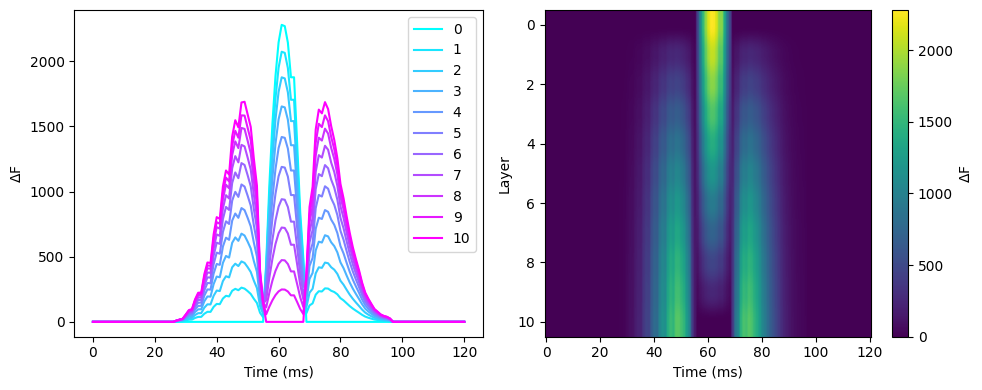

In [13]:
# Compute the relative free energy for each layer model, compared to the worst model at each time step
F_diff = np.zeros((Fs.shape[0],Fs.shape[1]))
for t in range(Fs.shape[1]):
    minF = np.min(Fs[:,t])
    F_diff[:,t] = Fs[:,t]-minF
    
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# Plot relative free energy time series
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(F_diff[l,:], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

plt.subplot(1,2,2)
h=plt.imshow(F_diff,aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
col_r=plt.colorbar(h)
col_r.set_label(r'$\Delta$F')
plt.tight_layout()

In [14]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)